In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import *
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint



In [2]:
# Hyperparameters and paths

first_execution = False  # Set to True for the first execution to split the excel file

RAW = Path("data/raw/Observations_2012-2025.xlsx")
OUT_FILT = Path("data/filtered")
OUT_CLEAN = Path("data/cleaned")
OUT_DRAFT = Path("data/drafts")

sheets_to_csv_filtered = {
    "ESPECES": "especes.csv",
    "GPS-MILIEU": "gps_milieu.csv",
    "NOM FRANÇAIS": "observations.csv",
}

sheets_to_csv_cleaned = {
    "ESPECES": "especes_clean.csv",
    "GPS-MILIEU": "gps_milieu_clean.csv",
    "NOM FRANÇAIS": "nom_francais_clean.csv",
}


In [3]:
# Original sheets declaration : 

# Run on the first execution to split and save the excel file into multiple csv files
if first_execution:
    print(split_excel_to_csvs(RAW, OUT_FILT, sheets_to_csv_filtered))

# For following executions, load the csv files directly
dfs = load_csvs(OUT_FILT, sheets_to_csv_filtered)
for k, df in dfs.items():
    print(f"{k}: {df.shape}")


# Visual inspection of dataframes, uncoment as needed
# dfs['ESPECES'].head()
# dfs['GPS-MILIEU'].head()
# dfs['NOM FRANÇAIS'].head()

ESPECES: (86, 5)
GPS-MILIEU: (651, 8)
NOM FRANÇAIS: (114497, 26)


In [4]:
# Cleaned dataframes declaration 

if first_execution:
    # Cleaning dataframes from initial loading issues
    df_clean_especes = clean_especes(dfs["ESPECES"])
    df_clean_gps = clean_gps(dfs["GPS-MILIEU"])
    df_clean_nom_francais = clean_observations(dfs["NOM FRANÇAIS"])

    # Saving cleaned dataframes back to csv files
    save_clean_csvs({"ESPECES": df_clean_especes, "GPS-MILIEU": df_clean_gps, "NOM FRANÇAIS": df_clean_nom_francais}, OUT_CLEAN)

else:
    # Loading cleaned dataframes directly from csv files
    clean_dfs = load_csvs(OUT_CLEAN, sheets_to_csv_cleaned)
    df_clean_especes = clean_dfs["ESPECES"]
    df_clean_gps = clean_dfs["GPS-MILIEU"]
    df_clean_nom_francais = clean_dfs["NOM FRANÇAIS"]

# uncomment as needed to inspect cleaned dataframes
# df_clean_especes.head()
# df_clean_gps.head()
# df_clean_nom_francais.head()

In [5]:
df_clean_especes.head()

ESPECIES_NAME                   LATIN_NAME  \
0      Aigrette bleue             Egretta caerulea   
1   Aigrette garzette             Egretta garzetta   
2   Aigrette neigeuse                Egretta thula   
3  Aigrette tricolore  Egretta tricolor ruficollis   
4      Amazone aourou            Amazona amazonica   

                          NATURE  
0                      Migrateur  
1                      Migrateur  
2                      Migrateur  
3                      Migrateur  
4  Exogène introduit par l'homme

## Dataset Familiarisation and Descriptive Analysis 
---

In [6]:
print("Data orientation summaries : ")
print(f"- Especes : {df_clean_especes.shape}")
print(f"- GPS : {df_clean_gps.shape}")
print(f"- Nom Français : {df_clean_nom_francais.shape}")

Data orientation summaries : 
- Especes : (87, 3)
- GPS : (650, 6)
- Nom Français : (114495, 26)



## Especes : 

In [7]:
df = df_clean_especes.copy()

# Basic structure and uniqueness check ------------------------------------
print("Number of species:", len(df))
print("Unique ESPECIES_NAME:", df["ESPECIES_NAME"].nunique())
print("Unique LATIN_NAME:", df["LATIN_NAME"].nunique())

# Check for duplicates
dup_species = df[df["ESPECIES_NAME"].duplicated(keep=False)].sort_values("ESPECIES_NAME")
dup_latin   = df[df["LATIN_NAME"].duplicated(keep=False)].sort_values("LATIN_NAME")

print("Duplicated:")
display(dup_species)


Number of species: 87
Unique ESPECIES_NAME: 86
Unique LATIN_NAME: 86
Duplicated:


ESPECIES_NAME        LATIN_NAME                         NATURE
7  Astrild ondulé  Estrilda astrild  Exogène introduit par l'homme
8  Astrild ondulé  Estrilda astrild  Exogène introduit par l'homme

In [8]:
# "Families" aer defined by a shared root ------------------------------------
df["ESPECIES_FAMILY"] = df["ESPECIES_NAME"].str.split().str[0]
df["LATIN_FAMILY"] = df["LATIN_NAME"].str.split().str[0]

# Count distinct families
especies_families = df["ESPECIES_FAMILY"].value_counts().reset_index()
especies_families.columns = ["ESPECIES_FAMILY", "N_ESPECIES"]

latin_families = df["LATIN_FAMILY"].value_counts().reset_index()
latin_families.columns = ["LATIN_FAMILY", "N_ESPECIES"]
    
# Also build Python dictionaries
species_family_dict = dict(zip(especies_families["ESPECIES_FAMILY"], especies_families["N_ESPECIES"]))
latin_family_dict = dict(zip(latin_families["LATIN_FAMILY"], latin_families["N_ESPECIES"]))

print("French name families (count):", len(species_family_dict))
print("Latin name families (count):", len(latin_family_dict))

print("Top 10 families (by French names):")
display(especies_families.head(10))
print("Top 10 families (by Latin names):")
display(latin_families.head(10))


French name families (count): 53
Latin name families (count): 71
Top 10 families (by French names):


ESPECIES_FAMILY  N_ESPECIES
0        Aigrette           4
1         Astrild           4
2         Colibri           4
3       Chevalier           4
4         Moqueur           4
5          Sterne           4
6      Sporophile           3
7      Hirondelle           3
8     Tourterelle           3
9         Colombe           3

Top 10 families (by Latin names):


LATIN_FAMILY  N_ESPECIES
0      Egretta           4
1     Estrilda           4
2       Tringa           3
3        Falco           3
4     Eulampis           2
5     Lonchura           2
6    Geotrygon           2
7  Onychoprion           2
8        Ardea           2
9      Zenaida           2

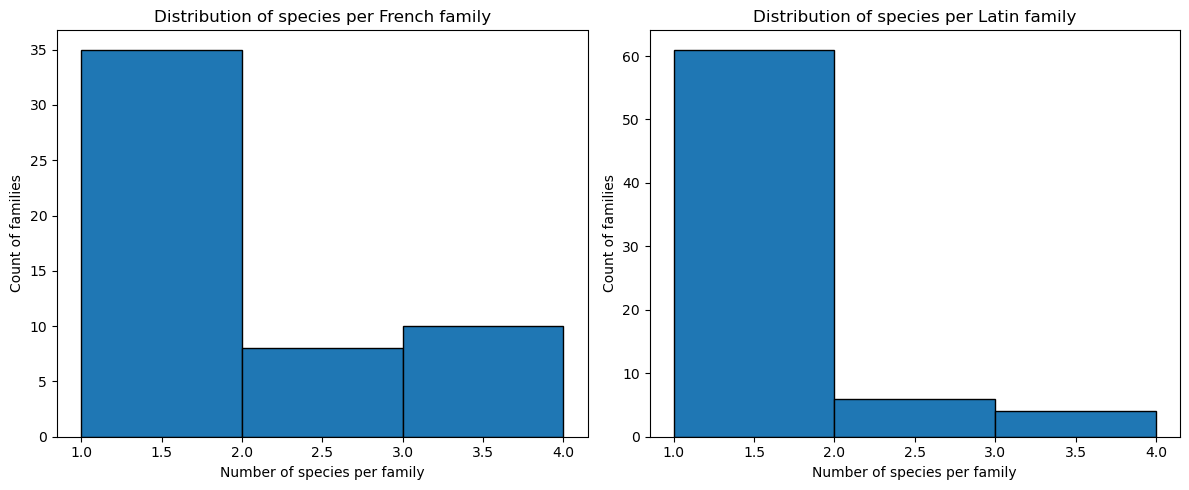

In [9]:
# Plot distribution of family sizes ------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(especies_families["N_ESPECIES"], bins=range(1, especies_families["N_ESPECIES"].max()+1), edgecolor='black')
axes[0].set_title("Distribution of species per French family")
axes[0].set_xlabel("Number of species per family")
axes[0].set_ylabel("Count of families")

axes[1].hist(latin_families["N_ESPECIES"], bins=range(1, latin_families["N_ESPECIES"].max()+1), edgecolor='black')
axes[1].set_title("Distribution of species per Latin family")
axes[1].set_xlabel("Number of species per family")
axes[1].set_ylabel("Count of families")
plt.tight_layout()
plt.show()



Distinct NATURE values:
NATURE
Migrateur                         24
Autochtone                        19
Exogène introduit par l'homme     15
Endémique des Petites Antilles    13
Marin                              8
Exogène colonisateur naturel       4
Endémique de la Martinique         2
Migrateur rare                     1
Name: count, dtype: int64
Nature distribution per family:


ESPECIES_FAMILY                         NATURE  count
0        Aigrette                      Migrateur      4
1         Amazone  Exogène introduit par l'homme      1
2         Astrild  Exogène introduit par l'homme      3
3       Balbuzard                      Migrateur      1
4         Bengali  Exogène introduit par l'homme      1
5        Bihoreau                     Autochtone      1
6        Bihoreau                      Migrateur      1
7       Bécasseau                      Migrateur      1
8          Canard  Exogène introduit par l'homme      1
9         Capucin  Exogène introduit par l'homme      2

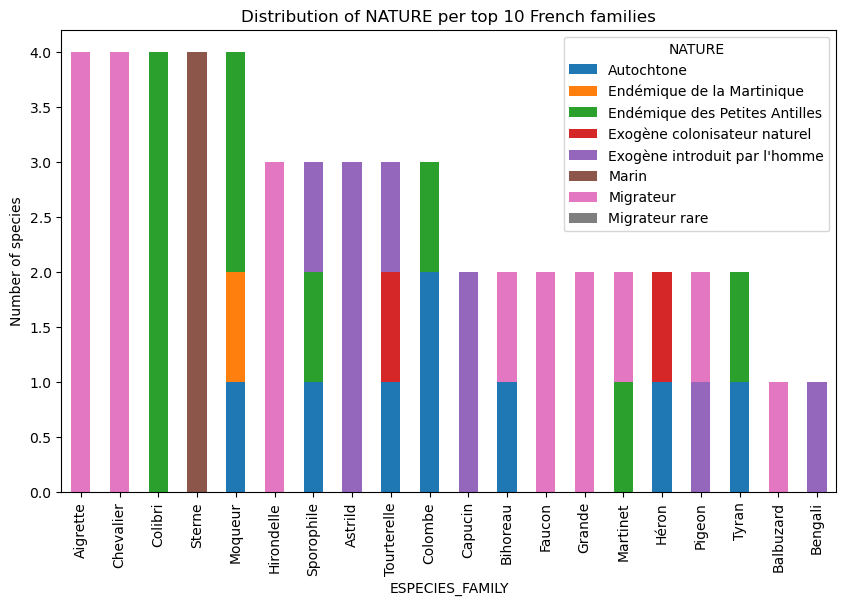

In [10]:
# NATURE analysis ------------------------------------
print("Distinct NATURE values:")
print(df["NATURE"].value_counts())

# Distribution of NATURE per family ------------------------------------
nature_by_family = (
    df.groupby(["ESPECIES_FAMILY", "NATURE"])
      .size()
      .reset_index(name="count")
)

print("Nature distribution per family:")
display(nature_by_family.sort_values(["ESPECIES_FAMILY", "count"], ascending=[True, False]).head(10))

# Pivot to make a clearer table
nature_pivot = nature_by_family.pivot_table(
    index="ESPECIES_FAMILY", columns="NATURE", values="count", fill_value=0
).astype(int)

# Plot top 10 families by total species
top_fams = nature_pivot.sum(axis=1).sort_values(ascending=False).head(20).index
nature_pivot.loc[top_fams].plot(
    kind="bar", stacked=True, figsize=(10, 6),
    title="Distribution of NATURE per top 10 French families"
)
plt.ylabel("Number of species")
plt.show()


#### Key insights for the ESPECES table :

TBD 



## GPS-MILIEU :

In [11]:
df = df_clean_gps.copy()

# Count distinct habitat types ------------------------------------
n_habitats = df["HABITAT_TYPE"].nunique()
print(f"Number of distinct habitat types: {n_habitats}")
print("Habitat types frequency:")
print(df["HABITAT_TYPE"].value_counts())

# Link habitat types to unique transect names ------------------------------------
# Remove duplicates so that each (habitat, transect_name) pair appears only once
habitat_transect = (
    df[["HABITAT_TYPE", "TRANSECT_NAME"]]
    .drop_duplicates()
    .sort_values(["HABITAT_TYPE", "TRANSECT_NAME"])
)

# For each habitat type, list unique transects
habitat_to_transects = (
    habitat_transect.groupby("HABITAT_TYPE")["TRANSECT_NAME"]
    .apply(list)
    .to_dict()
)

# Display summary ------------------------------------
print("Habitat type → number of unique transects:")
for habitat, transects in habitat_to_transects.items():
    print(f"- {habitat}: {len(transects)} transects")


Number of distinct habitat types: 7
Habitat types frequency:
HABITAT_TYPE
Forêt sèche     186
Agricole        134
Forêt humide    130
Périurbain      120
Mangrove         30
Plage            30
Urbain           20
Name: count, dtype: int64
Habitat type → number of unique transects:
- Agricole: 14 transects
- Forêt humide: 13 transects
- Forêt sèche: 19 transects
- Mangrove: 3 transects
- Plage: 3 transects
- Périurbain: 12 transects
- Urbain: 2 transects


In [12]:
print(70*"=")
# Optional: show a few examples
for habitat, transects in list(habitat_to_transects.items()):
    print(f"\n{habitat} ({len(transects)} transects):")
    print(transects)

# make a summary DataFrame and plot ------------------------------------
habitat_summary = (
    pd.DataFrame({
        "HABITAT_TYPE": list(habitat_to_transects.keys()),
        "N_TRANSECTS": [len(v) for v in habitat_to_transects.values()]
    })
    .sort_values("N_TRANSECTS", ascending=False)
)


Agricole (14 transects):
['Bois Pothau', 'Canal Cocotte', 'Cap Est', 'Carrère', 'Fonds Préville', 'Galion', 'Galion 2', 'Génipa', 'Habitation Petite Rivière', 'Hôtel des Plaisirs', 'Lafayette', 'Morne Babet', 'Moulin à Vent', 'Verrier']

Forêt humide (13 transects):
['Anse Couleuvre', 'Bois La Charles', 'Bouliki', "Domaine d'Emeraude", 'Fond Baron', "Fond l'Etang", 'Forêt Montravail', 'Forêt la Reculée', 'La Démarche 2', "Rivière l'Or", 'Route Forestière de Palourde', 'Tunnel Didier', 'Tunnel Didier 2']

Forêt sèche (19 transects):
['Anse Mathurin', 'Blin', 'Bois Pothau', 'Forêt Vatable', 'Forêt Vatable 2', 'Forêt la Philippe', 'Ilets du François', 'Ilets du Robert', 'Le Phare-Caravelle', 'Morne Bellevue', 'Morne Gardier', 'Petit Sentier RNC', 'Piton Crève-cœur', 'Pointe Banane', 'Pointe Jean-Claude', 'Pointe La Rose', 'Pointe Lynch', 'Pointe Rouge', 'Rocher Leclerc']

Mangrove (3 transects):
['Aéroport', 'Boucle du Vauclin', 'Morne Cabri']

Plage (3 transects):
['Anse Meunier', 'Autr

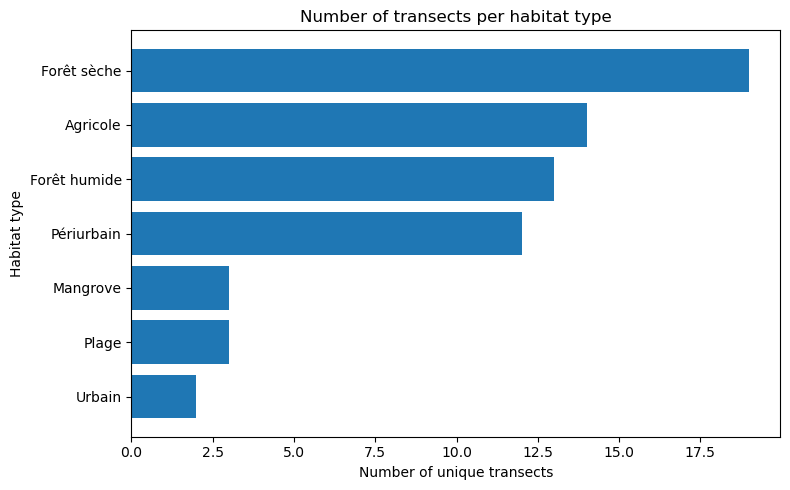

In [13]:
# Bar plot: how many transects per habitat type

plt.figure(figsize=(8, 5))
plt.barh(habitat_summary["HABITAT_TYPE"], habitat_summary["N_TRANSECTS"])
plt.xlabel("Number of unique transects")
plt.ylabel("Habitat type")
plt.title("Number of transects per habitat type")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Key insights for the GPS-MILIEU table :

TBD 

## Nom_Français : 

year  N_observations  N_species  Total_birds  Mean_birds_per_obs
0   2014.0            5378         64        10713            1.992004
1   2015.0            8162         70        17319            2.121906
2   2016.0           11011         78        22888            2.078649
3   2017.0            9228         71        20519            2.223559
4   2018.0            9733         73        20325            2.088256
5   2019.0            9572         70        21005            2.194421
6   2020.0            9956         68        21986            2.208317
7   2021.0           10604         69        23914            2.255187
8   2022.0           10804         68        24416            2.259904
9   2023.0           10224         67        22269            2.178110
10  2024.0           10051         70        21591            2.148144
11  2025.0            9266         72        19884            2.145910

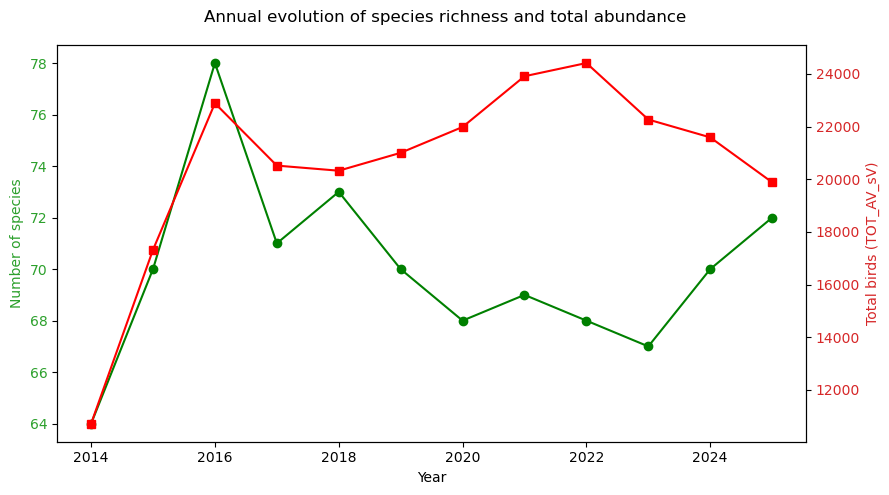

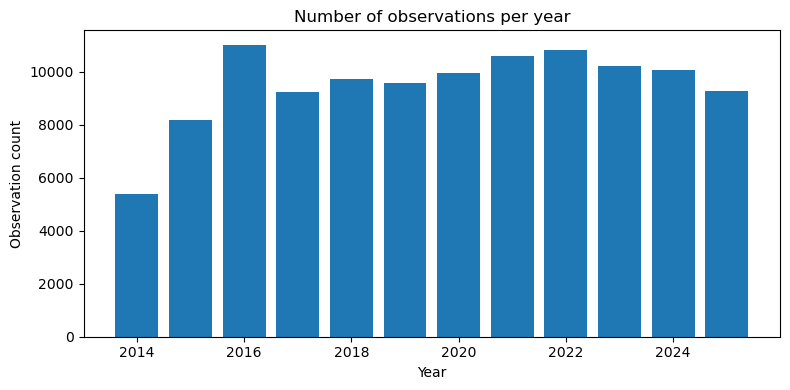

In [14]:
# Assume the cleaned observations table is already loaded:
# df_obs = pd.read_csv("data/filtered/observations_clean.csv")

df = df_clean_nom_francais.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# --- Basic yearly counts ---
annual_summary = (df.groupby("year").agg(
          N_observations=("ESPECE", "size"),
          N_species=("ESPECE", "nunique"),
          Total_birds=("TOT_AV_sV", "sum"),
          Mean_birds_per_obs=("TOT_AV_sV", "mean")
        ).reset_index()
)

display(annual_summary)

# --- Plot species richness and total abundance per year ---
fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.plot(annual_summary["year"], annual_summary["N_species"], marker="o", color="green", label="Species richness")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of species", color="tab:green")
ax1.tick_params(axis="y", labelcolor="tab:green")

ax2 = ax1.twinx()
ax2.plot(annual_summary["year"], annual_summary["Total_birds"], marker="s", color="red", label="Total birds")
ax2.set_ylabel("Total birds (TOT_AV_sV)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.suptitle("Annual evolution of species richness and total abundance")
plt.tight_layout()
plt.show()

# --- Histogram: number of observations per year ---
plt.figure(figsize=(8,4))
plt.bar(annual_summary["year"], annual_summary["N_observations"], color="tab:blue")
plt.title("Number of observations per year")
plt.xlabel("Year")
plt.ylabel("Observation count")
plt.tight_layout()
plt.show()


Nom observateur  N_observations  N_years  N_species_seen  \
19               CONDE Beatriz           41435       12              79   
6              BAHUAUD Anthony            8719       10              65   
10                BELFAN David            7331       12              48   
36                 MAUGEE Lévy            6838       12              47   
5          AUGUSTE  Christophe            5054       12              40   
35  MARRAUD des GROTTES Roland            4229       12              40   
3           ALEXANDRINE Thomas            3154       12              30   
40                 PICARD Rémi            3116        4              44   
38          MOURIESSE Jocelyne            3093       12              47   
47               VALSIN Michel            2284        9              40   

    Mean_birds  Total_birds  
19    2.166043        89750  
6     2.091868        18239  
10    2.920748        21412  
36    2.032758        13900  
5     1.628017         8228  
35    1.477418         6248  
3     1.677869         5292  
40    2.486842         7749  
38    2.316844         7166  
47    2.551226         5827

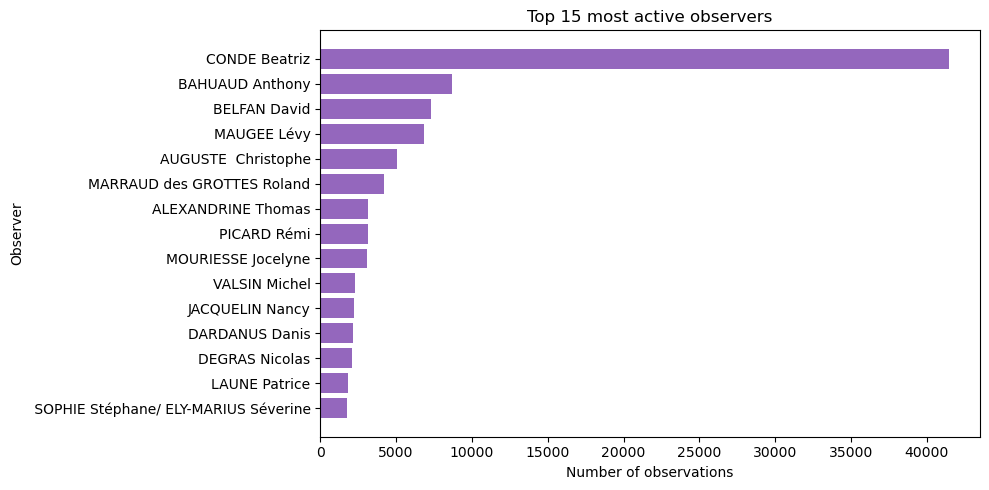

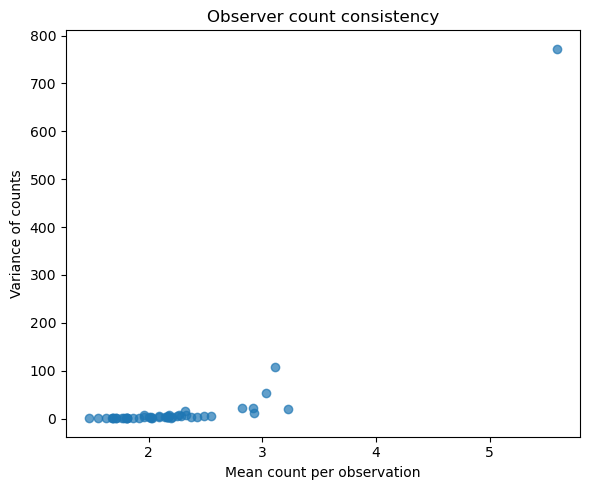

Nom observateur  Mean_count    Variance  \
2   AGAT Arnaud-FREMACX Vincent- NOSEL Christopher    5.588235  772.367059   
11                               BELLUMEUR Wilfrid    3.115187  106.896575   
43                                  ROLLIN Michaël    3.028249   53.908548   
10                                    BELFAN David    2.920748   21.326187   
28                                  FLERIAG Lyneda    2.817460   20.952066   
32                                  LABONNE Annick    3.223656   20.467112   
38                              MOURIESSE Jocelyne    2.316844   15.629202   
31                                 JACQUELIN Nancy    2.924242   11.098137   
18                              CHANTEUR Bénédicte    2.267857    7.934074   
20                                  CONDE Beatriz     2.327536    7.215083   

    count  
2      51  
11   1554  
43    354  
10   7331  
28    756  
32    465  
38   3093  
31   2244  
18    504  
20    345

In [15]:
# --- Observer participation summary ---
observer_summary = (
    df.groupby("Nom observateur")
      .agg(
          N_observations=("ESPECE", "size"),
          N_years=("year", "nunique"),
          N_species_seen=("ESPECE", "nunique"),
          Mean_birds=("TOT_AV_sV", "mean"),
          Total_birds=("TOT_AV_sV", "sum")
      )
      .reset_index()
      .sort_values("N_observations", ascending=False)
)

display(observer_summary.head(10))

# --- Plot: top observers by number of observations ---
plt.figure(figsize=(10,5))
top_obs = observer_summary.head(15)
plt.barh(top_obs["Nom observateur"], top_obs["N_observations"], color="tab:purple")
plt.xlabel("Number of observations")
plt.ylabel("Observer")
plt.title("Top 15 most active observers")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Observer consistency: mean vs variance of counts ---
# (A simple reliability proxy — stable observers have low variance in total counts)
observer_variability = (
    df.groupby("Nom observateur")["TOT_AV_sV"]
      .agg(["mean", "var", "count"])
      .rename(columns={"mean": "Mean_count", "var": "Variance"})
      .reset_index()
)

plt.figure(figsize=(6,5))
plt.scatter(observer_variability["Mean_count"], observer_variability["Variance"], alpha=0.7)
plt.xlabel("Mean count per observation")
plt.ylabel("Variance of counts")
plt.title("Observer count consistency")
plt.tight_layout()
plt.show()

# Observers with very high variance relative to mean may indicate inconsistent detection
display(observer_variability.sort_values("Variance", ascending=False).head(10))


In [16]:

# Assume df_obs is your cleaned observations DataFrame
df = df_clean_nom_francais.copy()

# Unique mapping of observer ↔ transect (ignoring point duplicates)
observer_transect = (
    df[["Nom observateur", "Nom transect"]]
    .drop_duplicates()
    .sort_values(["Nom observateur", "Nom transect"])
)

print(f"Total unique observer-transect pairs: {len(observer_transect)}")
display(observer_transect.head(10))

# For each observer, list all transects they have worked on
observer_to_transects = (
    observer_transect.groupby("Nom observateur")["Nom transect"]
    .apply(list)
    .to_dict()
)

# Example output: {"Alice": ["Transect_1", "Transect_4"], "Bob": ["Transect_2"], ...}
print("Example observer to transects mapping:")
for k, v in list(observer_to_transects.items())[:5]:
    print(f"- {k}: {len(v)} transects → {v[:5]}")


Total unique observer-transect pairs: 142


Nom observateur  \
82826             SOPHIE Stéphane/ ELY-MARIUS Séverine   
76732             SOPHIE Stéphane/ ELY-MARIUS Séverine   
18582                                    VALSIN Michel   
109532  AGAT Arnaud-FREMACX Vincent- NOSEL Christopher   
47188                               ALEXANDRINE Thomas   
4919                                ALEXANDRINE Thomas   
4867                                ALEXANDRINE Thomas   
113860                             ALEXANDRINE Thomas    
113815                             ALEXANDRINE Thomas    
113961                             ALEXANDRINE Thomas    

                     Nom transect  
82826   Habitation Petite Rivière  
76732               Moulin à Vent  
18582              Morne Bellevue  
109532          Ilets du François  
47188          Le Phare-Caravelle  
4919            Petit Sentier RNC  
4867                 Pointe Rouge  
113860         Le Phare-Caravelle  
113815          Petit Sentier RNC  
113961               Pointe Rouge

Example observer to transects mapping:
-  SOPHIE Stéphane/ ELY-MARIUS Séverine: 2 transects → ['Habitation Petite Rivière', 'Moulin à Vent']
-  VALSIN Michel: 1 transects → ['Morne Bellevue']
- AGAT Arnaud-FREMACX Vincent- NOSEL Christopher: 1 transects → ['Ilets du François']
- ALEXANDRINE Thomas: 3 transects → ['Le Phare-Caravelle', 'Petit Sentier RNC', 'Pointe Rouge']
- ALEXANDRINE Thomas : 3 transects → ['Le Phare-Caravelle', 'Petit Sentier RNC', 'Pointe Rouge']


In [17]:
observer_to_transects

{' SOPHIE Stéphane/ ELY-MARIUS Séverine': ['Habitation Petite Rivière',
  'Moulin à Vent'],
 ' VALSIN Michel': ['Morne Bellevue'],
 'AGAT Arnaud-FREMACX Vincent- NOSEL Christopher': ['Ilets du François'],
 'ALEXANDRINE Thomas': ['Le Phare-Caravelle',
  'Petit Sentier RNC',
  'Pointe Rouge'],
 'ALEXANDRINE Thomas ': ['Le Phare-Caravelle',
  'Petit Sentier RNC',
  'Pointe Rouge'],
 'AUGUSTE  Christophe': ['ANSE COULEUVRE',
  'Anse Couleuvre',
  "Domaine d'Emeraude",
  'Fond Baron',
  'Fond Baron ',
  'Route Forestière de Palourde'],
 'BAHUAUD Anthony': ['Bouliki',
  'Canal Cocotte',
  'Desmarinière',
  'Desmarinières',
  'Génipa',
  'Lafayette',
  'Là-Haut'],
 'BAHUAUD Anthony ': ['Génipa', 'Là-Haut'],
 'BARBET Christophe': ['Bouliki'],
 'BATIFOULIER Sébastien': ['Fonds Préville', 'Forêt La Philippe'],
 'BELFAN David': ["Fond l'Etang",
  'Fort de France Centre Ville',
  'Pointe La Rose',
  'Tunnel Didier',
  'Tunnel Didier ',
  'Tunnel Didier 2'],
 'BELLUMEUR Wilfrid': ['Ilets du Robert'

In [18]:
# Count total observations (rows) per observer
obs_per_observer = (
    df.groupby("Nom observateur")
      .size()
      .reset_index(name="N_observations")
      .sort_values("N_observations", ascending=False)
)

print("Top 10 most active observers:")
display(obs_per_observer.head(10))

# Count total observations per transect
obs_per_transect = (
    df.groupby("Nom transect")
      .size()
      .reset_index(name="N_observations")
      .sort_values("N_observations", ascending=False)
)

print("Top 10 most observed transects:")
display(obs_per_transect.head(10))



Top 10 most active observers:


Nom observateur  N_observations
19               CONDE Beatriz           41435
6              BAHUAUD Anthony            8719
10                BELFAN David            7331
36                 MAUGEE Lévy            6838
5          AUGUSTE  Christophe            5054
35  MARRAUD des GROTTES Roland            4229
3           ALEXANDRINE Thomas            3154
40                 PICARD Rémi            3116
38          MOURIESSE Jocelyne            3093
47               VALSIN Michel            2284

Top 10 most observed transects:


Nom transect  N_observations
50                Morne Babet            2878
38  Habitation Petite Rivière            2821
55              Moulin à Vent            2792
47                    Là-Haut            2383
39         Hôtel des Plaisirs            2366
4                  Autre Bord            2334
11                    Borelie            2287
24              Fond Rousseau            2253
42                    Jeannot            2222
56                  O'Mullane            2203

In [19]:
# Extract year from date
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Ensure weather covariates are numeric (in case they were strings)
weather_cols = ["nuages", "pluie", "vent", "visibilité"]
df[weather_cols] = df[weather_cols].apply(pd.to_numeric, errors="coerce")

transect_year_stats = (
    df.groupby(["Nom transect", "year"])[weather_cols]
      .mean()
      .reset_index()
)

# Add number of observations for each transect-year
transect_obs_count = (
    df.groupby(["Nom transect", "year"])
      .size()
      .reset_index(name="N_observations")
)
transect_year_stats = transect_year_stats.merge(transect_obs_count, on=["Nom transect", "year"])

display(transect_year_stats.head(10))


Nom transect    year    nuages     pluie      vent  visibilité  \
0  ANSE COULEUVRE  2019.0  1.757282  1.213592  1.339806    1.582524   
1  Anse Couleuvre  2014.0  1.750000  1.086538  1.250000    1.423077   
2  Anse Couleuvre  2015.0  1.892562  1.057851  2.000000    2.000000   
3  Anse Couleuvre  2016.0  2.228070  1.087719  1.061404    1.447368   
4  Anse Couleuvre  2017.0  1.978495  1.204301  1.000000    1.634409   
5  Anse Couleuvre  2018.0  1.220930  1.034884  1.000000    1.139535   
6  Anse Couleuvre  2020.0  2.000000  1.207547  1.886792    1.735849   
7  Anse Couleuvre  2021.0  1.517241  1.189655  1.000000    1.344828   
8  Anse Couleuvre  2022.0  3.000000  1.769231  2.175824    2.505495   
9  Anse Couleuvre  2023.0  2.000000  1.310924  2.134454    1.689076   

   N_observations  
0             103  
1             104  
2             121  
3             114  
4              93  
5              86  
6              53  
7             116  
8              91  
9             119

ESPECE    year  N_observations
0     Aigrette bleue  2014.0               1
1     Aigrette bleue  2015.0               2
2     Aigrette bleue  2016.0               3
3     Aigrette bleue  2020.0               3
4     Aigrette bleue  2024.0               1
5  Aigrette neigeuse  2014.0               6
6  Aigrette neigeuse  2015.0              13
7  Aigrette neigeuse  2016.0              23
8  Aigrette neigeuse  2017.0              17
9  Aigrette neigeuse  2018.0              25

ESPECE  N_years_observed
1        Aigrette neigeuse                12
3           Amazone aourou                12
20       Chevalier grivelé                12
17  Capucin à tête blanche                12
12        Bihoreau violacé                12
8   Astrild à joues orange                12
7           Astrild ondulé                12
27     Colombe rouviolette                12
35        Elénie siffleuse                12
32         Coulicou manioc                12

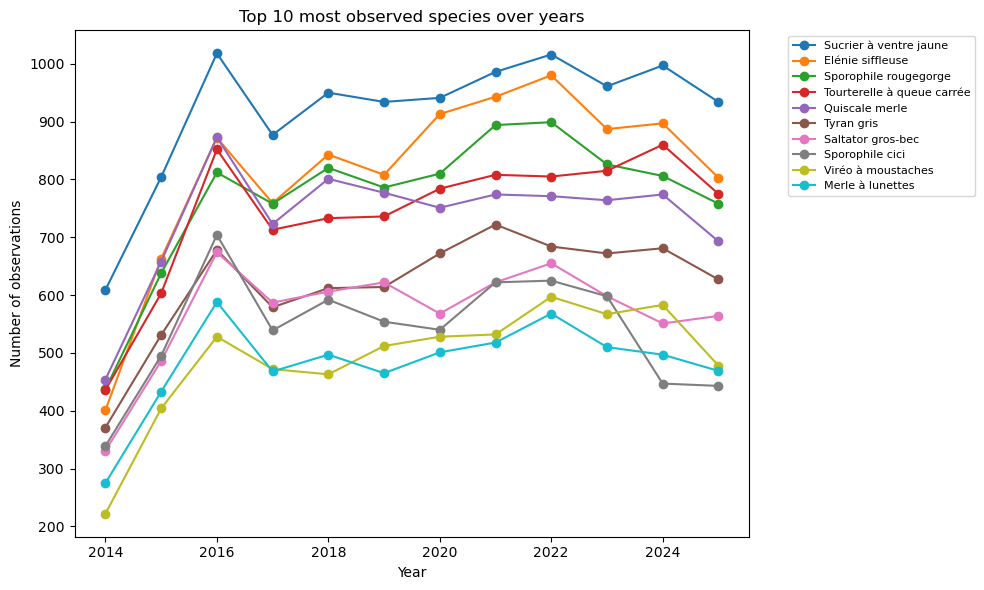

In [20]:
df = df_clean_nom_francais.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# --- Count number of observations per species per year ---
species_year_counts = (
    df.groupby(["ESPECE", "year"])
      .size()
      .reset_index(name="N_observations")
      .sort_values(["ESPECE", "year"])
)

display(species_year_counts.head(10))

# --- Total number of years each species was observed ---
species_total = (
    species_year_counts.groupby("ESPECE")["year"]
      .nunique()
      .reset_index(name="N_years_observed")
      .sort_values("N_years_observed", ascending=False)
)
display(species_total.head(10))

# --- Example: plot top 10 most observed species over time ---
top_species = (
    species_year_counts.groupby("ESPECE")["N_observations"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

plt.figure(figsize=(10,6))
for specie in top_species:
    subset = species_year_counts[species_year_counts["ESPECE"] == specie]
    plt.plot(subset["year"], subset["N_observations"], marker="o", label=specie)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.title("Top 10 most observed species over years")
plt.xlabel("Year")
plt.ylabel("Number of observations")
plt.tight_layout()
plt.show()


FAMILY    year  N_observations
0  Aigrette  2014.0               7
1  Aigrette  2015.0              15
2  Aigrette  2016.0              26
3  Aigrette  2017.0              17
4  Aigrette  2018.0              25
5  Aigrette  2019.0              26
6  Aigrette  2020.0              21
7  Aigrette  2021.0              15
8  Aigrette  2022.0              15
9  Aigrette  2023.0              17

FAMILY  N_years_observed
0    Aigrette                12
1     Amazone                12
2     Astrild                12
5    Bihoreau                12
19  Gallinule                12
10    Colibri                12
9   Chevalier                12
8     Capucin                12
11    Colombe                12
18    Frégate                12

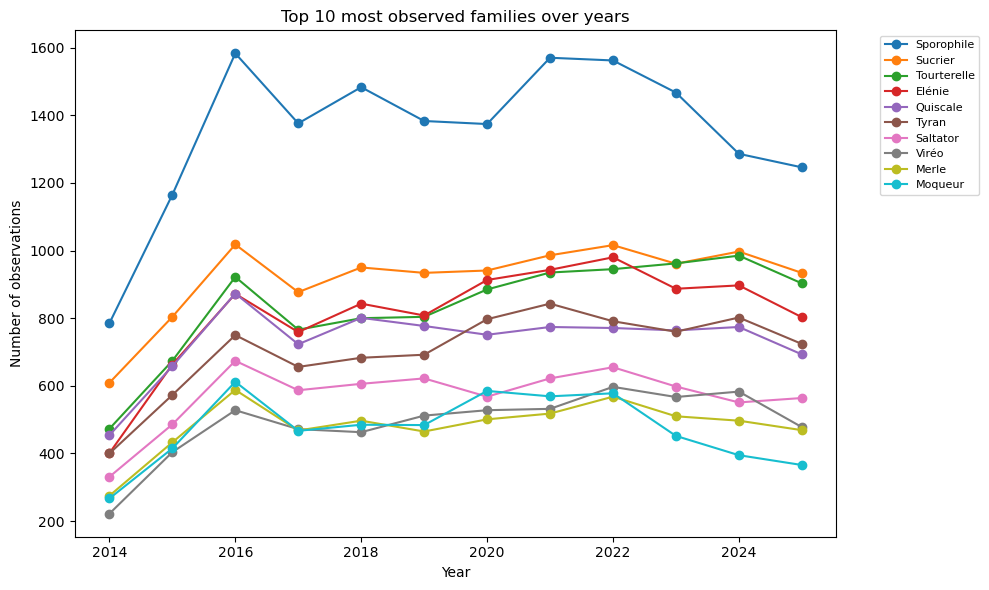

In [21]:
# Create mapping ESPECE (name) → family
df_clean_especes["ESPECIES_FAMILY"] = df_clean_especes["ESPECIES_NAME"].str.split().str[0]
species_to_family = dict(zip(df_clean_especes["ESPECIES_NAME"], df_clean_especes["ESPECIES_FAMILY"]))

# Map to observations table
df["FAMILY"] = df["ESPECE"].map(species_to_family)

# --- Count observations per family per year ---
family_year_counts = (
    df.groupby(["FAMILY", "year"])
      .size()
      .reset_index(name="N_observations")
      .sort_values(["FAMILY", "year"])
)

display(family_year_counts.head(10))

# --- Total number of years each family observed ---
family_total = (
    family_year_counts.groupby("FAMILY")["year"]
      .nunique()
      .reset_index(name="N_years_observed")
      .sort_values("N_years_observed", ascending=False)
)
display(family_total.head(10))

# --- Plot top 10 most observed families ---
top_families = (
    family_year_counts.groupby("FAMILY")["N_observations"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

plt.figure(figsize=(10,6))
for fam in top_families:
    subset = family_year_counts[family_year_counts["FAMILY"] == fam]
    plt.plot(subset["year"], subset["N_observations"], marker="o", label=fam)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.title("Top 10 most observed families over years")
plt.xlabel("Year")
plt.ylabel("Number of observations")
plt.tight_layout()
plt.show()


#### Key insights for the NOM_FRANÇAIS table :

TBD 

# Multi-Year Indicator Trends
---

### Species Diversity

For the following measures we consider $p_i$ to be : 

$p_i = \frac{abundannce_i}{total}$ per year

```Shannon Diversity index```

The higher the value of H, the higher the diversity of species in a particular community. The lower the value of H, the lower the diversity. A value of H = 0 indicates a community that only has one species.

$H' = -\sum_i p_i ln(p_i)$

Where $p_i$ is the proportion of the entire community made up of species i

The higher the value of H, the higher the diversity of species in a particular community. The lower the value of H, the lower the diversity. A value of H = 0 indicates a community that only has one species.

https://www.statology.org/shannon-diversity-index/


```Simpson Diversity index```
Simpson's Diversity Index is a measure of diversity which takes into account the number of species present, as well as the relative abundance of each species. As species richness and evenness increase, so diversity increases.

A community dominated by one or two species is considered to be less diverse than one in which several different species have a similar abundance.


We use the formula :

$1-D$, where $D = \sum_i p_i^2$

https://geographyfieldwork.com/Simpson'sDiversityIndex.htm#:~:text=Simpson's%20Diversity%20Index%20is%20a,evenness%20increase%2C%20so%20diversity%20increases.&text=The%20value%20of%20D%20ranges%20between%200%20and%201.

In [22]:
# For each year, compute counts per species
df = df_clean_nom_francais.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year
# Aggregate bird counts per species per year
year_species_counts = (
    df.groupby(["year", "ESPECE"])["TOT_AV_sV"]
      .sum()
      .reset_index()
)

# --- Helper functions for diversity ---
# Define diversity functions
def shannon_index(counts):
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12))

def simpson_index(counts):
    p = counts / counts.sum()
    return 1 - np.sum(p**2)

# Aggregate per year using .agg to produce flat columns
diversity_year = (
    year_species_counts.groupby("year")["TOT_AV_sV"]
    .agg(
        Shannon=lambda x: shannon_index(x),
        Simpson=lambda x: simpson_index(x),
        Richness=lambda x: (x > 0).sum(),
        Total_birds="sum"
    )
    .reset_index()
)

display(diversity_year)

year   Shannon   Simpson  Richness  Total_birds
0   2014.0  2.946971  0.918521        61        10713
1   2015.0  3.048411  0.926885        64        17319
2   2016.0  3.045182  0.926049        74        22888
3   2017.0  3.016821  0.925098        71        20519
4   2018.0  2.994555  0.923016        71        20325
5   2019.0  3.011572  0.924549        70        21005
6   2020.0  3.039662  0.928024        67        21986
7   2021.0  3.040355  0.928734        67        23914
8   2022.0  3.030549  0.929514        66        24416
9   2023.0  3.053052  0.930277        67        22269
10  2024.0  3.030088  0.927285        67        21591
11  2025.0  3.107287  0.933989        71        19884

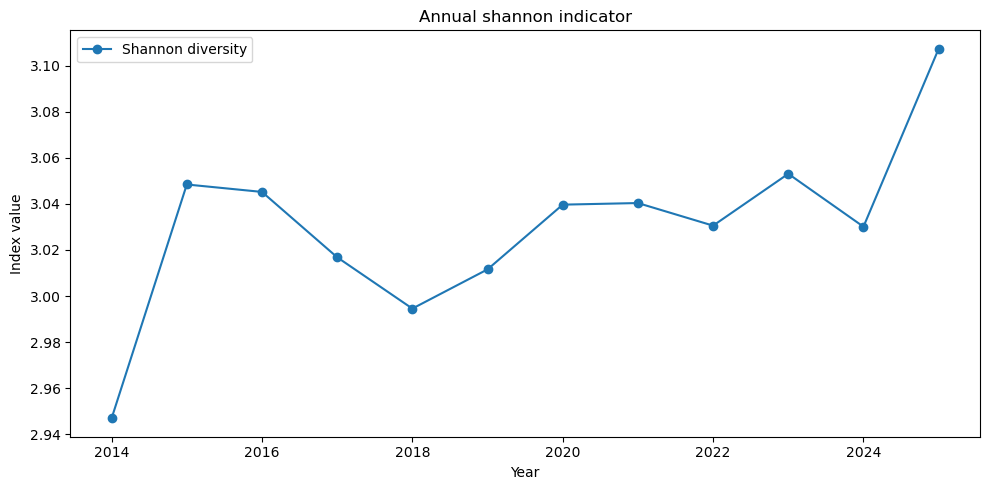

In [23]:
# Plot diversity indices over years
plt.figure(figsize=(10,5))
plt.plot(diversity_year["year"], diversity_year["Shannon"], marker="o", label="Shannon diversity")
plt.legend()
plt.title("Annual shannon indicator")
plt.xlabel("Year")
plt.ylabel("Index value")
plt.tight_layout()
plt.show()


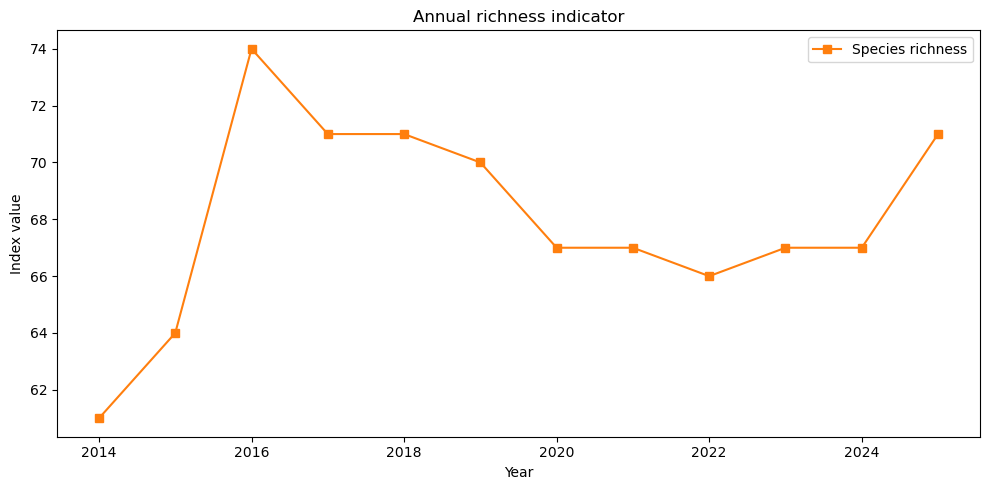

In [24]:
# Plot diversity indices over years
plt.figure(figsize=(10,5))
plt.plot(diversity_year["year"], diversity_year["Richness"], marker="s", label="Species richness", color="tab:orange")
plt.legend()
plt.title("Annual richness indicator")
plt.xlabel("Year")
plt.ylabel("Index value")
plt.tight_layout()
plt.show()


In [25]:

X = sm.add_constant(diversity_year["year"])
model = sm.OLS(diversity_year["Shannon"], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                Shannon   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     6.419
Date:                Thu, 06 Nov 2025   Prob (F-statistic):             0.0297
Time:                        12:30:00   Log-Likelihood:                 25.692
No. Observations:                  12   AIC:                            -47.38
Df Residuals:                      10   BIC:                            -46.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.2997      5.261     -1.958      0.0

/home/dev/miniconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [26]:
# --- Bootstrap function --- Utils.py 
def bootstrap_diversity(df_year, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    results = []
    counts = df_year["TOT_AV_sV"].values
    for _ in range(n_boot):
        sample = rng.choice(counts, size=len(counts), replace=True)
        results.append({
            "Shannon": shannon_index(sample),
            "Simpson": simpson_index(sample),
            "Richness": np.sum(sample > 0)
        })
    boot_df = pd.DataFrame(results)
    ci = boot_df.quantile([0.025, 0.975]).T  # 95% CI
    mean = boot_df.mean()
    out = mean.to_frame("mean").join(ci)
    out.columns = ["mean", "ci_low", "ci_high"]
    return out

In [27]:

# --- Compute diversity and bootstrap CIs per year ---
year_species_counts = (
    df.groupby(["year", "ESPECE"])["TOT_AV_sV"]
      .sum()
      .reset_index()
)

records = []
for year, sub in year_species_counts.groupby("year"):
    ci = bootstrap_diversity(sub)
    records.append({
        "year": year,
        "Shannon": ci.loc["Shannon", "mean"],
        "Shannon_low": ci.loc["Shannon", "ci_low"],
        "Shannon_high": ci.loc["Shannon", "ci_high"],
        "Simpson": ci.loc["Simpson", "mean"],
        "Simpson_low": ci.loc["Simpson", "ci_low"],
        "Simpson_high": ci.loc["Simpson", "ci_high"],
        "Richness": ci.loc["Richness", "mean"],
        "Richness_low": ci.loc["Richness", "ci_low"],
        "Richness_high": ci.loc["Richness", "ci_high"]
    })

diversity_boot = pd.DataFrame(records)
display(diversity_boot.head())

year   Shannon  Shannon_low  Shannon_high   Simpson  Simpson_low  \
0  2014.0  2.978878     2.676385      3.251518  0.920573     0.882347   
1  2015.0  3.069436     2.798562      3.319134  0.927852     0.896088   
2  2016.0  3.070719     2.782250      3.328367  0.927350     0.894382   
3  2017.0  3.043192     2.775195      3.290778  0.926186     0.892489   
4  2018.0  3.020298     2.715019      3.274737  0.924691     0.888218   

   Simpson_high  Richness  Richness_low  Richness_high  
0      0.946147    61.018          57.0           64.0  
1      0.949484    64.166          59.0           68.0  
2      0.950251    74.002          70.0           77.0  
3      0.947962    71.000          71.0           71.0  
4      0.948450    71.062          68.0           73.0

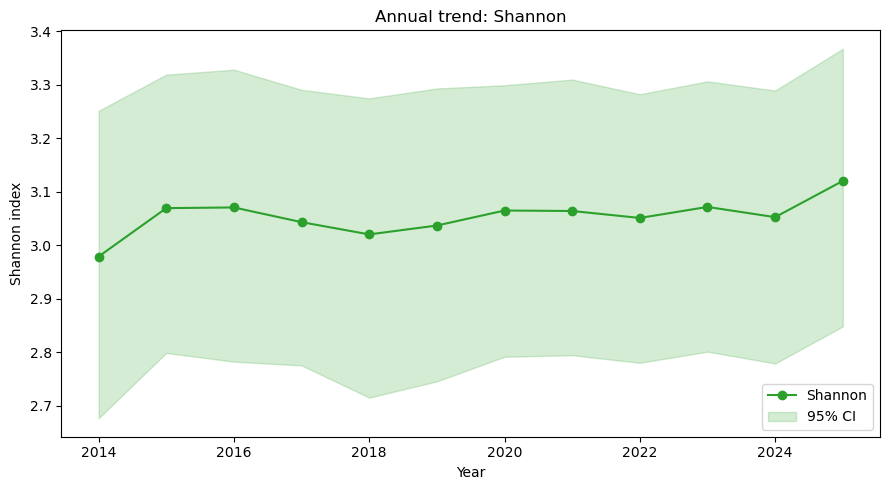

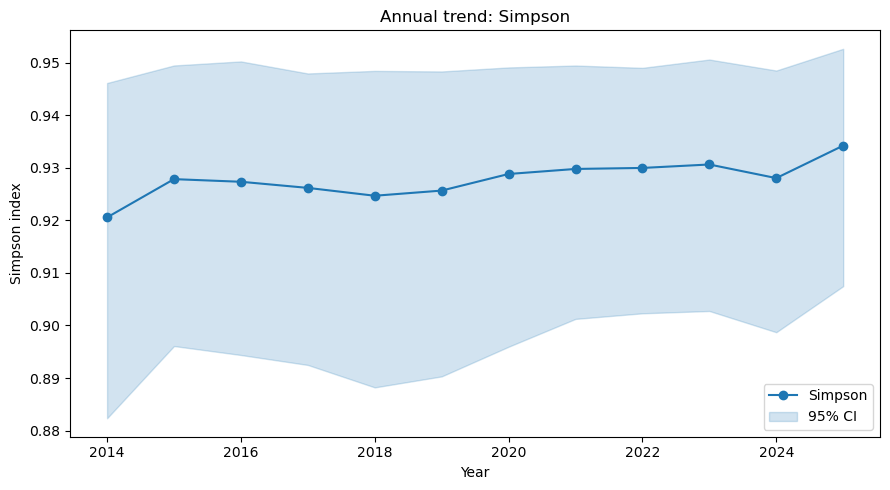

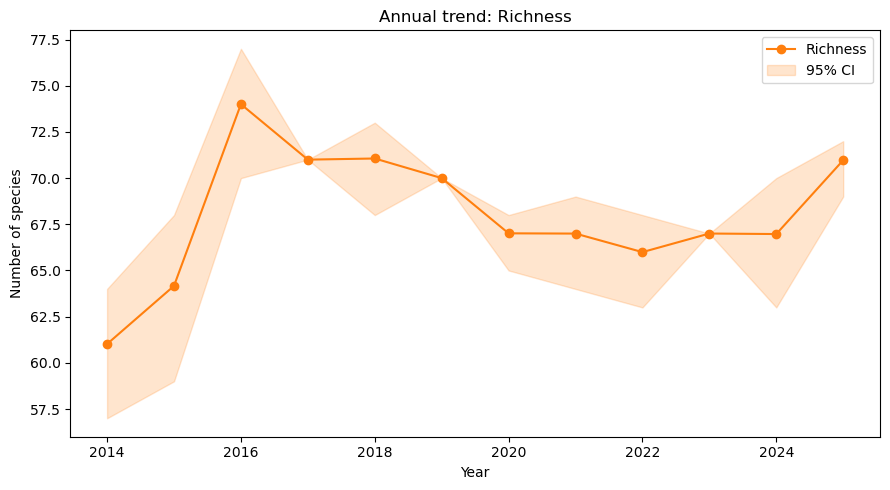

In [28]:
def plot_indicator_with_ci(df, indicator, color, ylabel):
    plt.figure(figsize=(9, 5))
    plt.plot(df["year"], df[indicator], color=color, marker="o", label=indicator)
    plt.fill_between(df["year"], df[f"{indicator}_low"], df[f"{indicator}_high"], 
                     color=color, alpha=0.2, label="95% CI")
    plt.title(f"Annual trend: {indicator}")
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_indicator_with_ci(diversity_boot, "Shannon", "tab:green", "Shannon index")
plot_indicator_with_ci(diversity_boot, "Simpson", "tab:blue", "Simpson index")
plot_indicator_with_ci(diversity_boot, "Richness", "tab:orange", "Number of species")


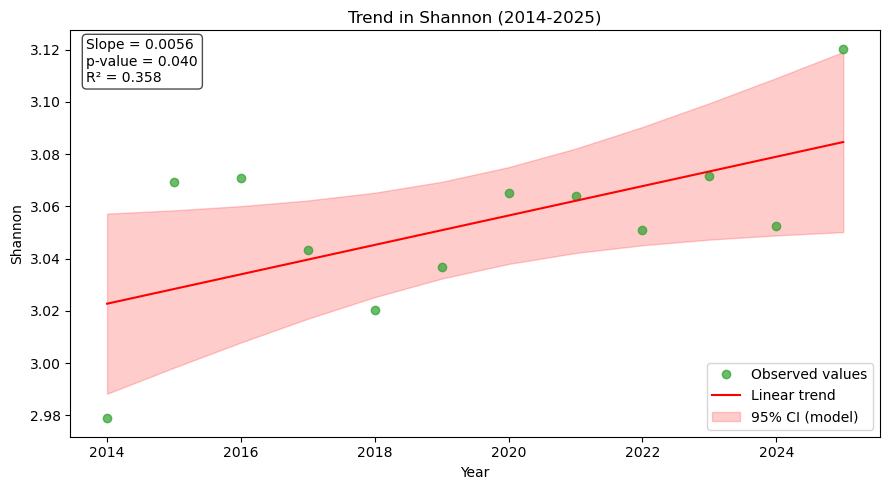

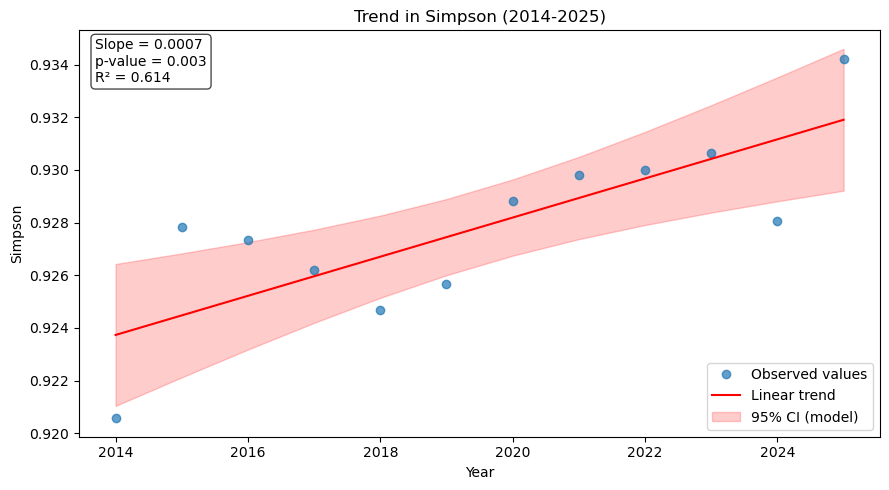

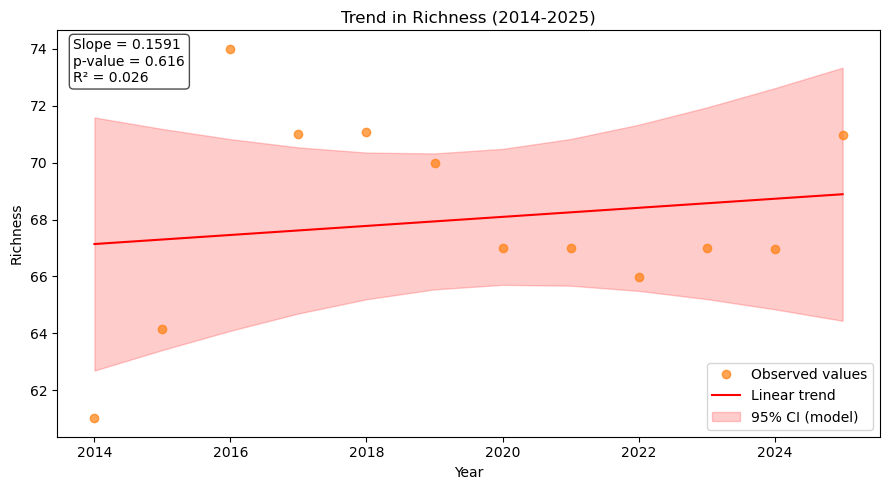

In [29]:
def plot_trend_with_stats(df, indicator, color="tab:blue"):
    """
    Fits a linear trend for the given indicator and plots:
    - Observed annual values
    - Regression line
    - Confidence interval band
    - Annotates slope and p-value
    """
    X = sm.add_constant(df["year"])
    y = df[indicator]
    model = sm.OLS(y, X).fit()

    slope = model.params["year"]
    p_value = model.pvalues["year"]
    r2 = model.rsquared

    # Predictions with confidence intervals
    pred = model.get_prediction(X)
    pred_summary = pred.summary_frame(alpha=0.05)

    # Plot
    plt.figure(figsize=(9, 5))
    plt.plot(df["year"], y, "o", color=color, label="Observed values", alpha=0.7)
    plt.plot(df["year"], pred_summary["mean"], "r-", label="Linear trend")
    plt.fill_between(
        df["year"],
        pred_summary["mean_ci_lower"],
        pred_summary["mean_ci_upper"],
        color="r", alpha=0.2, label="95% CI (model)"
    )
    plt.title(f"Trend in {indicator} (2014-2025)")
    plt.xlabel("Year")
    plt.ylabel(indicator)
    plt.legend(loc="best")
    
    # Annotate slope and p-value
    plt.text(
        0.02, 0.98,
        f"Slope = {slope:.4f}\n"
        f"p-value = {p_value:.3f}\n"
        f"R² = {r2:.3f}",
        transform=plt.gca().transAxes,
        va="top", ha="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )
    plt.tight_layout()
    plt.show()
    
    return model

# --- Example usage for all three indicators ---
model_shannon = plot_trend_with_stats(diversity_boot, "Shannon", color="tab:green")
model_simpson = plot_trend_with_stats(diversity_boot, "Simpson", color="tab:blue")
model_richness = plot_trend_with_stats(diversity_boot, "Richness", color="tab:orange")


A linear model reveals a small but significant positive trend in Shannon diversity from 2014 to 2025 (β=0.007, p<0.05), suggesting a gradual increase in species evenness and richness.

p-value = 0.04 (< 0.05):
→ statistically significant trend (there’s less than 5% chance this pattern is random).

### Density

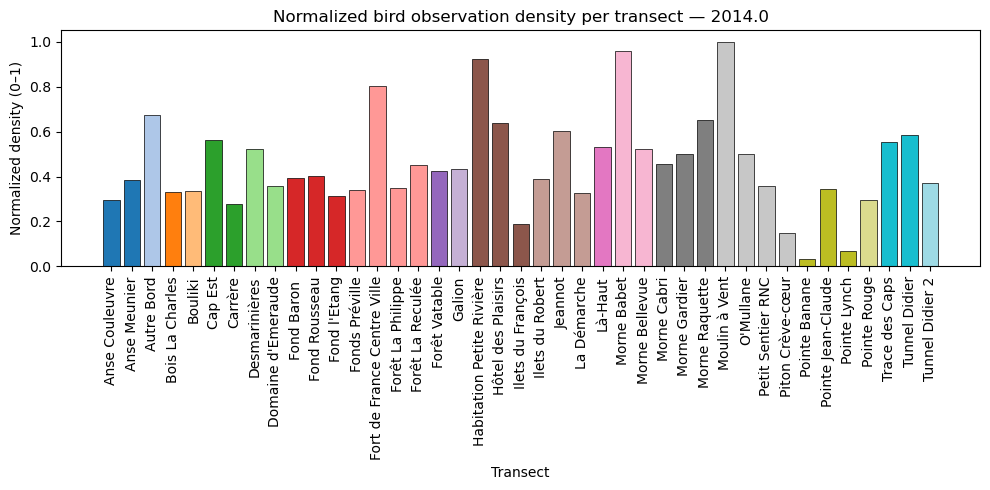

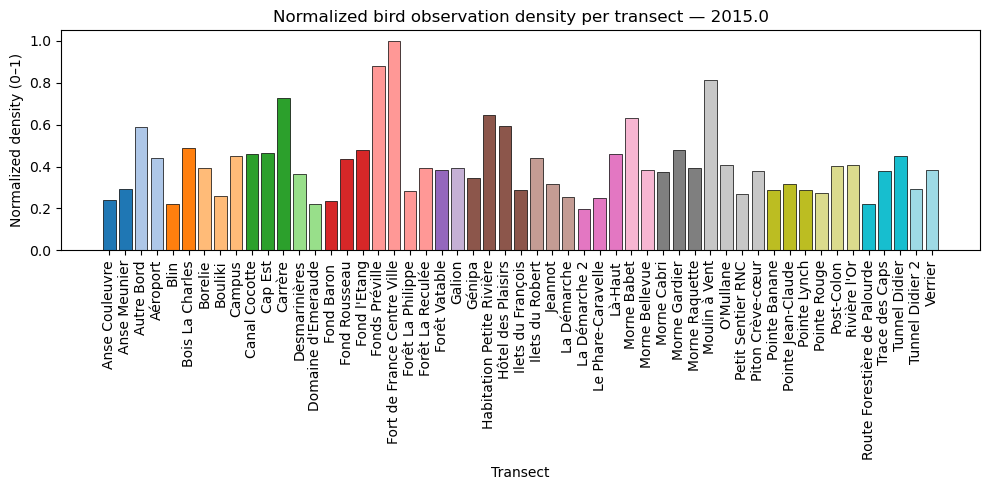

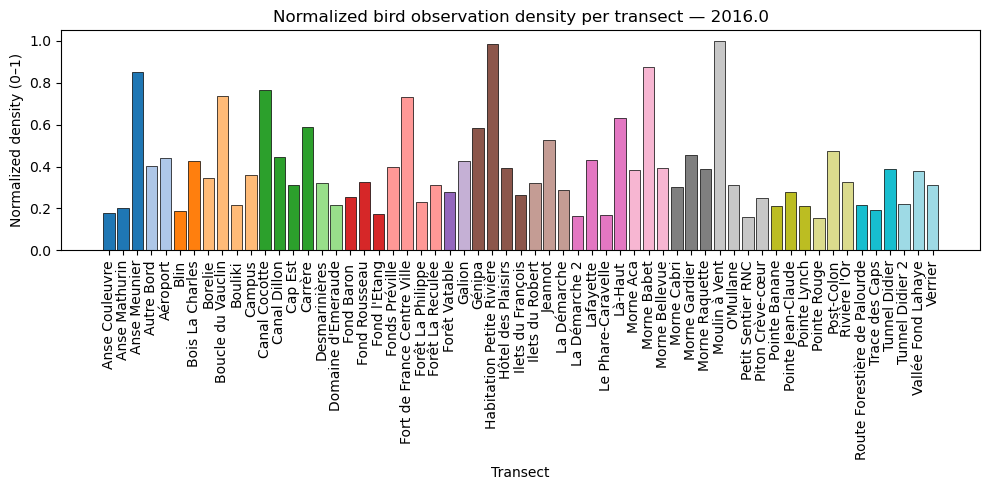

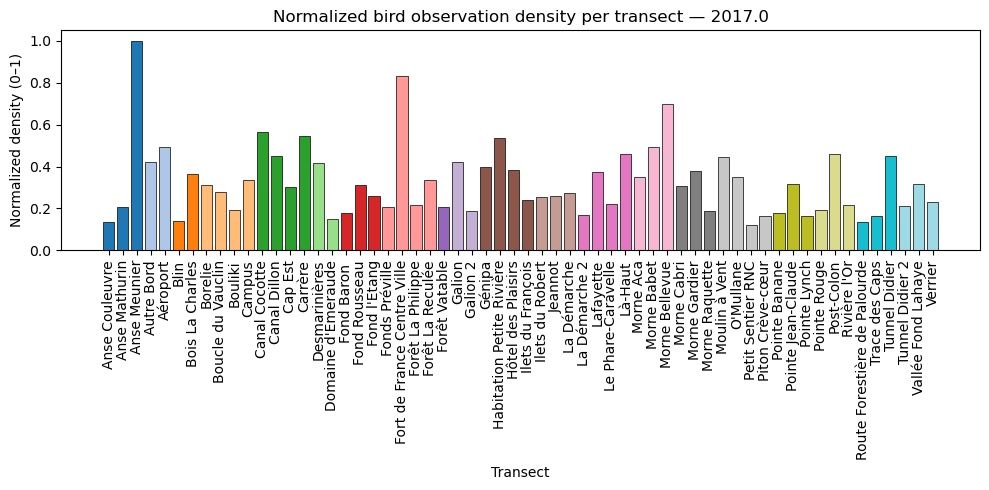

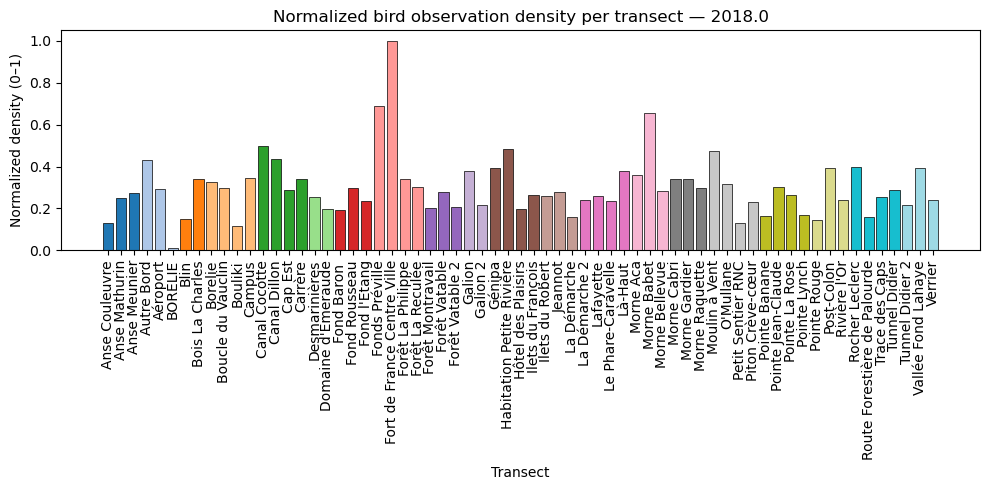

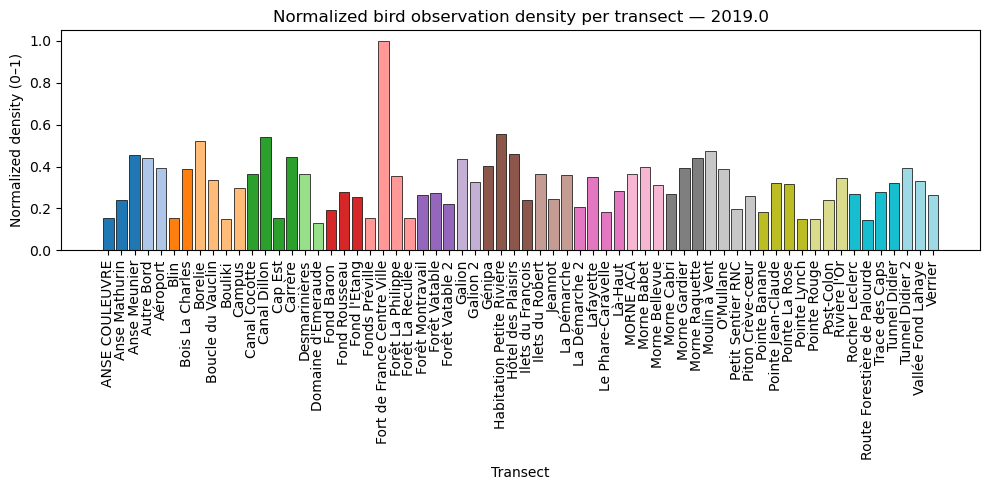

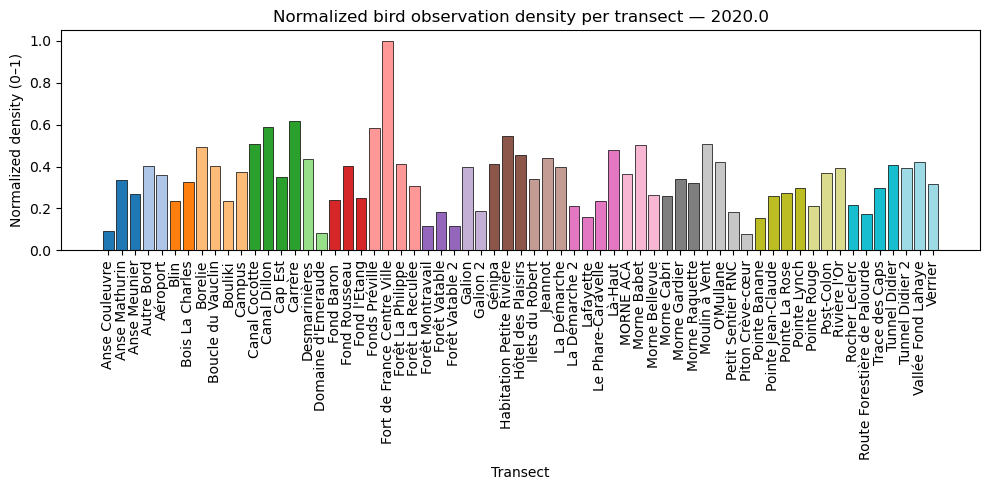

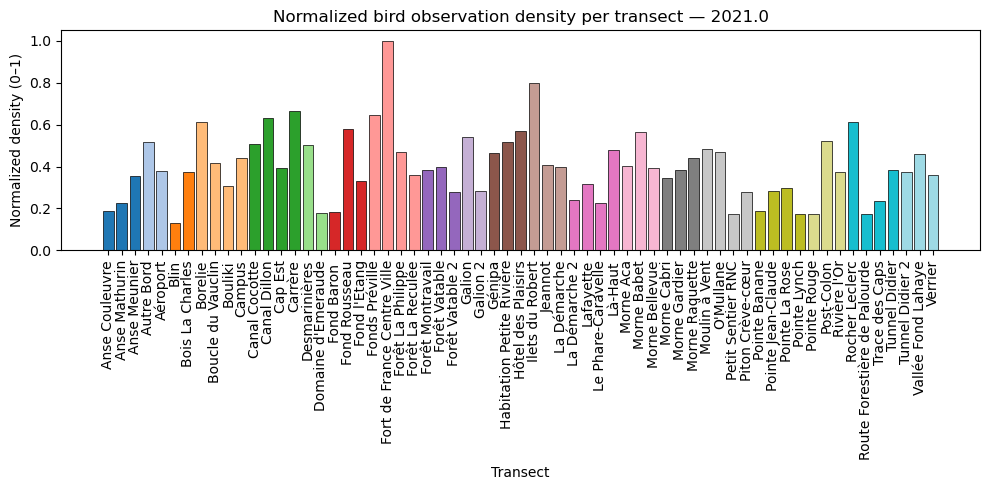

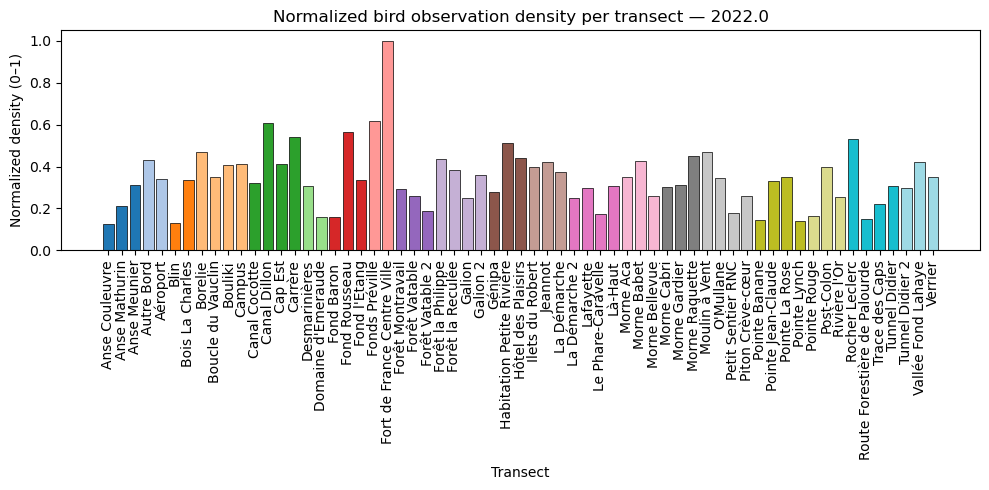

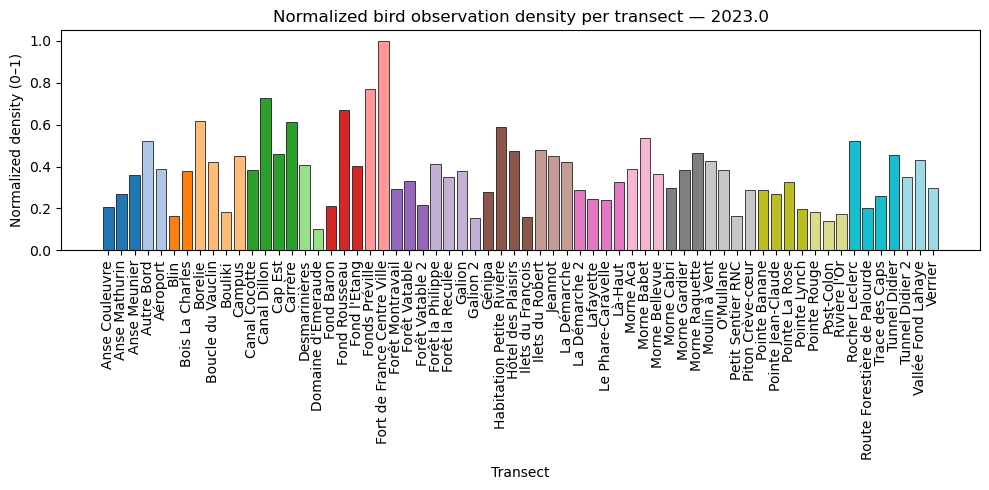

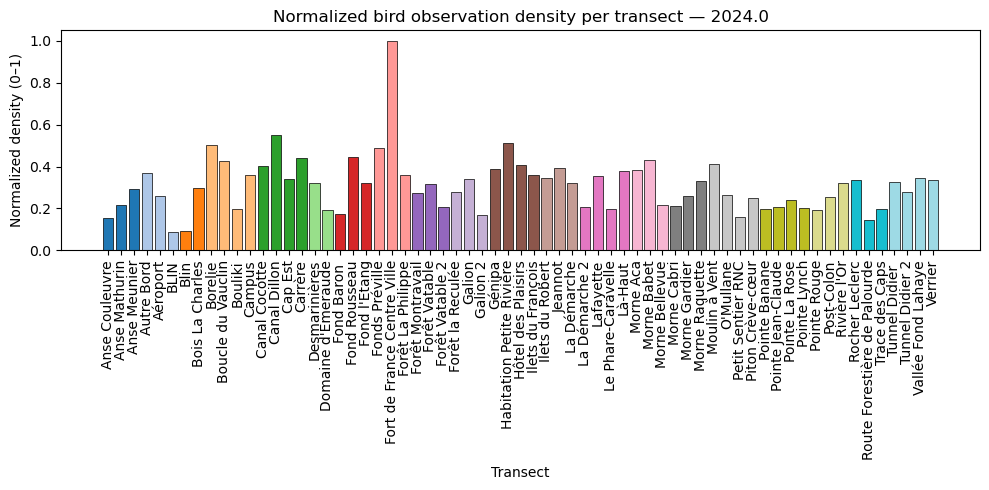

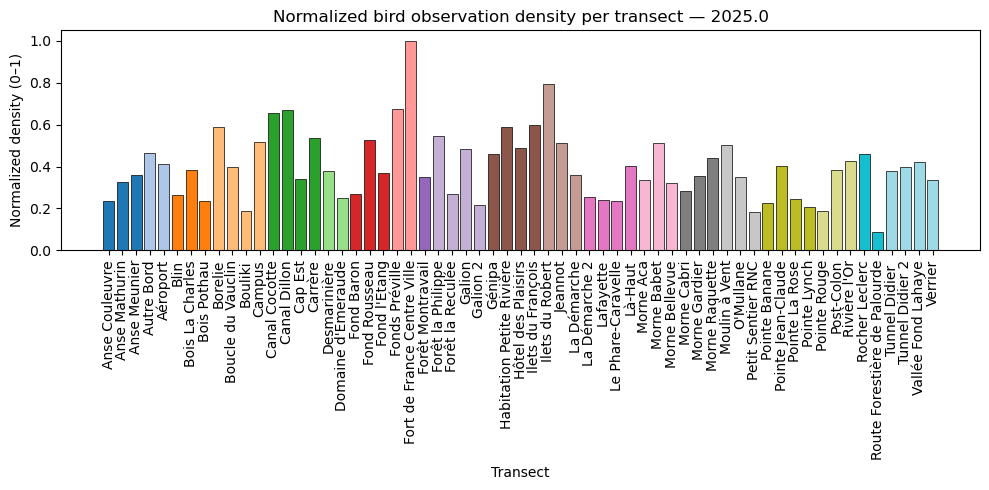

In [30]:
df = df_clean_nom_francais.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# --- Compute total birds per transect per year ---
transect_year_counts = (
    df.groupby(["year", "Nom transect"])["TOT_AV_sV"]
      .sum()
      .reset_index()
      .rename(columns={"TOT_AV_sV": "Bird_count"})
)

# --- Normalize counts per year ---
transect_year_counts["Normalized_density"] = transect_year_counts.groupby("year")["Bird_count"].transform(
    lambda x: x / x.max()
)
# --- color ---
transects = sorted(transect_year_counts["Nom transect"].unique())
colors = plt.cm.tab20(np.linspace(0, 1, len(transects)))  # up to 20 distinct colors
color_map = dict(zip(transects, colors))

# --- Plot normalized density distributions per year ---
years = sorted(transect_year_counts["year"].dropna().unique())

for yr in years:
    subset = transect_year_counts[transect_year_counts["year"] == yr]
    plt.figure(figsize=(10, 5))
    for _, row in subset.iterrows():
        plt.bar(
            row["Nom transect"], 
            row["Normalized_density"], 
            color=color_map[row["Nom transect"]],
            edgecolor="black",
            linewidth=0.5
        )
    plt.title(f"Normalized bird observation density per transect — {yr}")
    plt.xlabel("Transect")
    plt.ylabel("Normalized density (0–1)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

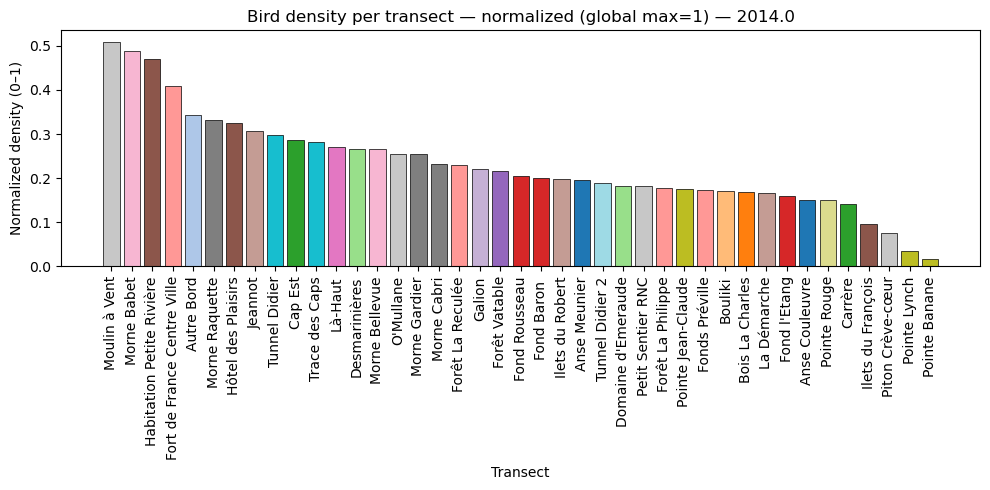

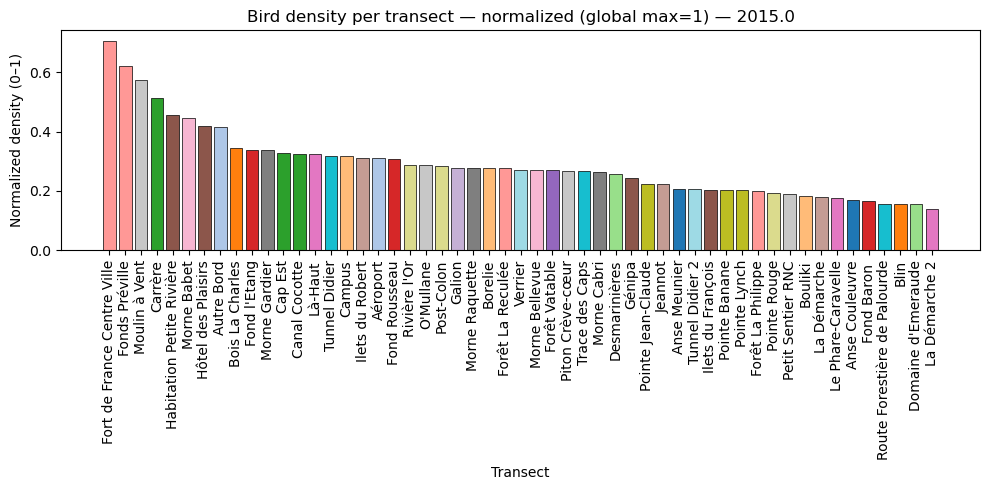

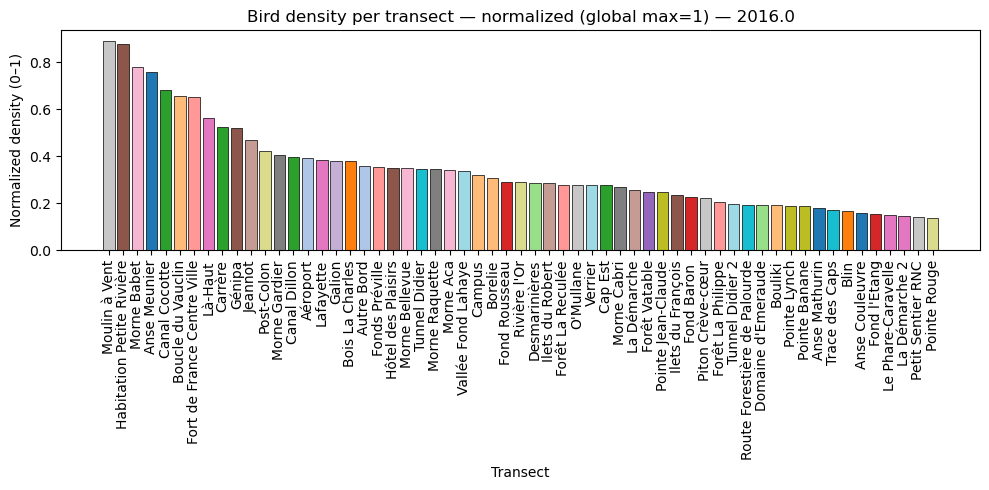

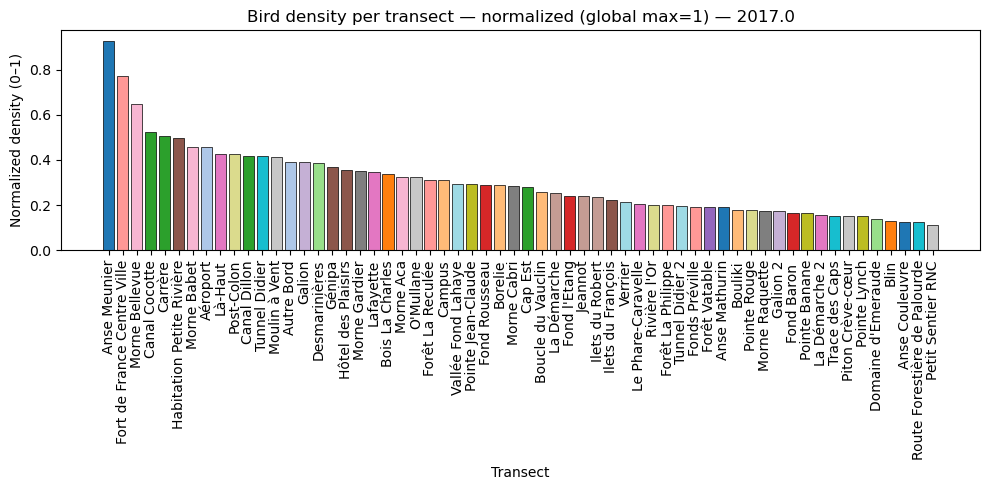

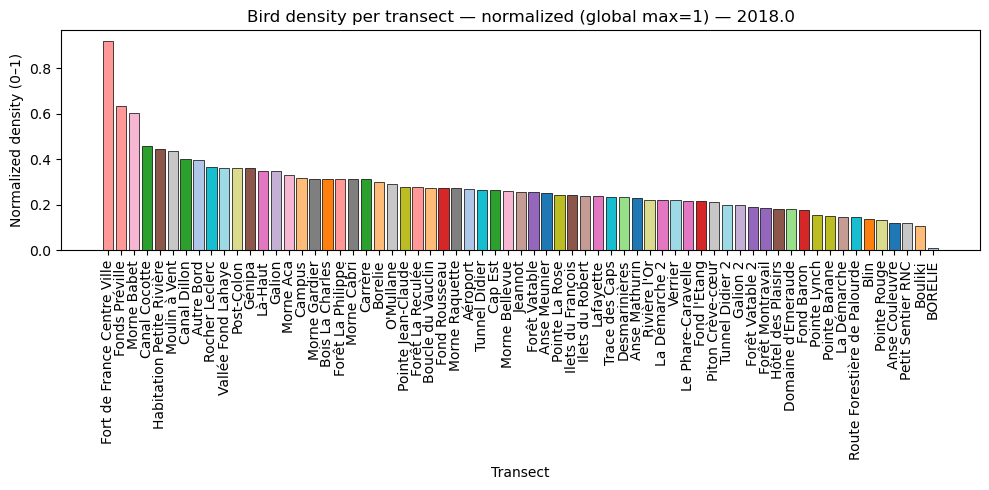

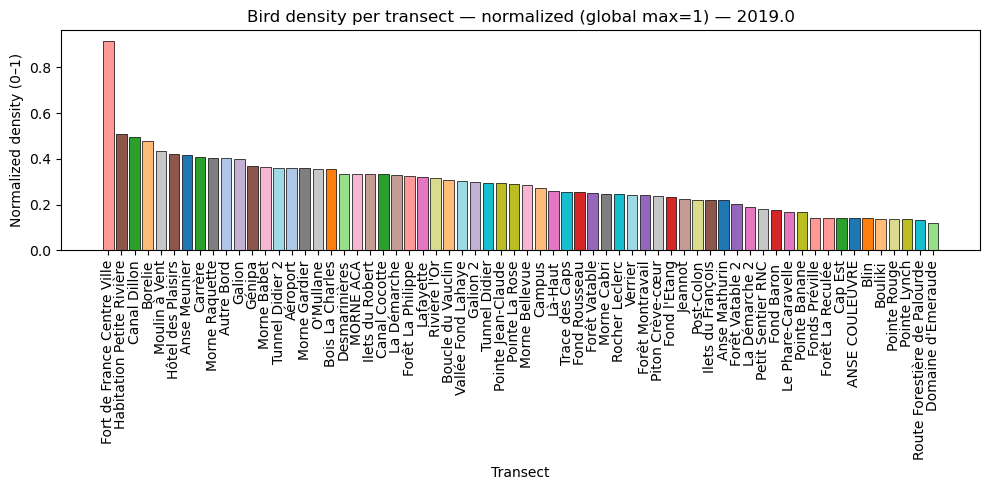

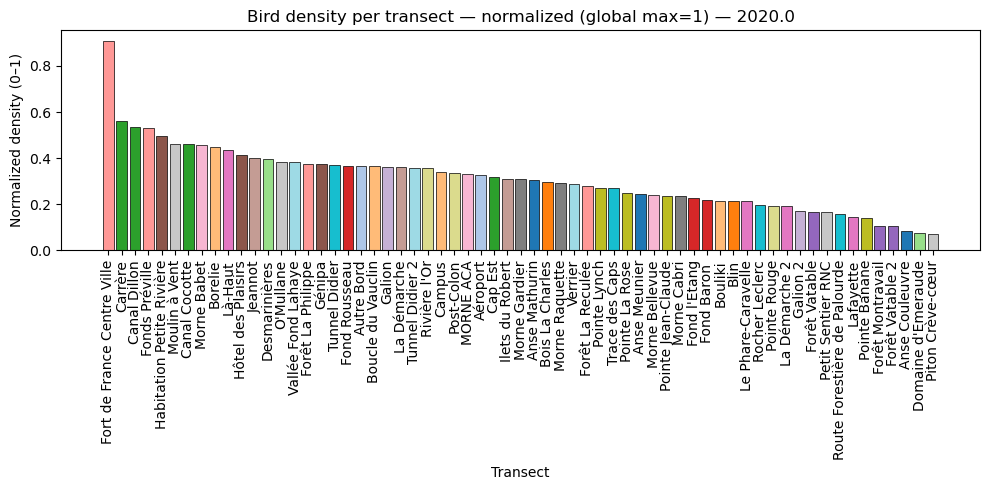

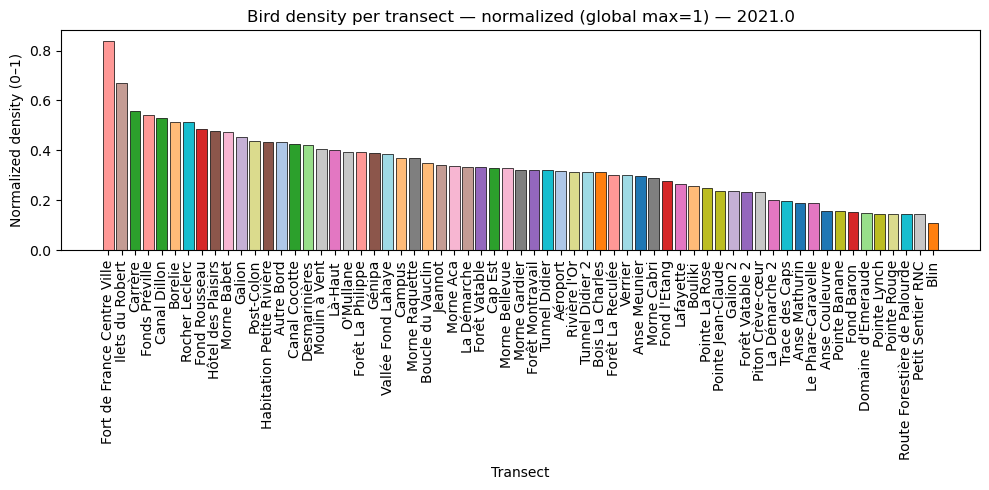

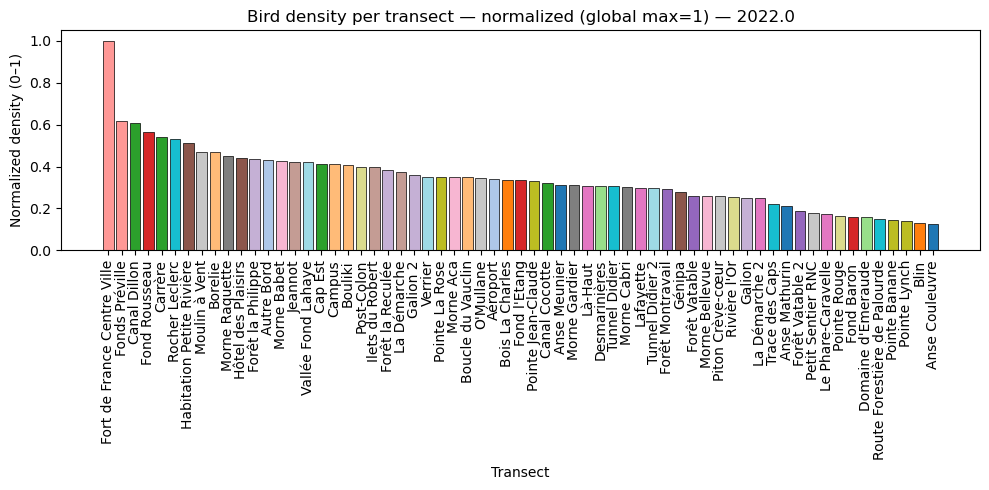

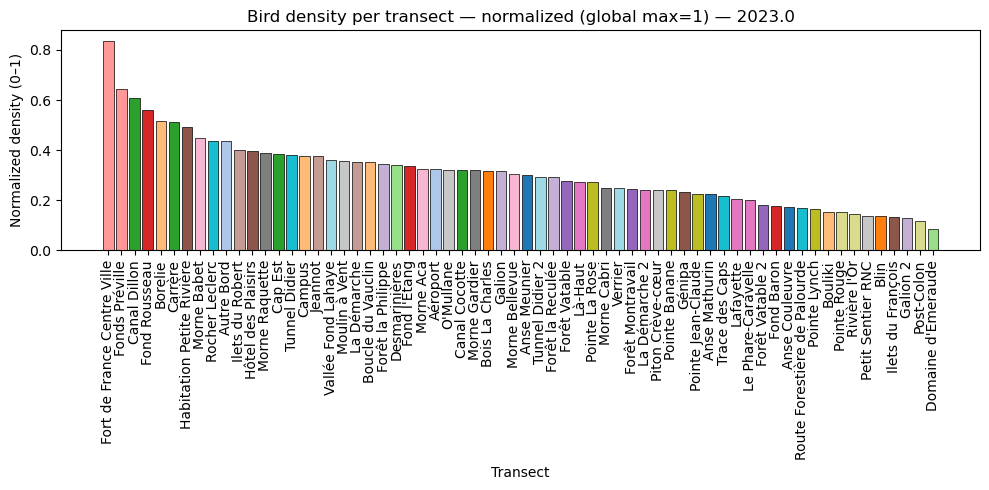

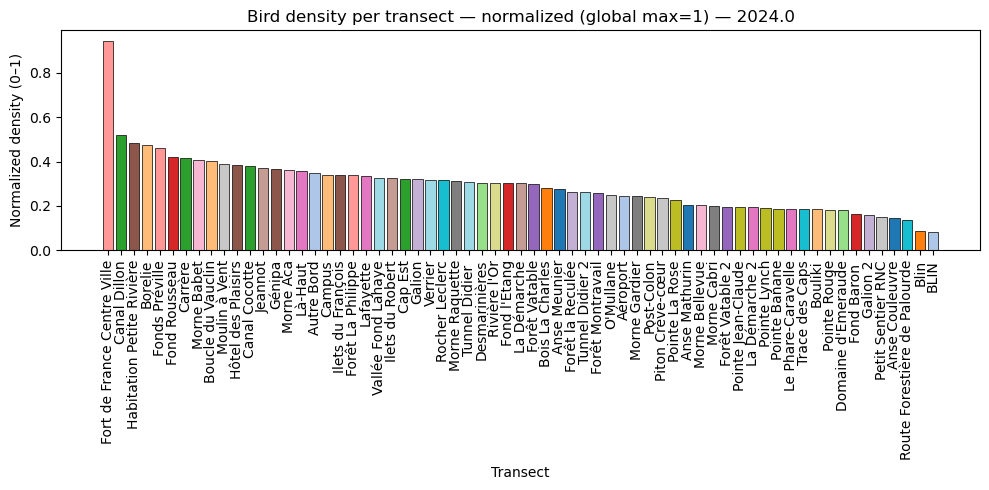

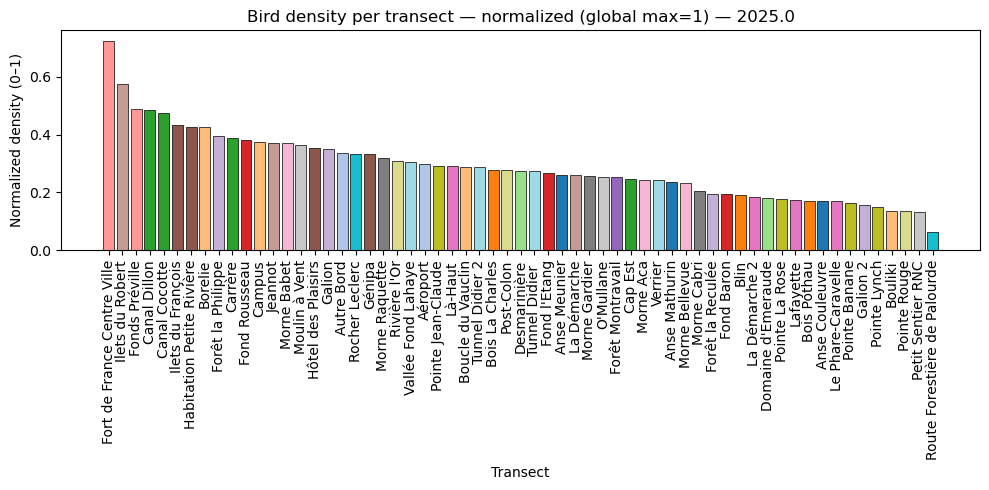

In [31]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# --- Compute total birds per transect per year ---
transect_year_counts = (
    df.groupby(["year", "Nom transect"])["TOT_AV_sV"]
      .sum()
      .reset_index()
      .rename(columns={"TOT_AV_sV": "Bird_count"})
)

# --- Normalize globally (using the all-time maximum count) ---
global_max = transect_year_counts["Bird_count"].max()
transect_year_counts["Normalized_density"] = transect_year_counts["Bird_count"] / global_max

# --- Assign a consistent color per transect ---
transects = sorted(transect_year_counts["Nom transect"].unique())
colors = plt.cm.tab20(np.linspace(0, 1, len(transects)))  # up to 20 distinct colors
color_map = dict(zip(transects, colors))

# --- Plot evolution by year ---
years = sorted(transect_year_counts["year"].dropna().unique())

for yr in years:
    subset = transect_year_counts[transect_year_counts["year"] == yr].sort_values("Normalized_density", ascending=False)
    
    plt.figure(figsize=(10, 5))
    for _, row in subset.iterrows():
        plt.bar(
            row["Nom transect"], 
            row["Normalized_density"], 
            color=color_map[row["Nom transect"]],
            edgecolor="black",
            linewidth=0.5
        )
    
    plt.title(f"Bird density per transect — normalized (global max=1) — {yr}")
    plt.xlabel("Transect")
    plt.ylabel("Normalized density (0–1)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

#### Density bootstrap 


year      mean    ci_low   ci_high
0   2014.0  1.992004  1.938248  2.043901
1   2015.0  2.121906  2.059177  2.173000
2   2016.0  2.078649  2.039597  2.115621
3   2017.0  2.223559  2.175336  2.274285
4   2018.0  2.088256  2.028149  2.140142
5   2019.0  2.194421  2.143946  2.244468
6   2020.0  2.208317  2.148551  2.263861
7   2021.0  2.255187  2.198121  2.315456
8   2022.0  2.259904  2.202886  2.311748
9   2023.0  2.178110  2.125871  2.226269
10  2024.0  2.148144  2.095508  2.196204
11  2025.0  2.145910  2.053308  2.218549

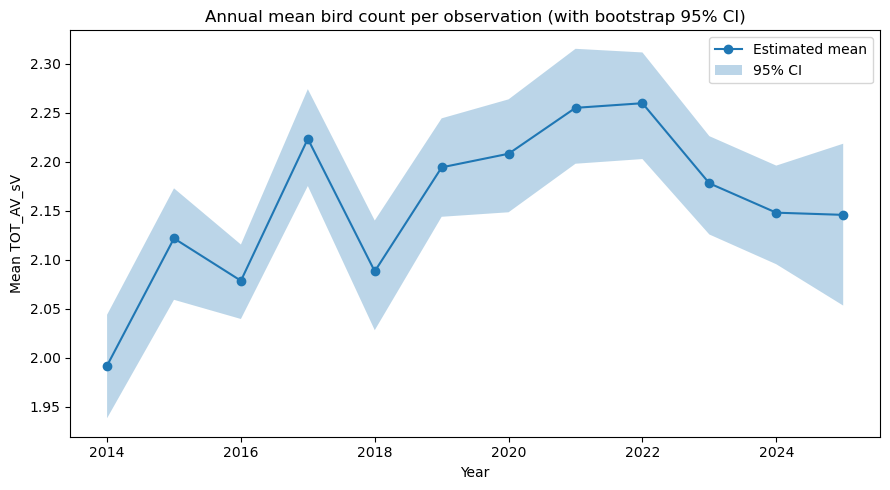

In [32]:
# --- Parameters ---
B = 1000  # number of bootstrap samples
alpha = 0.05  # for 95% CI

# --- Helper: bootstrap function ---
def bootstrap_ci(data, func=np.mean, B=1000, alpha=0.05):
    """
    Compute bootstrap confidence interval for a given statistic (func).
    """
    n = len(data)
    if n == 0:
        return np.nan, np.nan, np.nan  # handle empty groups
    
    # Original estimate
    theta_hat = func(data)
    
    # Bootstrap resamples
    boot_estimates = []
    for _ in range(B):
        sample = np.random.choice(data, size=n, replace=True)
        boot_estimates.append(func(sample))
    boot_estimates = np.array(boot_estimates)
    
    # Quantiles of bootstrap distribution
    q_low = np.quantile(boot_estimates, alpha / 2)
    q_high = np.quantile(boot_estimates, 1 - alpha / 2)
    
    # Reflected confidence interval (percentile method)
    ci_low = 2 * theta_hat - q_high
    ci_high = 2 * theta_hat - q_low
    
    return theta_hat, ci_low, ci_high

# --- Apply bootstrap per year ---
bootstrap_results = []
for year, group in df.groupby("year"):
    theta_hat, ci_low, ci_high = bootstrap_ci(group["TOT_AV_sV"].values, func=np.mean, B=B, alpha=alpha)
    bootstrap_results.append({"year": year, "mean": theta_hat, "ci_low": ci_low, "ci_high": ci_high})

bootstrap_df = pd.DataFrame(bootstrap_results).sort_values("year")
display(bootstrap_df)

# --- Plot results ---
plt.figure(figsize=(9, 5))
plt.plot(bootstrap_df["year"], bootstrap_df["mean"], marker="o", label="Estimated mean")
plt.fill_between(bootstrap_df["year"], bootstrap_df["ci_low"], bootstrap_df["ci_high"], alpha=0.3, label="95% CI")
plt.title("Annual mean bird count per observation (with bootstrap 95% CI)")
plt.xlabel("Year")
plt.ylabel("Mean TOT_AV_sV")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# --- Compute bootstrap estimates per transect-year ---
bootstrap_results = []
for (year, transect), group in df.groupby(["year", "Nom transect"]):
    theta_hat, ci_low, ci_high = bootstrap_ci(group["TOT_AV_sV"].values, func=np.sum, B=1000, alpha=0.05)
    bootstrap_results.append({
        "year": year,
        "transect": transect,
        "total_birds": theta_hat,
        "ci_low": ci_low,
        "ci_high": ci_high
    })

bootstrap_df = pd.DataFrame(bootstrap_results)

# --- Normalize by global maximum total (for comparable densities) ---
global_max = bootstrap_df["total_birds"].max()
bootstrap_df["density_norm"] = bootstrap_df["total_birds"] / global_max
bootstrap_df["ci_low_norm"] = bootstrap_df["ci_low"] / global_max
bootstrap_df["ci_high_norm"] = bootstrap_df["ci_high"] / global_max

display(bootstrap_df.head())

year         transect  total_birds   ci_low  ci_high  density_norm  \
0  2014.0   Anse Couleuvre          171  146.975  191.000      0.151327   
1  2014.0     Anse Meunier          221  186.975  251.025      0.195575   
2  2014.0       Autre Bord          389  337.000  432.000      0.344248   
3  2014.0  Bois La Charles          191  174.000  207.000      0.169027   
4  2014.0          Bouliki          194  153.975  223.000      0.171681   

   ci_low_norm  ci_high_norm  
0     0.130066      0.169027  
1     0.165465      0.222146  
2     0.298230      0.382301  
3     0.153982      0.183186  
4     0.136261      0.197345

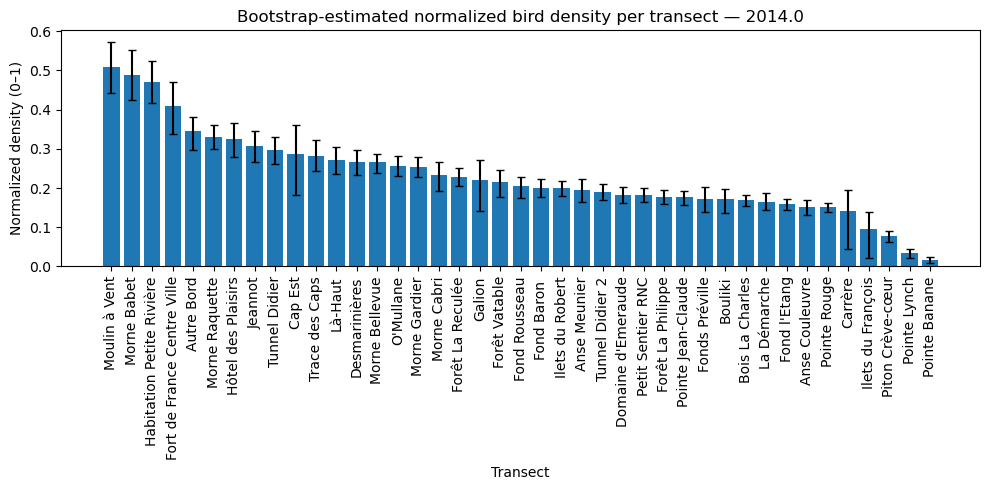

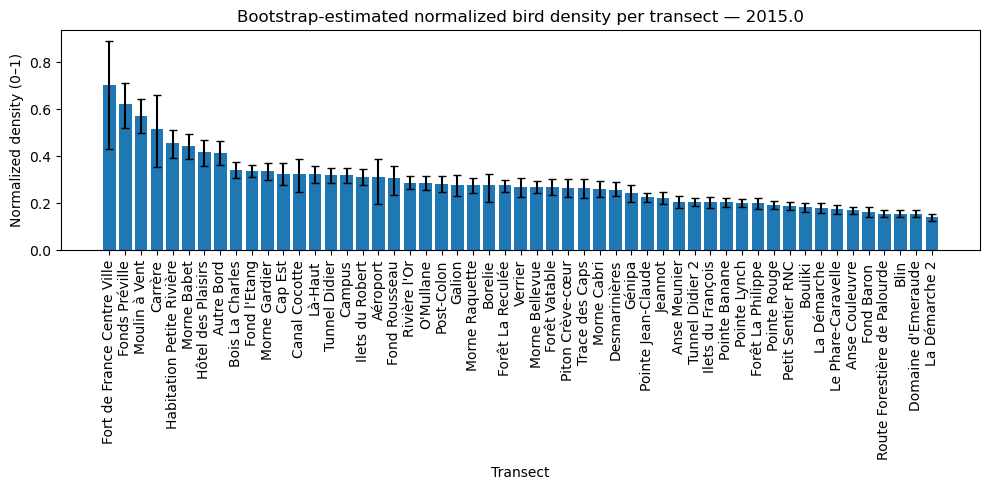

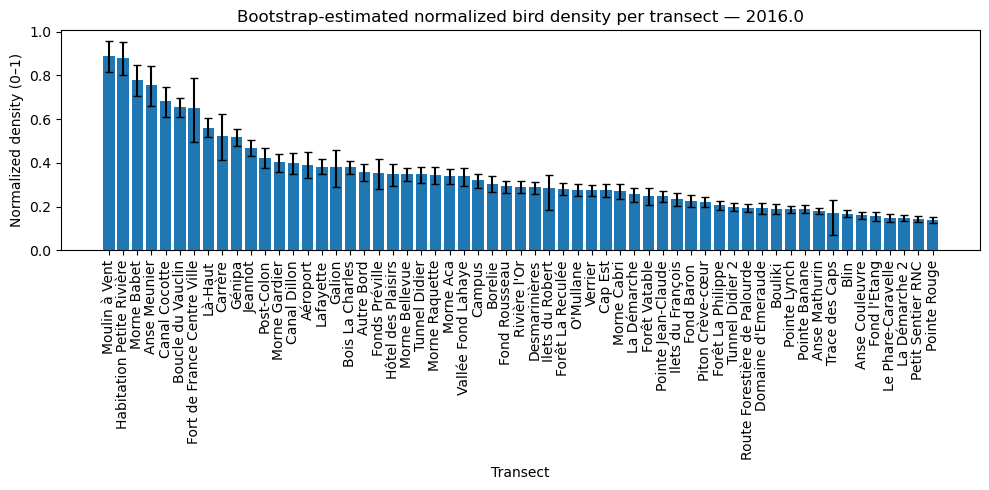

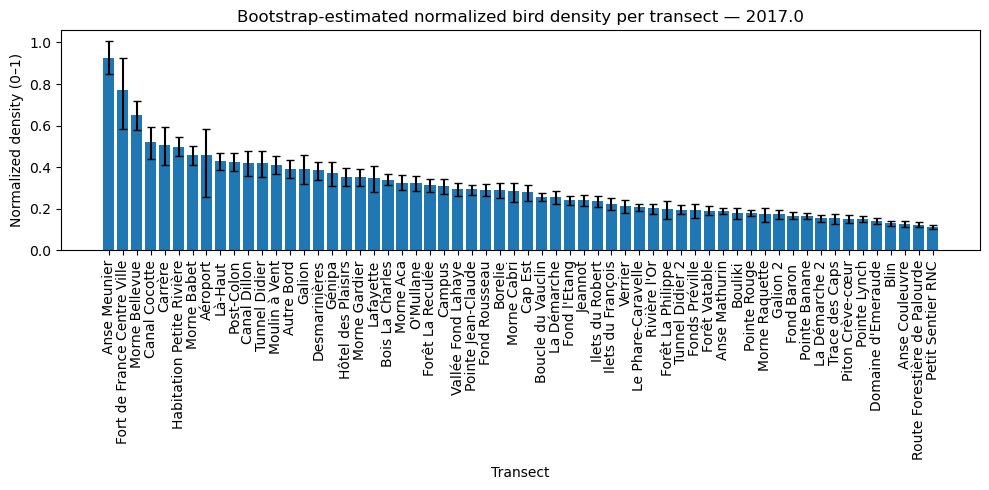

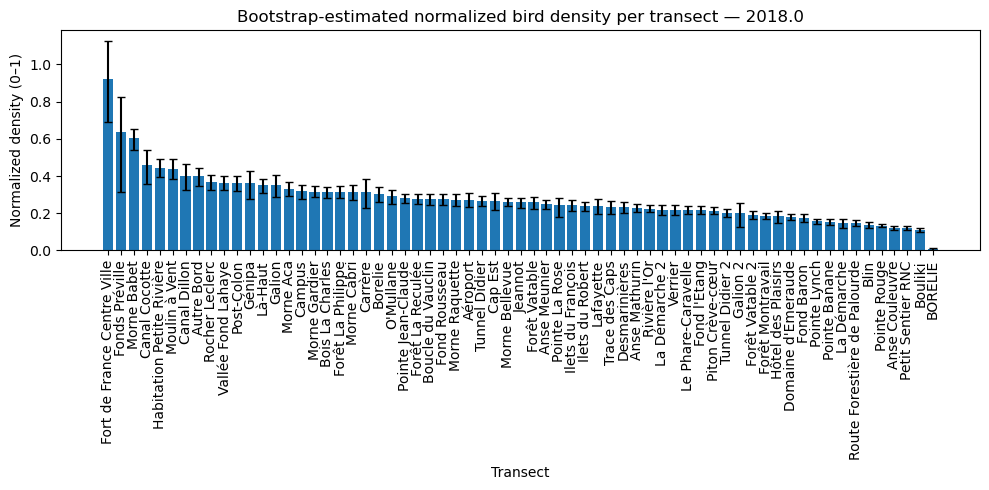

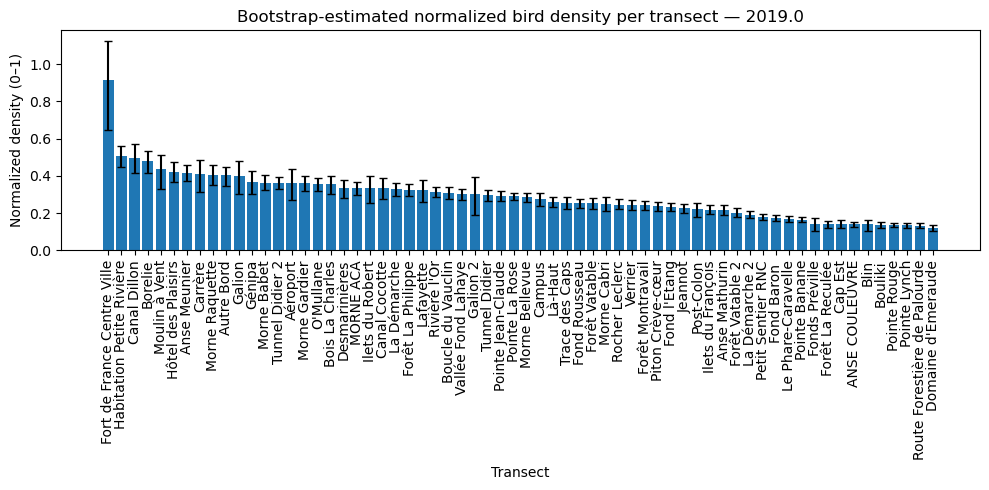

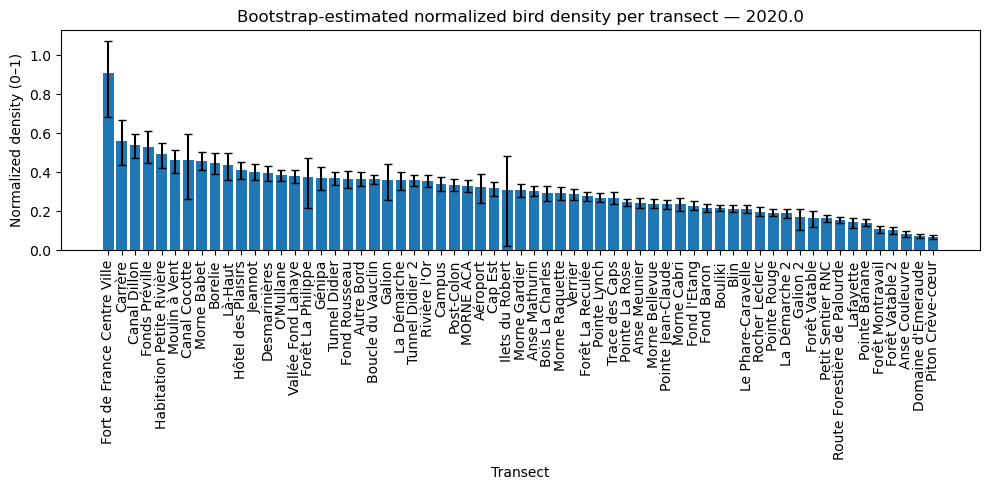

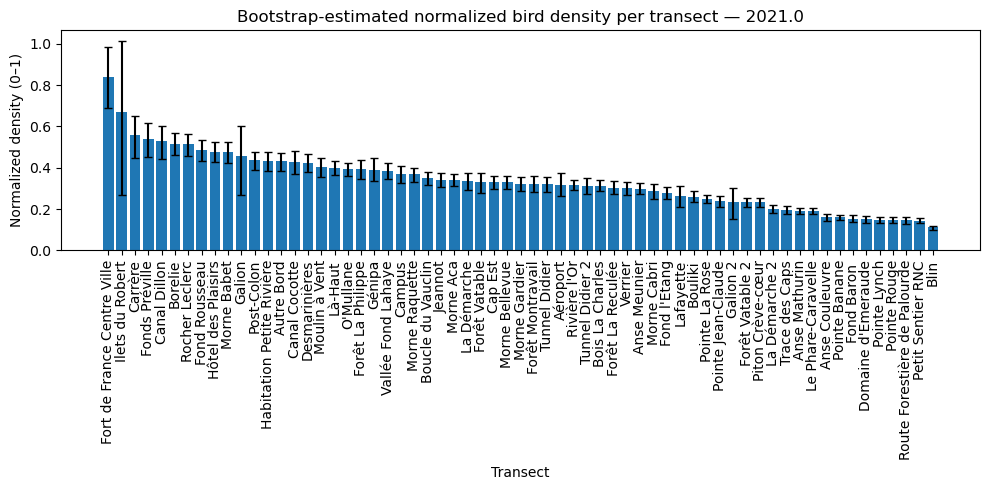

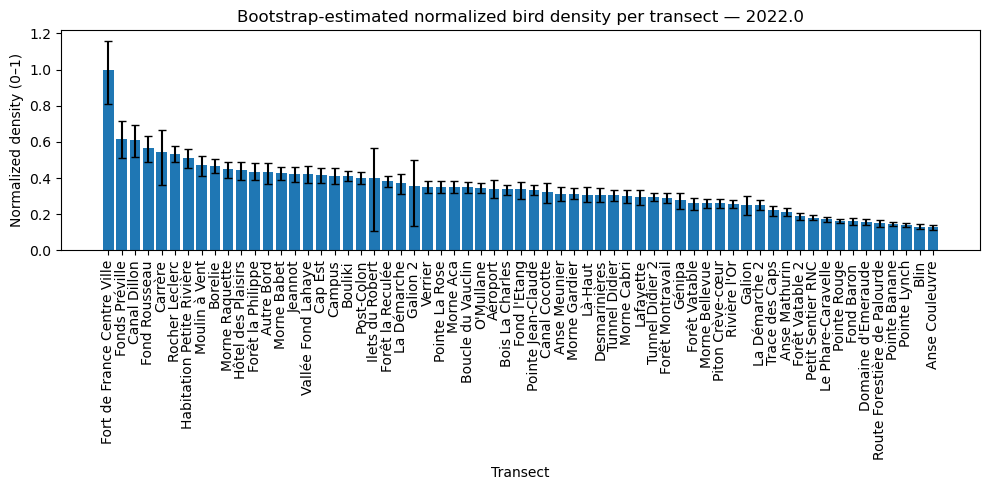

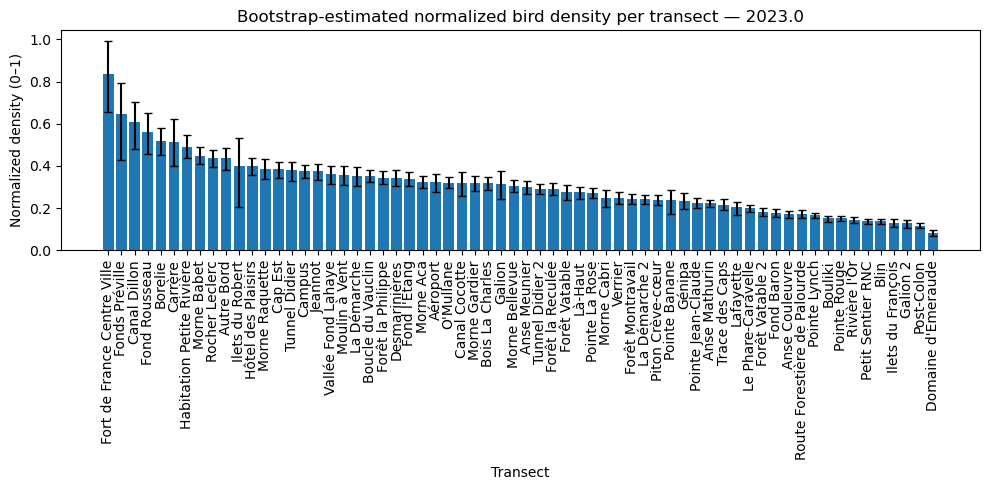

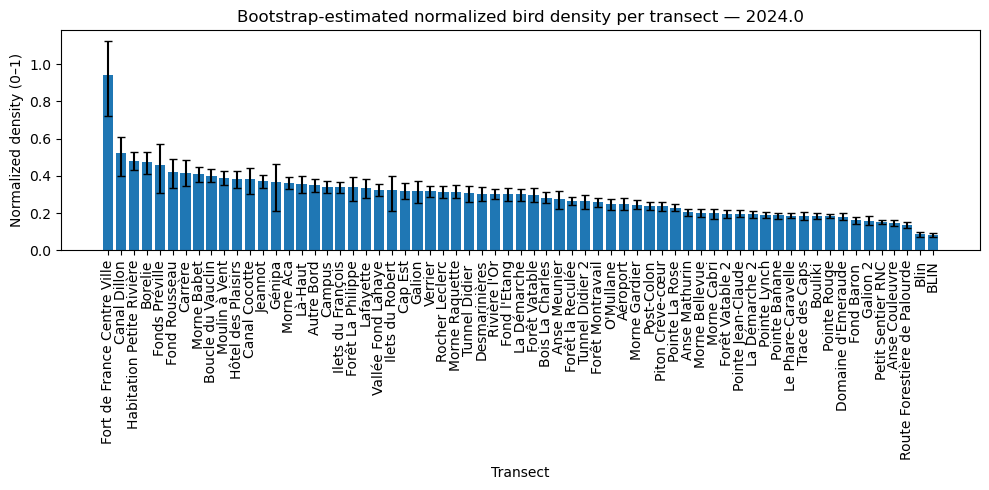

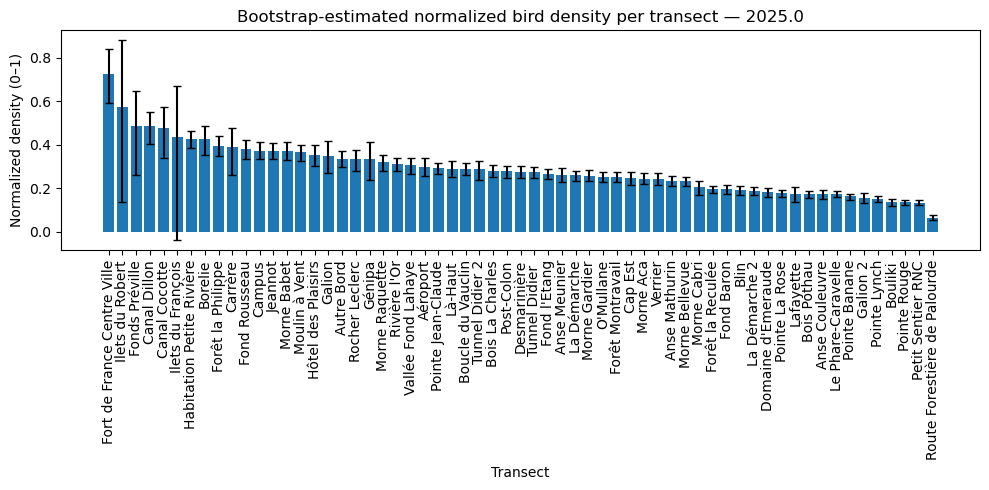

In [34]:

years = sorted(bootstrap_df["year"].unique())

for yr in years:
    subset = bootstrap_df[bootstrap_df["year"] == yr].sort_values("density_norm", ascending=False)
    
    plt.figure(figsize=(10, 5))
    plt.bar(
        subset["transect"],
        subset["density_norm"],
        yerr=[subset["density_norm"] - subset["ci_low_norm"], subset["ci_high_norm"] - subset["density_norm"]],
        capsize=3
    )
    plt.title(f"Bootstrap-estimated normalized bird density per transect — {yr}")
    plt.xlabel("Transect")
    plt.ylabel("Normalized density (0–1)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Top 5 transects with highest mean normalized density:
['Fort de France Centre Ville', 'Habitation Petite Rivière', 'Canal Dillon', 'Morne Babet', 'Moulin à Vent']


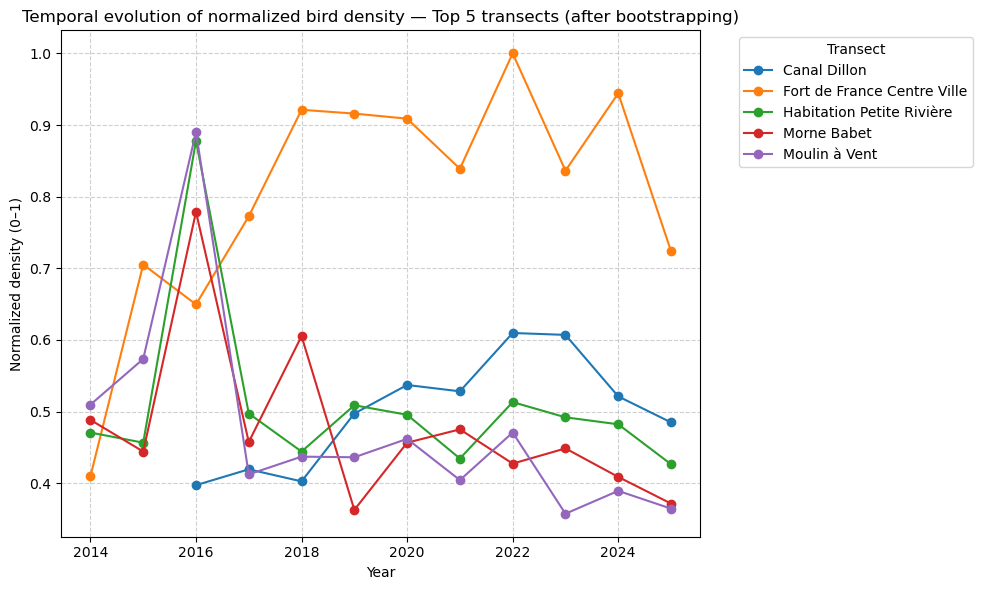

In [35]:
# --- Identify top 5 transects by mean normalized density across all years ---
top_transects = (
    bootstrap_df.groupby("transect")["density_norm"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index
)

print("Top 5 transects with highest mean normalized density:")
print(top_transects.tolist())

# --- Filter data for only those transects ---
top_df = bootstrap_df[bootstrap_df["transect"].isin(top_transects)]

# --- Plot temporal evolution for top 5 transects ---
plt.figure(figsize=(10, 6))
for transect, group in top_df.groupby("transect"):
    plt.plot(group["year"], group["density_norm"], marker="o", label=transect)

plt.title("Temporal evolution of normalized bird density — Top 5 transects (after bootstrapping)")
plt.xlabel("Year")
plt.ylabel("Normalized density (0–1)")
plt.legend(title="Transect", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Summary of Density indicator (what we did)

## 🪶 Density Indicator — Summary of Computations

### 1. Definition
The density indicator measures the relative abundance of birds observed per transect and year.



### 2. Computation Steps

**(a) Counting per Transect and Year**  
From the cleaned observation dataset (`nom_francais_clean`), total bird counts were aggregated by `(year, transect)` using columns such as `TOT_A`, `TOT_V_sV`, etc.

**(b) Normalization**  
Each transect’s annual count was normalized by the maximum count observed across all years:

$$
\text{density\_norm}_{i,t} = \frac{\text{count}_{i,t}}{\max(\text{count}_{\text{all years}})}
$$

Densities are thus scaled to the range [0, 1].



### 3. Bootstrap Estimation

A bootstrap resampling method was used to estimate uncertainty:

1. For each year, resample transects with replacement \( B \) times (e.g. \( B = 1000 \)).
2. Compute the mean normalized density for each resample.
3. Obtain 95% confidence intervals from the empirical quantiles of the bootstrap distribution.

$$
\text{CI}_{95\%} = [\hat{\theta}^*_{2.5\%}, \hat{\theta}^*_{97.5\%}]
$$



### 4. Derived Indicators and Visualization

- Annual mean normalized density computed and plotted over time.  
- Per-year density distribution visualized by transect (color-coded).  
- Temporal evolution of normalized densities visualized across transects.  
- Bootstrap mean and confidence intervals plotted for density trends.


### 5. Diversity Indices Applied to Density

**Shannon Diversity Index**
$$
H' = -\sum_i p_i \ln(p_i)
$$

**Simpson Diversity Index**
$$
D = 1 - \sum_i p_i^2
$$

Both indices computed from the normalized density distribution across transects:
- Calculated per year on raw and bootstrapped densities.
- Confidence intervals estimated via bootstrap resampling.
- Temporal evolution of both indices visualized.
- Additional plots generated for the top 5 transects with highest mean density.




### Detectability Study (auditory vs visual)

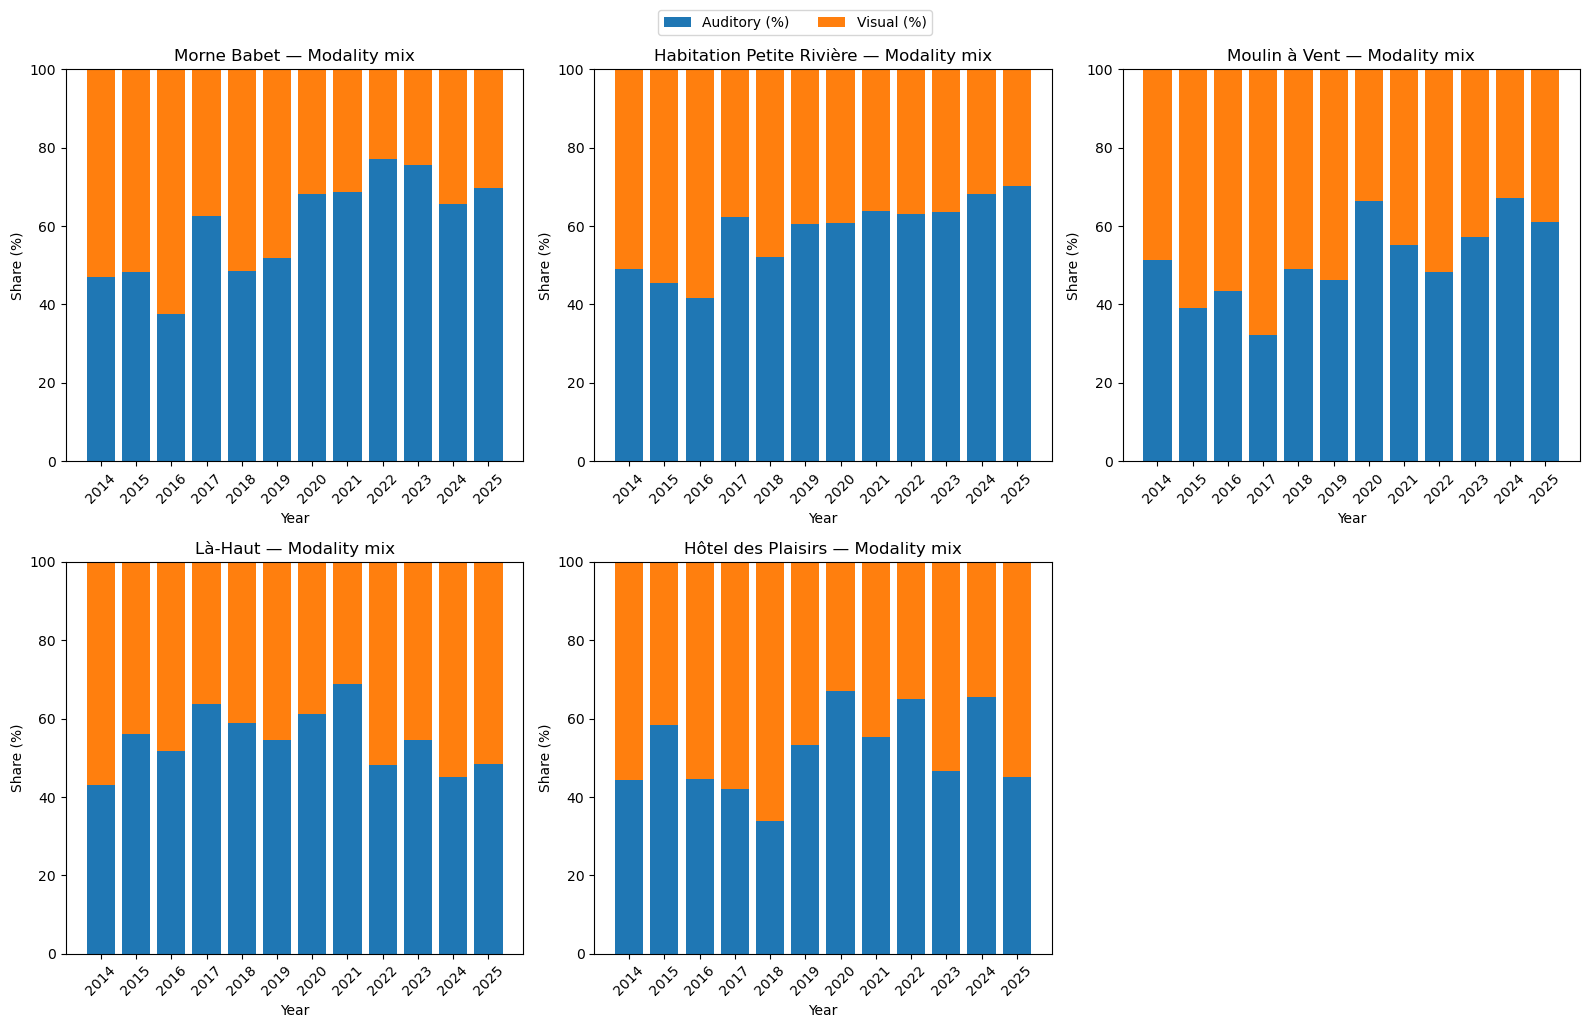

In [36]:
TOP_N = 5  # number of transects we analyze (ordered by most visited)


df_det = df_clean_nom_francais.copy()
df_det["date"] = pd.to_datetime(df_det["date"], errors="coerce")
df_det["year"] = pd.to_numeric(df_det["date"].dt.year, errors="coerce")
df_det["N° passage"] = pd.to_numeric(df_det["N° passage"], errors="coerce")


df_det = df_det.dropna(subset=["Nom transect", "year"])


ranking = df_det.groupby("Nom transect").size().sort_values(ascending=False)
top_transects = ranking.head(TOP_N).index.tolist() 
df_det_top = df_det[df_det["Nom transect"].isin(top_transects)]

# -------- AGGREGATE & SHARES --------
agg = (df_det_top.groupby(["Nom transect", "year"], dropna=False)
              .agg(A_sum=("TOT_A","sum"), V_sum=("TOT_V_sV","sum"))
              .reset_index())
total = (agg["A_sum"] + agg["V_sum"])
agg["Auditory_pct"] = 100 * agg["A_sum"] / total
agg["Visual_pct"]   = 100 - agg["Auditory_pct"]

# Plot the histogram
n = len(top_transects)
ncols = min(3, n)
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), squeeze=False)

for i, tr in enumerate(top_transects):
    ax = axes[i // ncols, i % ncols]
    sub = agg[agg["Nom transect"] == tr].sort_values("year")
    years = sub["year"].astype(int).tolist()
    a = sub["Auditory_pct"].values
    v = sub["Visual_pct"].values

    ax.bar(years, a, label="Auditory (%)")
    ax.bar(years, v, bottom=a, label="Visual (%)")
    ax.set_title(f"{tr} — Modality mix")
    ax.set_xlabel("Year"); ax.set_ylabel("Share (%)")
    ax.set_ylim(0, 100)
    ax.set_xticks(years); ax.set_xticklabels(years, rotation=45)

# Hide empty axes
for j in range(i+1, nrows*ncols):
    axes[j // ncols, j % ncols].axis("off")

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.03))
fig.tight_layout()
plt.show()


Observing the graphs for each of the top five most visited transects, we can see that for some of them `(Morne Babet, Habitation Petit Riviere, Moulin a vent)`, there seems to be an increase in the share of auditory observations of bird. 

In order to test our hypothesis if there are trends in some of these transects, we are going to present an initial hypothesis $H_0$: $\beta_1 = 0$, with $\beta_1$ being the slope on each year 

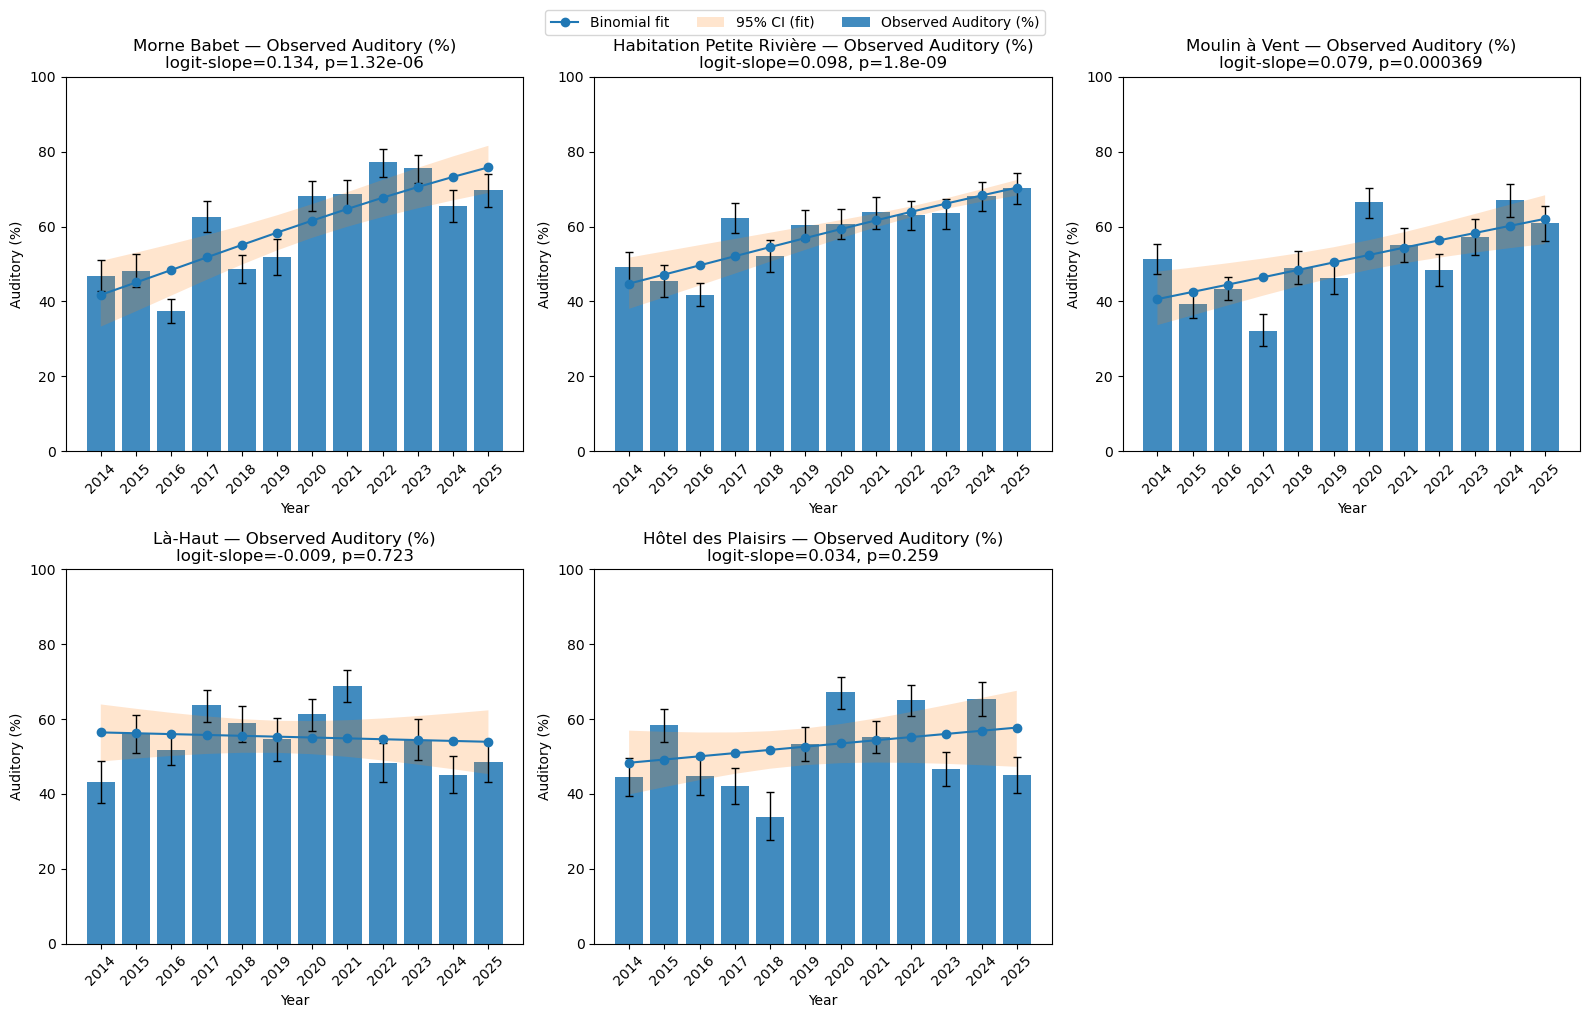

In [37]:
agg["AV_total"] = (agg["A_sum"] + agg["V_sum"]).astype(float)



ci_low, ci_high = proportion_confint(
    count=agg["A_sum"].astype(float),
    nobs=agg["AV_total"].astype(float),
    alpha=0.05,
    method="wilson"
)
agg["Auditory_pct_low"]  = 100 * ci_low
agg["Auditory_pct_high"] = 100 * ci_high


# We fit a binomial GLM for the % auditory ~ year (per transect)
def fit_binom_glm(sub_df):
    """sub_df has columns: year, A_sum, V_sum, AV_total (>0 rows). Returns pred df + slope, pval."""
    df = sub_df.sort_values("year").copy()

    df["year_c"] = df["year"] - df["year"].mean()  
    y = (df["A_sum"] / df["AV_total"]).values
    X = sm.add_constant(df[["year_c"]])
    model = sm.GLM(y, X, family=sm.families.Binomial(), var_weights=df["AV_total"].values)
    res = model.fit(cov_type="HC1")

    pred = res.get_prediction(X)
    ci = pred.conf_int(alpha=0.05)
    df["pred"]   = pred.predicted_mean
    df["ci_low"] = ci[:, 0]
    df["ci_high"]= ci[:, 1]

    slope = float(res.params.get("year_c"))  
    pval  = float(res.pvalues.get("year_c"))
    return df, slope, pval

# We plot the observed auditory (%) bars with Wilson CIs and GLM fit
transects = top_transects
n = len(transects)
ncols = min(3, n)
nrows = int(np.ceil(n / ncols)) if n else 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), squeeze=False)
axes = axes.flatten() if nrows*ncols > 1 else [axes]

for i, tr in enumerate(transects):
    ax = axes[i]
    sub = agg[agg["Nom transect"] == tr].sort_values("year").copy()
    years = sub["year"].astype(int).to_numpy()
    y_bar = sub["Auditory_pct"].to_numpy()

    # Bars: observed auditory %
    ax.bar(years, y_bar, label="Observed Auditory (%)", alpha=0.85)

    # Wilson error bars (only where defined)
    y_low  = sub["Auditory_pct_low"].to_numpy()
    y_high = sub["Auditory_pct_high"].to_numpy()
    yerr = np.vstack([y_bar - y_low, y_high - y_bar])
    ax.errorbar(years, y_bar, yerr=yerr, fmt="none", capsize=3, linewidth=1, ecolor="black")

    # GLM fit line + 95% CI band
    fit_df, slope, pval = fit_binom_glm(sub)
    ax.plot(fit_df["year"].astype(int), fit_df["pred"]*100, marker="o",
                linestyle="-", linewidth=1.5, label="Binomial fit")
    ax.fill_between(fit_df["year"].astype(int),
                    fit_df["ci_low"]*100, fit_df["ci_high"]*100,
                    alpha=0.20, label="95% CI (fit)")

    ax.set_title(f"{tr} — Observed Auditory (%)\nlogit-slope={slope:.3f}, p={pval:.3g}")
    ax.set_xlabel("Year"); ax.set_ylabel("Auditory (%)")
    ax.set_ylim(0, 100)
    ax.set_xticks(years); ax.set_xticklabels(years, rotation=45)

# Hide unused subplots 
for j in range(i + 1, nrows * ncols):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))

fig.tight_layout()
plt.show()

# Conclusion

After tracing these figures, with their corresponding CIs, p_values and slopes, we can see that for: 
1. Morne Babet: The p_value is much smaller than 0.05. We can say that the trend is highly significant, and that there is a strong and steady increase in the proportion of auditory detections over time.
2. Habitation Petit Rivière: Same as Morne Babet
3. Moulin à Vent: The p_value is smaller than 0.05. We can say that the trend is signicant, and that there is more variability across the years, but the fitted line still shows a positive slope.
4. Là-Haut: The p_value is much bigger than 0.05. We can say that the trend is not significant, and that the modality mix remains roughly constant over time.
5. Hôtel des Plaisirs: the p_value is bigger than 0.05. We can say that the trend is not significant, and although the slope is slightly upward, the uncertainty is large, so there isn't any statistically significant trend in auditory share.


# Summary of Modality-Mix Indicator (Auditory vs Visual)

## 1. Definition
The modality-mix indicator measures, for each transect and year, the share of detections that were auditory and visual:

$$
\frac{A_{y,t}}{A_{y,t} + V_{y,t}}
$$

where $A_{y,t}=\text{auditory detections}$ and $V_{y, t} = \text{visual detections}$ for each year $y$ at transect $t$.

## 2. Computation Steps

**(a) Counting per Transect and Year**

From the cleaned observation dataset `(nom_francais_clean)`, total audio/visual bird counts were aggregated by `(year, transect)` adding columns `TOT_A` and `TOT_V_sV`.

**(b) Observed shares**

To calculate the percentage of observed audio shares, we do:
$$
\widehat{p}_{y,t}=\frac{TOT\_A}{AV\_total},\qquad \text{Auditory\%}=100\times \widehat{p}_{y,t}
$$

## 3. Confidence Intervals for Observed Shares (Wilson method)

We use the Wilson method, because classic "Wald" Confidence Intervalls perform poorly with small $n$ or extreme $p$ (bounds can leave [0, 1]) 
Instea, Wilson score intervals have better coverage and stay in [0, 1], which matters because if we increase the number of transects, the $\text{year} \times \text{transect}$ might have modest totals.

Formula for $95\%$ CI:

Let $z = 1.96$, $n = \text{AV\_total}$, $\widehat{p} = \frac{\text{TOT\_A}}{n}$. Then

$$
\text{CI}_{\text{Wilson}} = \frac{\widehat{p} + \frac{z^2}{2n} \pm z\sqrt{\frac{\widehat{p}(1 - \widehat{p})}{n} + \frac{z^2}{4n^2}}}{1 + \frac{z^2}{n}}
$$

In the code, this is calculated by the imported function `statsmodels.stats.proportion.proportion_confint(method="wilson")`, then we multiply it by 100 to get the percentage.

## 4. Binomial Generalized Linear Model

We use a GLM because the share of auditory detections is a proportion, each value comes from a count of auditory detections out of a total number of detections, so it follows a binomial distribution. Also, a GLM with a binomial family and a logit link models how the probability of an auditory detection changes with time (year), while taking into account that the years with more detections provide more reliable estimates. 

Per each transect, we utilise the following model:

$$
\text{logit}(\text{Pr}[\text{auditory}|y,t]) = \beta_0 + \beta_1 (y - \widehat{y})
$$

With:
1. $\beta_0$: intercept
2. $\beta_1$: slope on year
3. $(y-\hat y)$: centered year

To calculate the p_value $p$ of each transect, we are going to do the following computations:

$$
z = \frac{\hat \beta_1}{\text{SE}(\hat \beta_1)d},\qquad p=2(1 - \phi(|z|))
$$

Where $\phi(\cdot)$ is the standard normal CDF.

### Spacial Coverage Study

  Nom observateur  code département  Nom transect                 date  \
0    BELFAN David             972.0  Fond l'Etang  2014-04-12 00:00:00   
1    BELFAN David             972.0  Fond l'Etang  2014-04-12 00:00:00   
2    BELFAN David             972.0  Fond l'Etang  2014-04-12 00:00:00   
3    BELFAN David             972.0  Fond l'Etang  2014-04-12 00:00:00   
4    BELFAN David             972.0  Fond l'Etang  2014-04-12 00:00:00   

   N° passage  nuages  pluie  vent  visibilité  N° point  ... AL100 VL100  \
0           1       2      1     1           1         1  ...     0     0   
1           1       2      1     1           1         1  ...     0     0   
2           1       2      1     1           1         1  ...     0     0   
3           1       2      1     1           1         1  ...     0     0   
4           1       2      1     1           1         1  ...     0     0   

   AG100  VG100  VOL  TOT_A  TOT_V_sV  TOT_AV_sV  TOT_AV_V  COMPANIED  
0      0      0    0

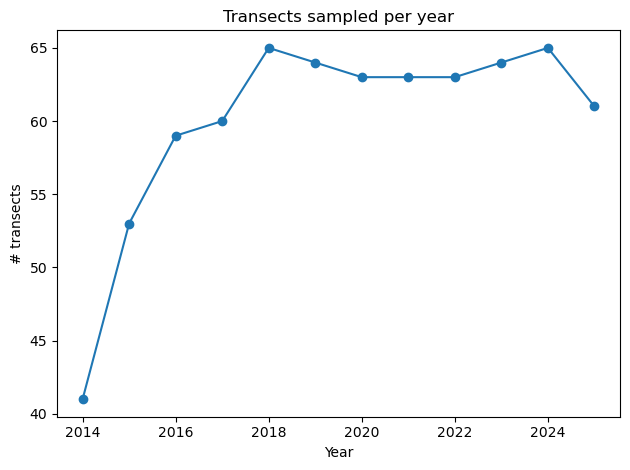

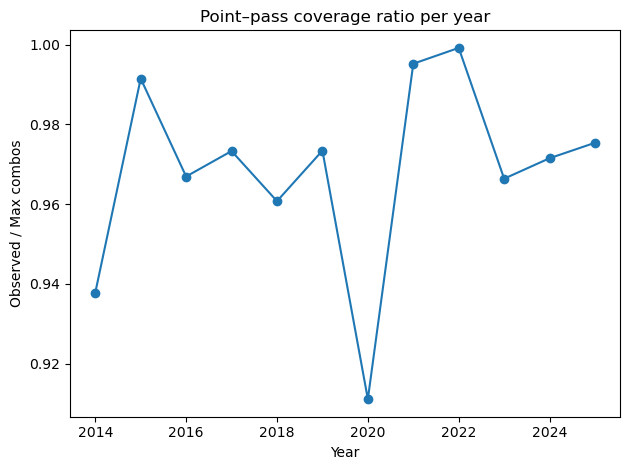

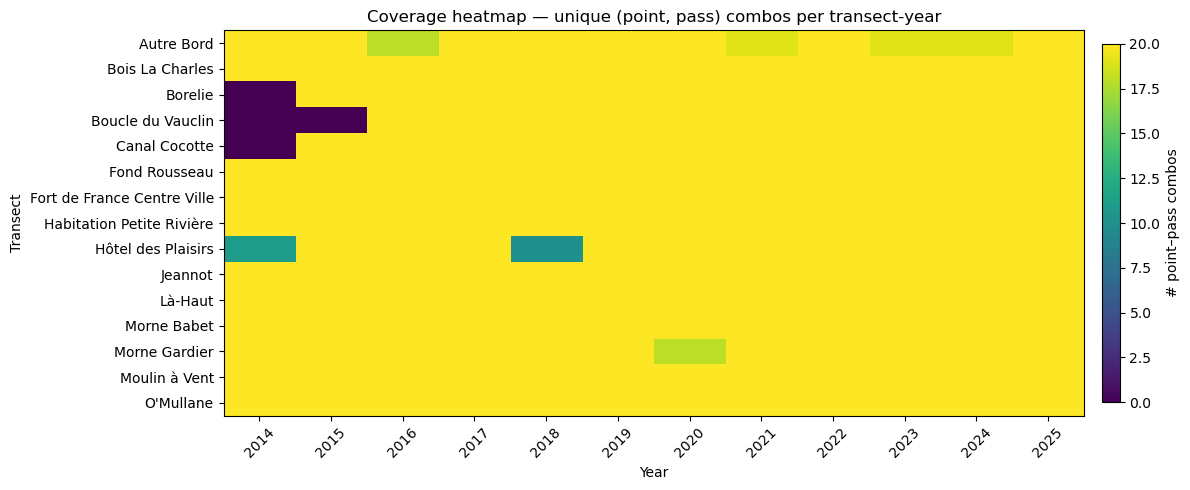

In [38]:
# We create a new table to analyse the spatial coverage
df_sp = df_clean_nom_francais.copy()

print(df_sp.head())

# Make sure date/year exist
df_sp["date"]  = pd.to_datetime(df_sp["date"], errors="coerce")
df_sp = df_sp.dropna(subset=["date"])
df_sp["year"] = df_sp["date"].dt.year

# We ensure all columns contain only numerical values
df_sp["point_n"] = pd.to_numeric(df_sp["N° point"], errors="coerce")
df_sp["N° passage"] = pd.to_numeric(df_sp["N° passage"], errors="coerce")
df_sp["TOT_AV_sV"] = pd.to_numeric(df_sp["TOT_AV_sV"], errors="coerce")

# We group the relevant indicators by year
yearly = (
    df_sp.groupby("year", dropna=True)
      .agg(transects=("Nom transect", "nunique"),
           observers=("Nom observateur", "nunique"),
           departments=("code département", "nunique"),
           point_visits=("Nom transect", "size"),
           richness=("ESPECE", "nunique"),
           total_counts=("TOT_AV_sV", "sum"))
      .reset_index()
      .sort_values("year")
)
yearly["birds_per_visit"] = yearly["total_counts"] / yearly["point_visits"]

# We'll use this to calculate the coverage ratio per year
# To do that we take divide the unique (transect, point, pass) by the maximum number of (transects * points * passes) there can be (= transects * 10 * 2)
df_sp["combo"] = list(zip(df_sp["Nom transect"], df_sp["point_n"], df_sp["N° passage"]))

cov_y = (df_sp.dropna(subset=["year"])
           .groupby("year")
           .agg(obs_combos=("combo", "nunique"),
                max_passes=("N° passage", "max")))
cov_y = cov_y.join(yearly.set_index("year")[["transects"]])
cov_y["max_combos"] = cov_y["transects"] * 10 * 2 
cov_y["combo_coverage"] = cov_y["obs_combos"] / cov_y["max_combos"]
yearly = yearly.merge(cov_y[["combo_coverage"]], left_on="year", right_index=True, how="left")


# Coverage heatmap data 
Top_transects = 15 # Number of top transects by visits that will appear in the heatmap

ded = (df_sp.dropna(subset=["point_n", "N° passage"])
         .drop_duplicates(subset=["Nom transect", "year", "point_n", "N° passage"]))
cov = (ded.groupby(["Nom transect", "year"])
           .size()
           .unstack(fill_value=0))
if not cov.empty:
    keep = df_sp["Nom transect"].value_counts().head(Top_transects).index
    cov = cov.loc[cov.index.intersection(keep)]


# A) Transects sampled per year
plt.figure()
plt.plot(yearly["year"], yearly["transects"], marker="o")
plt.title("Transects sampled per year")
plt.xlabel("Year"); plt.ylabel("# transects")
plt.tight_layout(); plt.show()


# B) Coverage ratio per year
plt.figure()
plt.plot(yearly["year"], yearly["combo_coverage"], marker="o")
plt.title("Point–pass coverage ratio per year")
plt.xlabel("Year"); plt.ylabel("Observed / Max combos")
plt.tight_layout(); plt.show()


# C) Coverage heatmap (unique point–pass combos per transect-year)
plt.figure(figsize=(12, max(5, 0.3 * len(cov))))
im = plt.imshow(cov.values, aspect="auto")
plt.colorbar(im, fraction=0.02, pad=0.02, label="# point–pass combos")
plt.yticks(range(len(cov.index)), cov.index)
plt.xticks(range(len(cov.columns)), cov.columns, rotation=45)
plt.title("Coverage heatmap — unique (point, pass) combos per transect-year")
plt.xlabel("Year"); plt.ylabel("Transect")
plt.tight_layout(); plt.show()

1) **Transects sampled per year** : 
Early years show fewer transects visited (around 41 in 2014), then a ramp-up through 2018 (around 65) and a rather stable plateau afterward (mostly between 62–65). So spatial coverage by number of transects expanded fast and then stabilized.

2) **Point–pass coverage ratio per year** :
Although the line looks dramatic at first, the y-axis is very tight: from around 0.91 to 1.00. The only clear drop is between 2019 and 2020, and after that, the coverage rebounds to around 0.99 and remains high. These graph shows there is a near-complete coverage most years, with 2020 as the outlier.

3) **Coverage heatmap (unique point×pass combos by transect–year, top-15 transects)**:
 On the first few years, we can see some gaps (Borelie, Boucle du Vauclin) and then some isolated holes (Hôtel des Plaisirs around 2018–2019). Besides those, cells are almost always at the maximum (around 20 combos), which indicates a full pointxpass combo after 2016.

**Overall**
\
 With the three figures, we can observe that there is a big increase in spatial coverage in the first years, followed by a stable coverage from 2018 onward. This sampling indicator looks strong and steady after the initial ramp-up, so besided the 2020 dip and a few early gaps, there isn't much added value in further analyzing this indicator. Because of that, we are going to dissect other ones.

# Species-level Evolution 

We define "point-visit" as a unique combination of:
```Python
(Nom_transect, N_point, date, N° passage)
```
---

### Abundance Study

In [39]:
# Compute total abundance per species
species_counts = (
    df.groupby("ESPECE")["TOT_AV_sV"]
    .sum()
    .sort_values(ascending=False)
)

top5_species = species_counts.head(5).index.tolist()
print("Top 5 most observed species:", top5_species)


Top 5 most observed species: ['Quiscale merle', 'Sucrier à ventre jaune', 'Elénie siffleuse', 'Tourterelle à queue carrée', 'Sporophile rougegorge']


In [40]:
top5_data = (
    df[df["ESPECE"].isin(top5_species)]
    .groupby(["year", "ESPECE"])["TOT_AV_sV"]
    .sum()
    .reset_index()
)

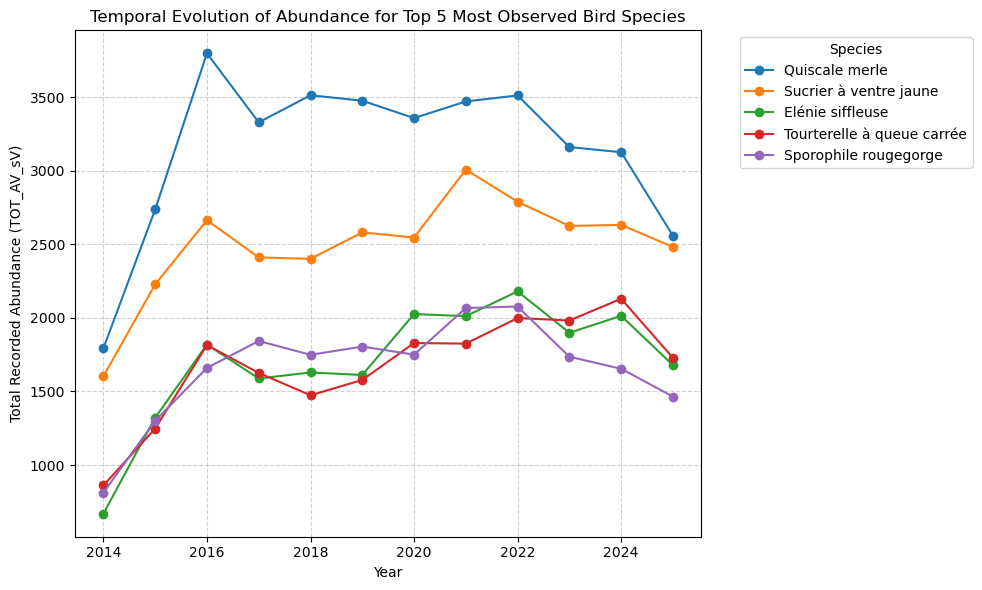

In [41]:
plt.figure(figsize=(10, 6))

for species in top5_species:
    sub = top5_data[top5_data["ESPECE"] == species]
    plt.plot(sub["year"], sub["TOT_AV_sV"], marker="o", label=species)

plt.title("Temporal Evolution of Abundance for Top 5 Most Observed Bird Species")
plt.xlabel("Year")
plt.ylabel("Total Recorded Abundance (TOT_AV_sV)")
plt.legend(title="Species", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Normalization to compare trends

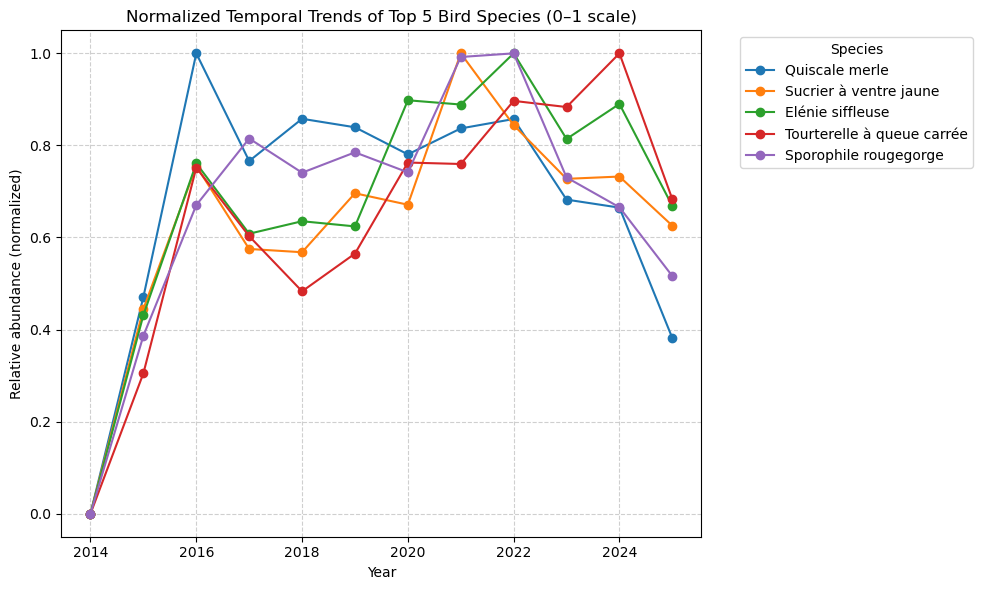

In [42]:
top5_data_norm = top5_data.copy()
top5_data_norm["scaled"] = top5_data_norm.groupby("ESPECE")["TOT_AV_sV"].transform(
    lambda s: (s - s.min()) / (s.max() - s.min() + 1e-9)
)

plt.figure(figsize=(10, 6))
for species in top5_species:
    sub = top5_data_norm[top5_data_norm["ESPECE"] == species]
    plt.plot(sub["year"], sub["scaled"], marker="o", label=species)

plt.title("Normalized Temporal Trends of Top 5 Bird Species (0–1 scale)")
plt.xlabel("Year")
plt.ylabel("Relative abundance (normalized)")
plt.legend(title="Species", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Bootstrap + CIs

In [43]:
bootstrap_results = []

for species in top5_species:
    sp = df[df["ESPECE"] == species]
    
    for year, group in sp.groupby("year"):
        counts = group["TOT_AV_sV"].values
        
        mean, ci_low, ci_high = bootstrap_ci(counts,func=np.mean, B=1000, alpha=0.05)
        
        bootstrap_results.append({
            "species": species,
            "year": year,
            "mean_abundance": mean,
            "ci_low": ci_low,
            "ci_high": ci_high
        })

bootstrap_df_species = pd.DataFrame(bootstrap_results).sort_values(["species","year"])
bootstrap_df_species.head()


species    year  mean_abundance    ci_low   ci_high
24  Elénie siffleuse  2014.0        1.668329  1.566085  1.778055
25  Elénie siffleuse  2015.0        1.992459  1.906486  2.082994
26  Elénie siffleuse  2016.0        2.086009  1.952982  2.199570
27  Elénie siffleuse  2017.0        2.092227  1.989394  2.209486
28  Elénie siffleuse  2018.0        1.932384  1.861151  2.000030

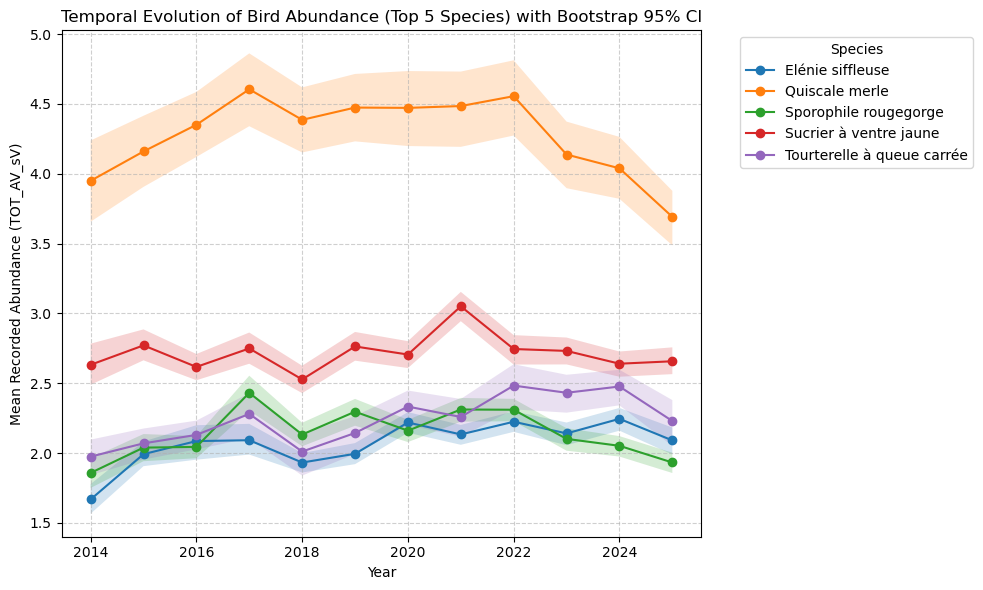

In [44]:
plt.figure(figsize=(10, 6))

for species, group in bootstrap_df_species.groupby("species"):
    plt.plot(group["year"], group["mean_abundance"], marker="o", label=species)
    plt.fill_between(group["year"], group["ci_low"], group["ci_high"], alpha=0.2)

plt.title("Temporal Evolution of Bird Abundance (Top 5 Species) with Bootstrap 95% CI")
plt.xlabel("Year")
plt.ylabel("Mean Recorded Abundance (TOT_AV_sV)")
plt.legend(title="Species", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


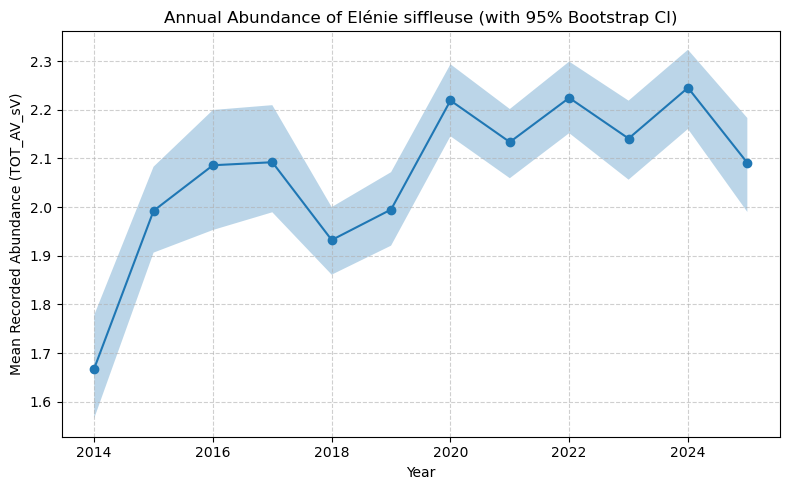

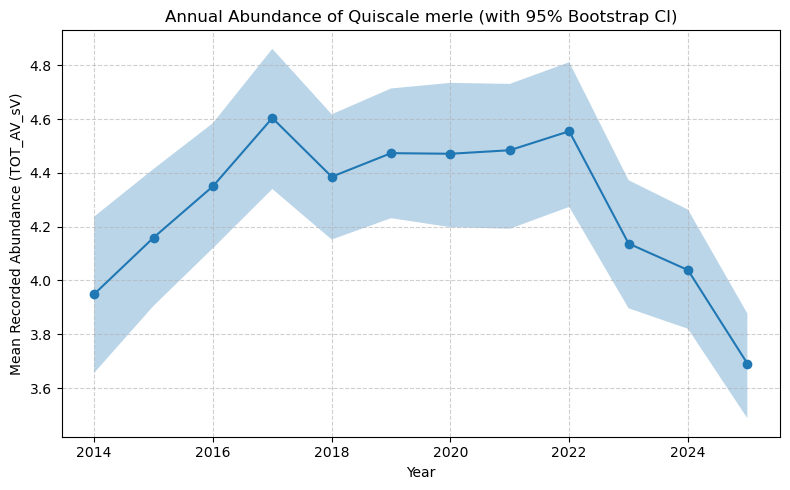

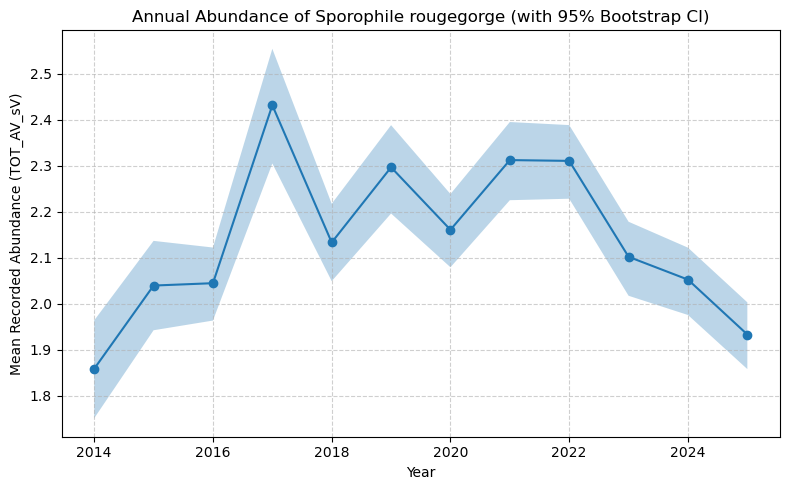

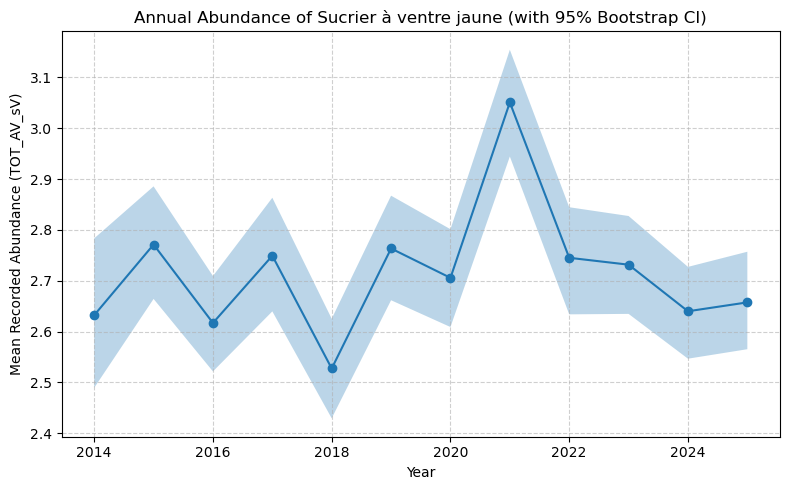

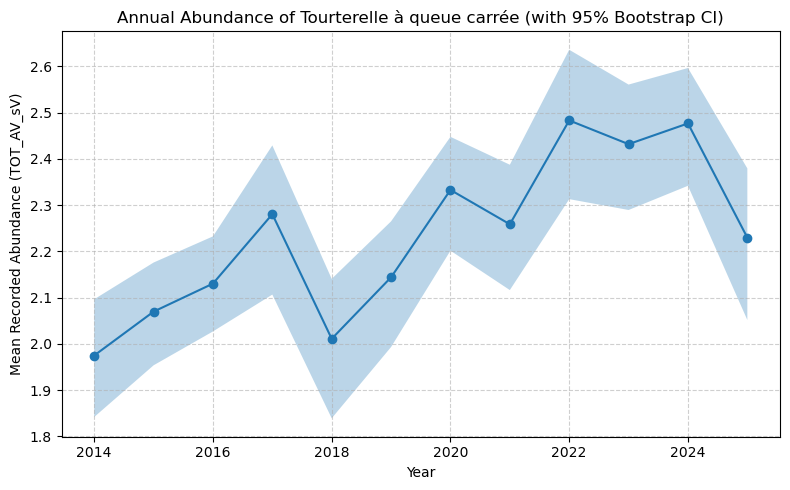

In [45]:
for species, group in bootstrap_df_species.groupby("species"):
    plt.figure(figsize=(8,5))
    plt.plot(group["year"], group["mean_abundance"], marker="o")
    plt.fill_between(group["year"], group["ci_low"], group["ci_high"], alpha=0.3)
    plt.title(f"Annual Abundance of {species} (with 95% Bootstrap CI)")
    plt.xlabel("Year")
    plt.ylabel("Mean Recorded Abundance (TOT_AV_sV)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


We use mean abundance instead of total number counted per year because:

 - Sampling effort changes across years (number of transects visited, observers present, duration, weather conditions, etc.).
 - The total number of birds counted is therefore not directly comparable from year to year.

But the mean abundance standardizes for effort, making trends fair and comparable.



## Trend Significance per Species


In [46]:
trend_results = []

for species, group in bootstrap_df_species.groupby("species"):
    
    # Sort by year to ensure correct alignment
    group = group.sort_values("year")
    
    # Linear regression test
    X = sm.add_constant(group["year"])   # predictor: year
    y = group["mean_abundance"]         # response: bootstrapped mean abundance
    model = sm.OLS(y, X).fit()
    
    slope = model.params["year"]
    p_slope = model.pvalues["year"]
    r2 = model.rsquared
    
   
    trend_results.append({
        "species": species,
        "slope (OLS)": slope,
        "p-value (OLS slope)": p_slope,
        "R² (trend fit)": r2
    })

trend_results_df = pd.DataFrame(trend_results)
trend_results_df

species  slope (OLS)  p-value (OLS slope)  \
0            Elénie siffleuse     0.030759             0.011863   
1              Quiscale merle    -0.018780             0.448744   
2       Sporophile rougegorge     0.003967             0.795352   
3      Sucrier à ventre jaune     0.004862             0.672132   
4  Tourterelle à queue carrée     0.036800             0.004150   

   R² (trend fit)  
0        0.485021  
1        0.058521  
2        0.007046  
3        0.018651  
4        0.577075

For all this species except "Quiscale merle" , the slope is > 0 , so species abundance is increasing over time, but the only significant values are for "Elénie siffleuse" and 	"Tourterelle à queue carrée". "Quiscale merle" has also a significant negative value, so could suppose that the abundance is decreasing over the time, but the p-value is quite high. This suggests a possible decline, but evidence is weak. By looking at p-value (< 0.05), we can say that trend is statistically significant for "Elénie siffleuse" and "Tourterelle à queue carrée".

### Trend Line + Bootstrap CI + Observed Points (per species)

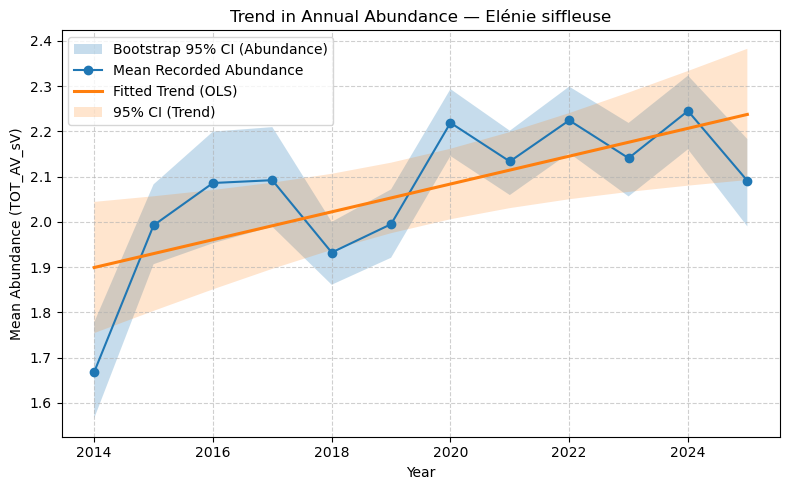

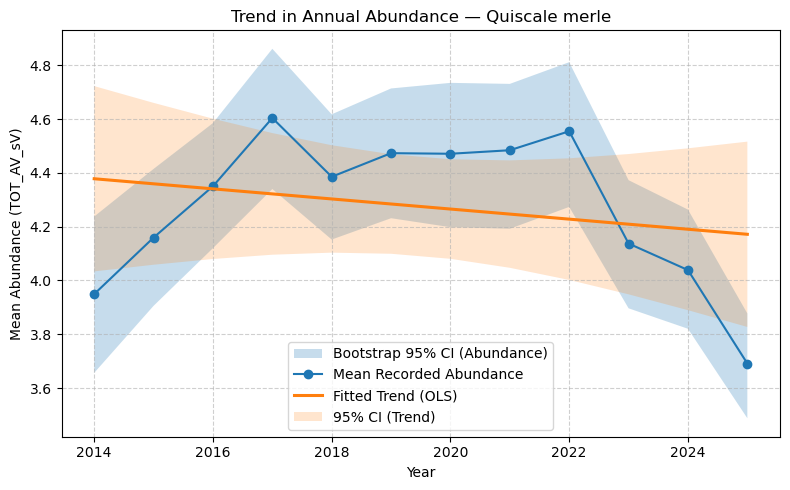

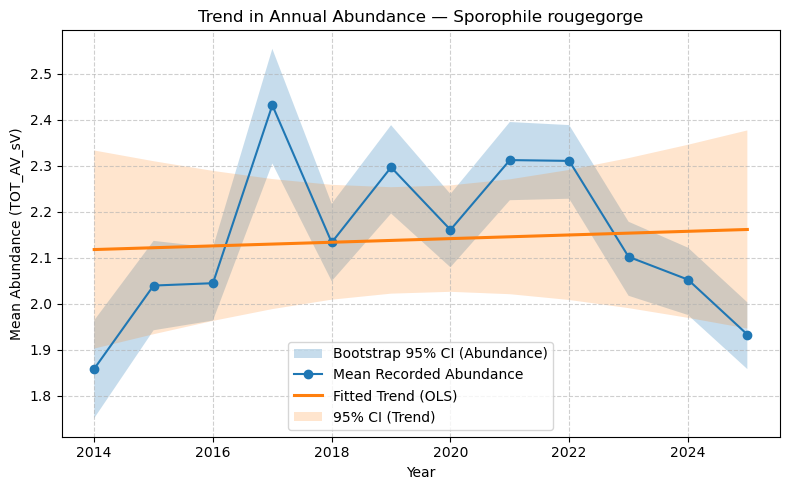

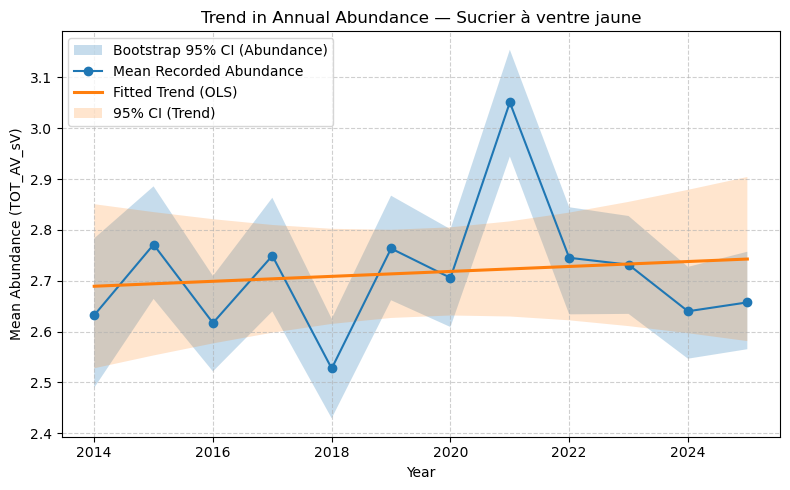

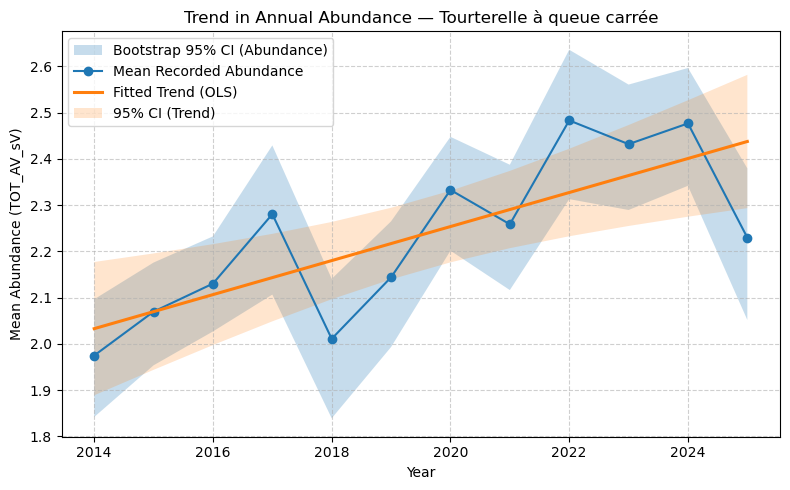

In [47]:
for species, group in bootstrap_df_species.groupby("species"):
    
    group = group.sort_values("year")  # ensure correct order
    years = group["year"].values
    y = group["mean_abundance"].values
    
    # Fit regression for the species
    X = sm.add_constant(years)
    model = sm.OLS(y, X).fit()
    
    # Predictions + Confidence Interval for trend line
    pred = model.get_prediction(X).summary_frame(alpha=0.05)
    y_fit = pred["mean"]
    y_low = pred["mean_ci_lower"]
    y_high = pred["mean_ci_upper"]
    
    # Plot
    plt.figure(figsize=(8,5))
    
    # Bootstrap CI (vertical uncertainty)
    plt.fill_between(years, group["ci_low"], group["ci_high"], alpha=0.25, label="Bootstrap 95% CI (Abundance)")
    
    # Observed points
    plt.plot(years, y, marker="o", linewidth=1.5, label="Mean Recorded Abundance")
    
    # Linear regression trend
    plt.plot(years, y_fit, linewidth=2.2, label="Fitted Trend (OLS)")
    
    # Confidence band for trend
    plt.fill_between(years, y_low, y_high, alpha=0.2, label="95% CI (Trend)")
    
    plt.title(f"Trend in Annual Abundance — {species}")
    plt.xlabel("Year")
    plt.ylabel("Mean Abundance (TOT_AV_sV)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


### Interpretation of Species-Specific Abundance Trends

The figures above display the temporal evolution of abundance for the five most frequently recorded bird species in the dataset, using the standardized mean abundance (TOT_AV_sV) per year and associated uncertainty estimated via bootstrap resampling. For **Élenie siffleuse**, the annual mean abundance shows a generally increasing pattern over the study period, and the fitted linear trend is positive with confidence intervals that do not overlap heavily with zero, indicating a statistically supported rise in abundance. A similar positive and statistically significant trend is observed for **Tourterelle à queue carrée**, where both the slope and the bootstrap confidence intervals suggest a sustained increase in occurrence intensity over time. 

In contrast, **Quiscale merle** shows a declining fitted trend line, but the year-to-year variability is relatively high and the confidence intervals are broader, resulting in a non-significant trend. This suggests that although the species may be experiencing a reduction in recorded abundance, further data or more controlled sampling would be needed to confidently confirm this decline. For **Sporophile rougegorge** and **Sucrier à ventre jaune**, the mean abundance values fluctuate from year to year without displaying a marked directional change. Their fitted trends are near-flat and associated confidence intervals are wide, indicating that these populations have remained relatively stable across the studied period.

Overall, these results highlight **two species experiencing significant increases** (Élenie siffleuse and Tourterelle à queue carrée), **one species with a possible but unconfirmed decline** (Quiscale merle), and **two species showing stable abundance levels with no evidence of directional long-term change** (Sporophile rougegorge and Sucrier à ventre jaune).


### Limitations

The mean-abundance and bootstrap approach provides a robust, effort-standardized indicator of species presence over time. However, this method does not explicitly correct for variation in detection probability (observer effects, weather, time of day), and assumes independence between sampling events, which may not always hold. Additionally, mean abundance reflects relative observation rates rather than absolute population sizes, because mean abundance is how often the species are recorded, not how many individuals exist in the ecosystem., and the linear trend model may not capture non-linear ecological dynamics. Therefore, while the approach reliably identifies broad directional changes, results should be interpreted as population indices rather than direct population estimates.


### Per-transect detection rate trends

In [48]:
# df is your cleaned observations table
df = df_clean_nom_francais.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year

# Define a canonical point-visit (denominator for detection rates)
visit_cols = ["Nom transect", "N° point", "date", "N° passage"]
df["visit_id"] = df[visit_cols].astype(str).agg("|".join, axis=1)

# Total visits per transect-year (denominator)
visits_tr_year = (
    df.drop_duplicates(["visit_id"])
      .groupby(["Nom transect", "year"])
      .size()
      .rename("N_visits_tr_year")
      .reset_index()
)

# If you already have top5_species, keep it; otherwise compute by total abundance
if "top5_species" not in globals():
    species_counts = df.groupby("ESPECE")["TOT_AV_sV"].sum().sort_values(ascending=False)
    top5_species = species_counts.head(5).index.tolist()
top5_species


['Quiscale merle',
 'Sucrier à ventre jaune',
 'Elénie siffleuse',
 'Tourterelle à queue carrée',
 'Sporophile rougegorge']

In [49]:
# Mark detections for each species-row
df["detected"] = (df["TOT_AV_sV"] > 0).astype(int)

# Detections per species–transect–year (K_detects)
det_counts = (
    df[df["detected"] == 1]
      .drop_duplicates(["visit_id", "ESPECE"])  # one detection per visit per species
      .groupby(["ESPECE", "Nom transect", "year"])
      .size()
      .rename("K_detects")
      .reset_index()
)

# Evaluate only the combos we care about: (top-5 species) × (transect, year)
comb = (
    df[df["ESPECE"].isin(top5_species)]
      .drop_duplicates(["ESPECE", "Nom transect", "year"])
      [["ESPECE", "Nom transect", "year"]]
)

# Bring in denominators then detection counts
det_tr_yr = (
    comb
    .merge(visits_tr_year, on=["Nom transect", "year"], how="left")
    .merge(det_counts, on=["ESPECE", "Nom transect", "year"], how="left")
)

# Fill and compute detection rate
det_tr_yr["N_visits_tr_year"] = det_tr_yr["N_visits_tr_year"].fillna(0).astype(int)
det_tr_yr["K_detects"] = det_tr_yr["K_detects"].fillna(0).astype(int)
det_tr_yr["det_rate"] = np.where(
    det_tr_yr["N_visits_tr_year"] > 0,
    det_tr_yr["K_detects"] / det_tr_yr["N_visits_tr_year"],
    np.nan
)

det_tr_yr.head(10)


ESPECE                 Nom transect    year  \
0      Sucrier à ventre jaune                 Fond l'Etang  2014.0   
1            Elénie siffleuse                 Fond l'Etang  2014.0   
2       Sporophile rougegorge                 Fond l'Etang  2014.0   
3              Quiscale merle                 Fond l'Etang  2014.0   
4  Tourterelle à queue carrée                 Fond l'Etang  2014.0   
5              Quiscale merle  Fort de France Centre Ville  2014.0   
6       Sporophile rougegorge  Fort de France Centre Ville  2014.0   
7  Tourterelle à queue carrée  Fort de France Centre Ville  2014.0   
8      Sucrier à ventre jaune  Fort de France Centre Ville  2014.0   
9            Elénie siffleuse  Fort de France Centre Ville  2014.0   

   N_visits_tr_year  K_detects  det_rate  
0                20         14      0.70  
1                20         15      0.75  
2                20         12      0.60  
3                20          6      0.30  
4                20          5      0.25  
5                20         15      0.75  
6                20         13      0.65  
7                20         18      0.90  
8                20         12      0.60  
9                20          2      0.10

In [50]:
def fit_logistic_trend_per_transect(d):
    """
    d: slice of det_tr_yr for one species & one transect.
       Needs columns year, det_rate, N_visits_tr_year.
    Returns statsmodels result or None if insufficient data.
    """
    mask = (d["N_visits_tr_year"] > 0) & d["det_rate"].notna()
    d2 = d.loc[mask]
    if len(d2) < 3:
        return None
    X = sm.add_constant(d2["year"])
    # Binomial GLM on proportions with frequency weights = #visits
    res = sm.GLM(d2["det_rate"], X, family=sm.families.Binomial(), freq_weights=d2["N_visits_tr_year"]).fit()
    return res

# Example: run for each top species on their 6 most-sampled transects
for sp in top5_species:
    d_sp = det_tr_yr[det_tr_yr["ESPECE"] == sp]
    top_tr = (d_sp.groupby("Nom transect")["N_visits_tr_year"].sum()
                    .sort_values(ascending=False).head(6).index)
    print(f"\n=== {sp} ===")
    for tr in top_tr:
        d_tr = d_sp[d_sp["Nom transect"] == tr].sort_values("year")
        res = fit_logistic_trend_per_transect(d_tr)
        if res is None:
            print(f"- {tr}: not enough data")
        else:
            slope = res.params.get("year", np.nan)
            pval = res.pvalues.get("year", np.nan)
            print(f"- {tr}: slope={slope:.4f}, p={pval:.3f}")



=== Quiscale merle ===
- Petit Sentier RNC: slope=-0.0059, p=0.888
- Fort de France Centre Ville: slope=-0.0290, p=0.542
- Tunnel Didier 2: slope=0.0029, p=0.941
- Habitation Petite Rivière: slope=-0.1644, p=0.020
- O'Mullane: slope=-0.0775, p=0.074
- Fond Rousseau: slope=0.0342, p=0.506

=== Sucrier à ventre jaune ===
- Petit Sentier RNC: slope=-0.0410, p=0.301
- Tunnel Didier 2: slope=0.0194, p=0.779
- Pointe Lynch: slope=0.1390, p=0.001
- Fort de France Centre Ville: slope=0.0115, p=0.781
- Habitation Petite Rivière: slope=-0.0239, p=0.773
- Fond Rousseau: slope=0.0901, p=0.083

=== Elénie siffleuse ===
- Tunnel Didier 2: slope=0.1104, p=0.008
- Pointe Lynch: slope=0.1299, p=0.007
- Habitation Petite Rivière: slope=0.1000, p=0.018
- Galion: slope=-0.1401, p=0.001
- Morne Babet: slope=0.0790, p=0.041
- La Démarche: slope=0.3111, p=0.000

=== Tourterelle à queue carrée ===
- Petit Sentier RNC: slope=-0.0363, p=0.364
- Fort de France Centre Ville: slope=-0.0232, p=0.737
- Pointe Lynch

In [51]:
# Wilson CI (good coverage even for small n)
def wilson_ci(k, n, alpha=0.05):
    if (n is None) or (n == 0):
        return (np.nan, np.nan)
    z = 1.96  # 95% CI
    p = k / n
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    lo, hi = center - half, center + half
    # enforce [0,1] and monotonic relationship
    lo = max(0.0, min(lo, p))
    hi = min(1.0, max(hi, p))
    return lo, hi

# (Optional) exact Clopper–Pearson:
# from statsmodels.stats.proportion import proportion_confint
# lo, hi = proportion_confint(k, n, alpha=0.05, method="beta")

# Add CI columns to det_tr_yr
ci = det_tr_yr.apply(lambda r: wilson_ci(r["K_detects"], r["N_visits_tr_year"]), axis=1)
det_tr_yr["det_low"], det_tr_yr["det_high"] = zip(*ci)


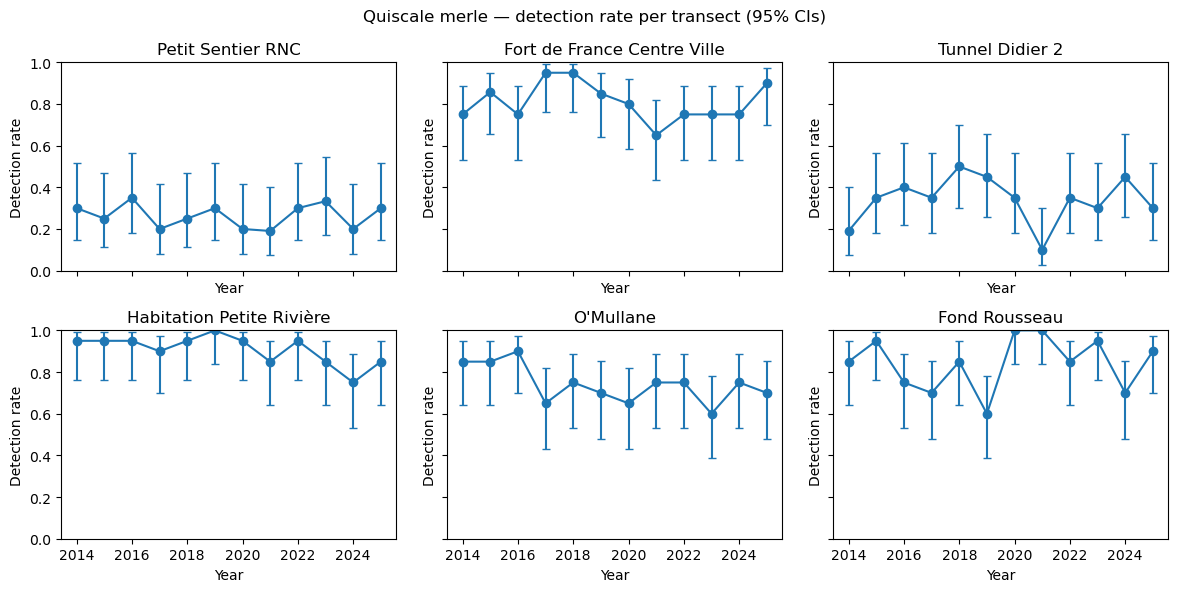

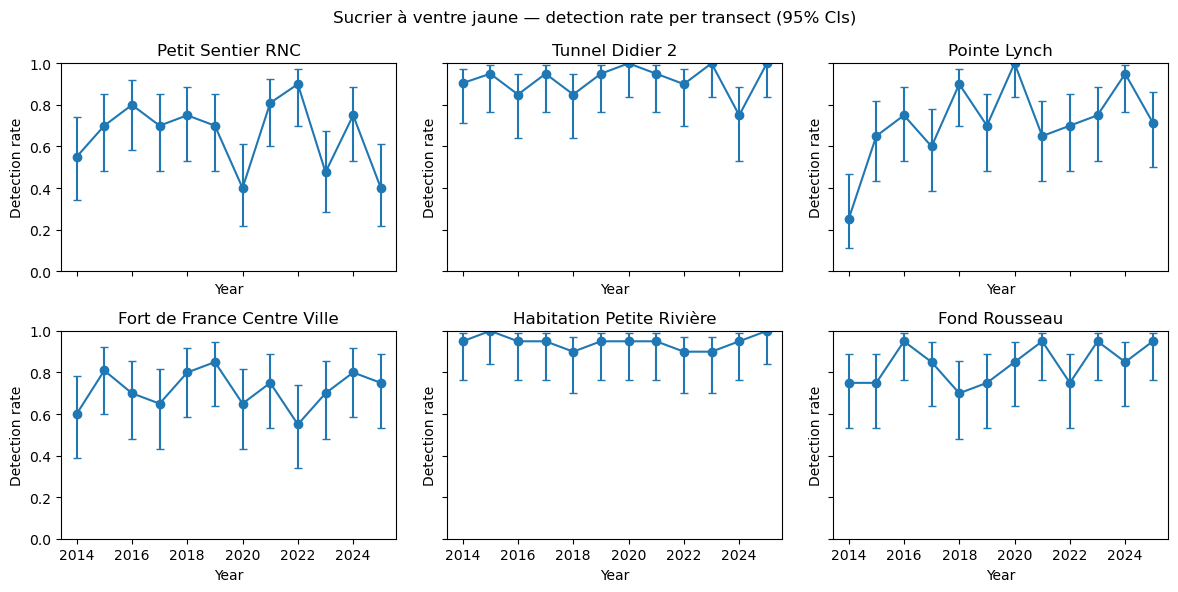

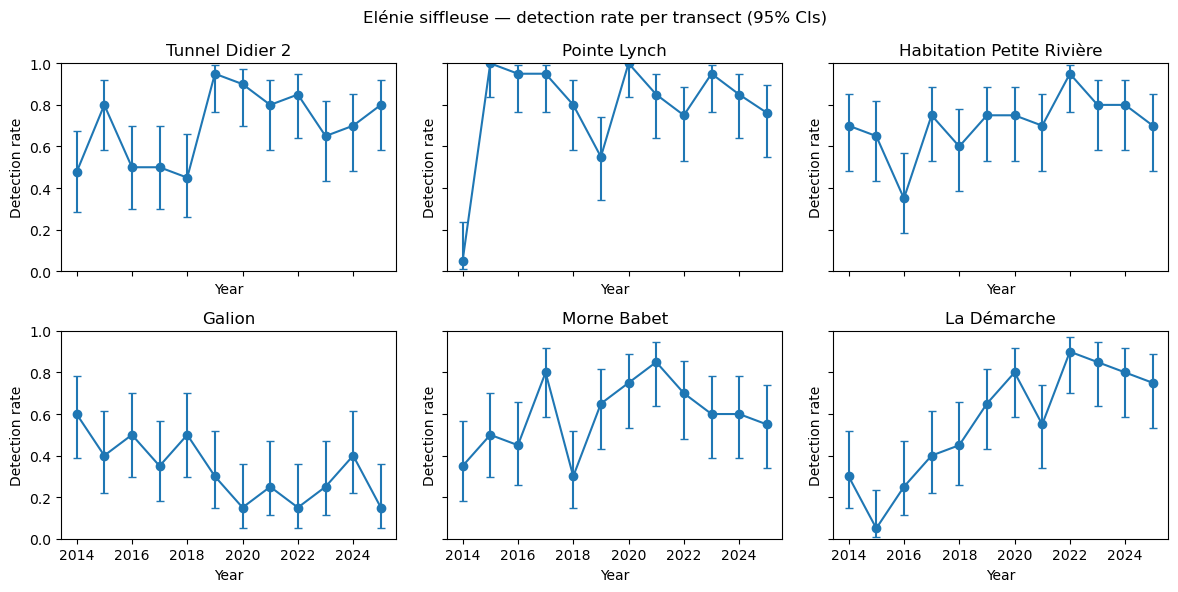

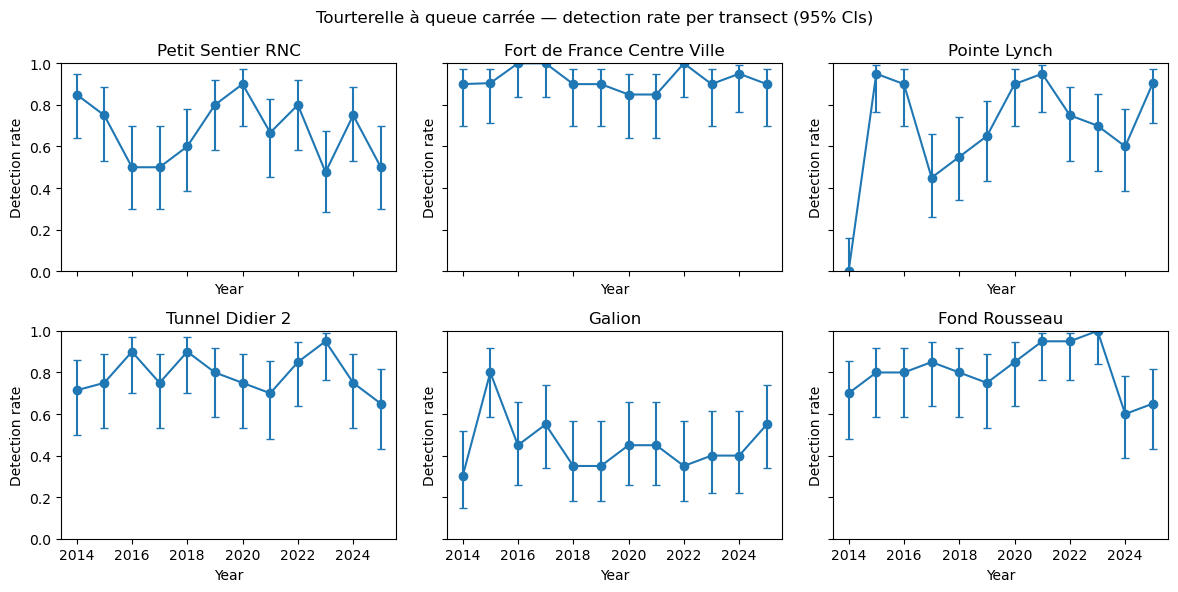

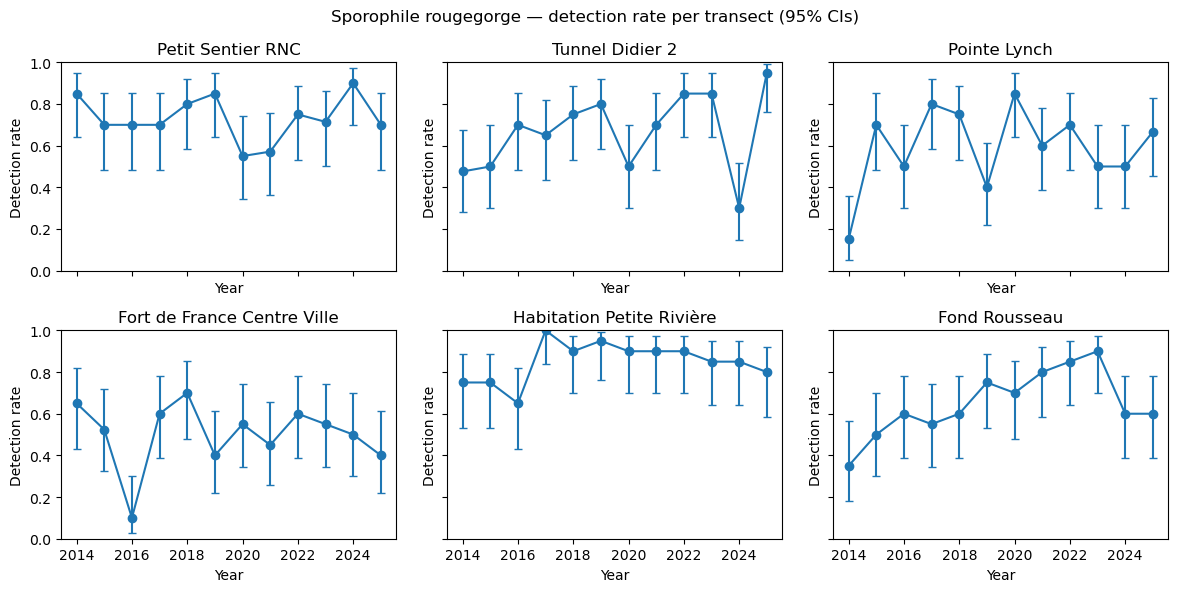

In [52]:
def plot_transect_panels_with_ci(det_tr_yr, species, n_tr=6):
    d_sp = det_tr_yr[det_tr_yr["ESPECE"] == species]
    trs = (d_sp.groupby("Nom transect")["N_visits_tr_year"].sum()
                .sort_values(ascending=False).head(n_tr).index)
    n = len(trs); ncols = 3; nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3*nrows), sharex=True, sharey=True)
    axes = axes.ravel()
    for i, tr in enumerate(trs):
        dd = d_sp[d_sp["Nom transect"] == tr].sort_values("year").copy()
        dd = dd[(dd["N_visits_tr_year"] > 0) & dd["det_rate"].notna()]
        if len(dd) == 0:
            axes[i].set_title(tr + " (no data)"); axes[i].axis("off"); continue
        lohi = dd.apply(lambda r: wilson_ci(r["K_detects"], r["N_visits_tr_year"]), axis=1)
        dd["det_low"], dd["det_high"] = zip(*lohi)
        dd["det_low"] = np.minimum(dd["det_low"].clip(0,1), dd["det_rate"])
        dd["det_high"] = np.maximum(dd["det_high"].clip(0,1), dd["det_rate"])
        yerr_lower = np.clip(np.nan_to_num(dd["det_rate"] - dd["det_low"], nan=0.0), 0, None)
        yerr_upper = np.clip(np.nan_to_num(dd["det_high"] - dd["det_rate"], nan=0.0), 0, None)
        yerr = np.vstack([yerr_lower, yerr_upper])

        axes[i].errorbar(dd["year"], dd["det_rate"], yerr=yerr, fmt="o-", capsize=3)
        axes[i].set_title(tr); axes[i].set_xlabel("Year"); axes[i].set_ylabel("Detection rate")
    for j in range(i+1, len(axes)): axes[j].axis("off")
    fig.suptitle(f"{species} — detection rate per transect (95% CIs)")
    plt.ylim(0, 1); plt.tight_layout(); plt.show()
    

for sp in top5_species:
    plot_transect_panels_with_ci(det_tr_yr, sp, n_tr=6)

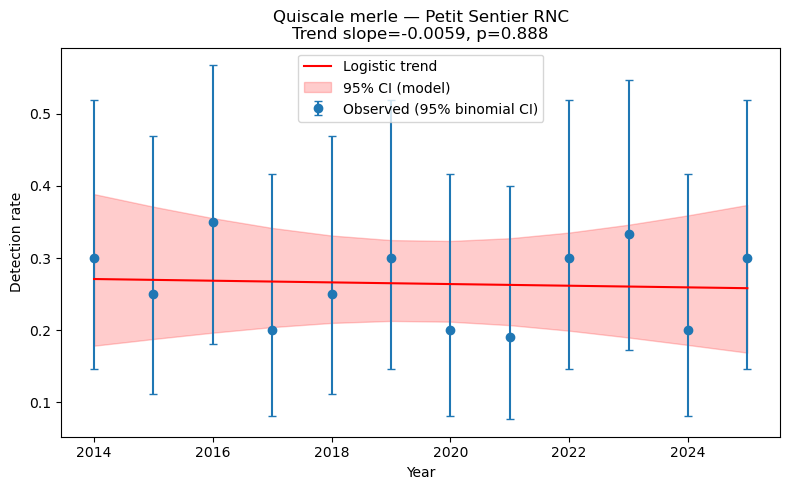

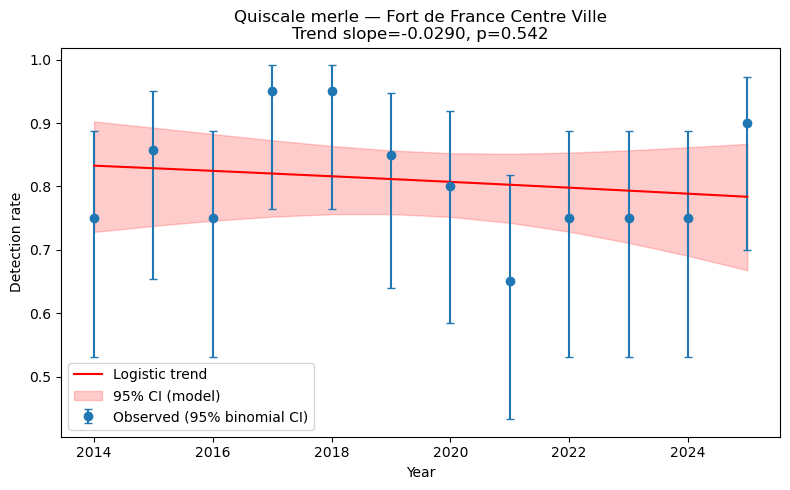

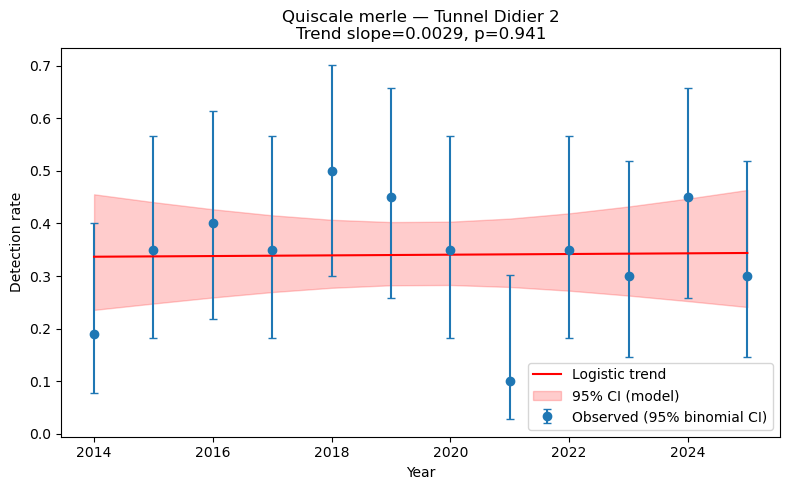

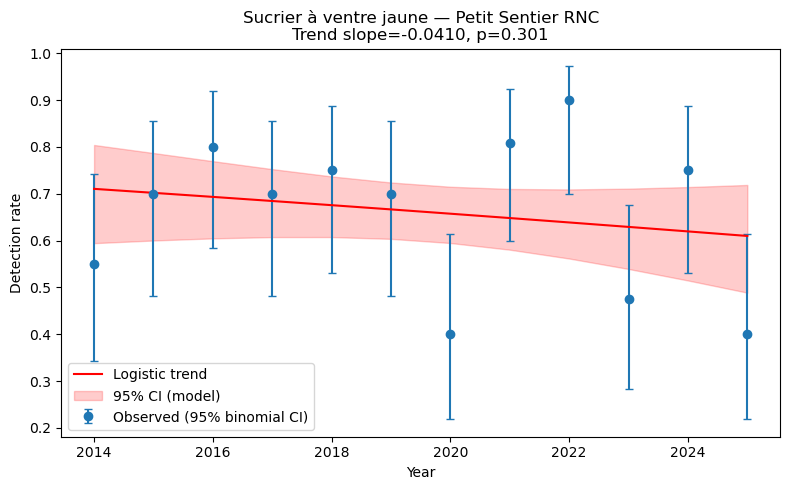

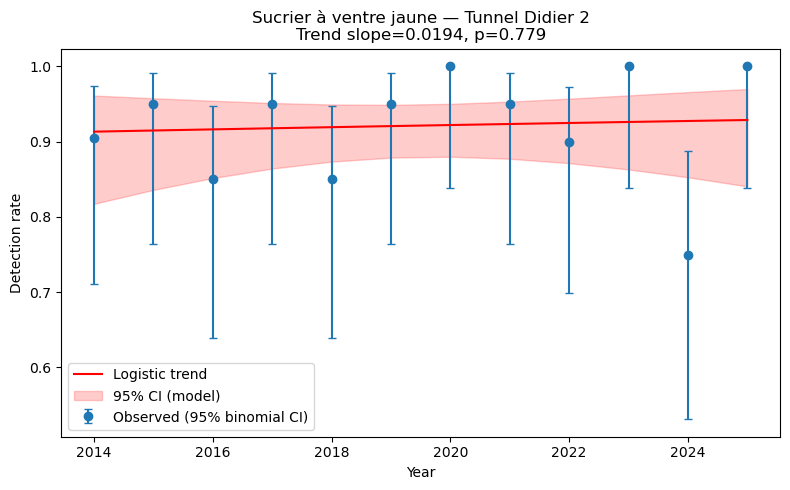

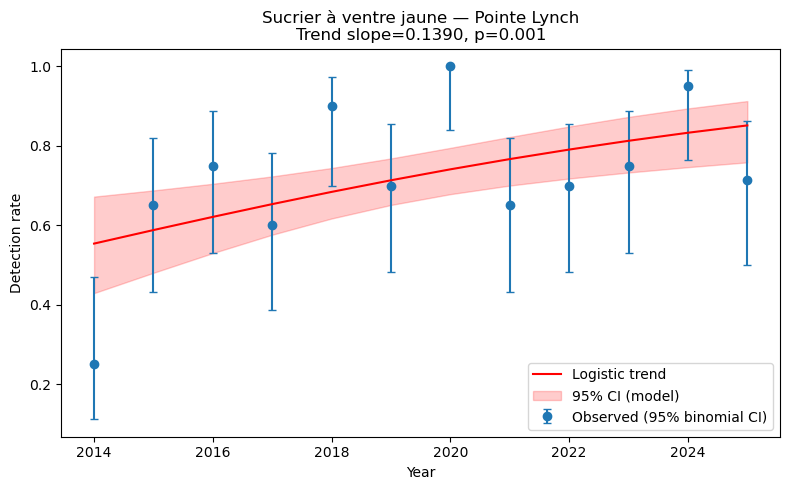

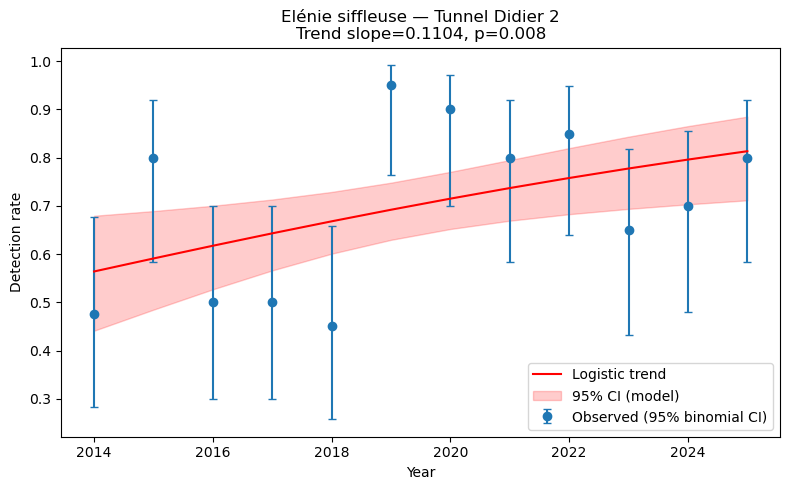

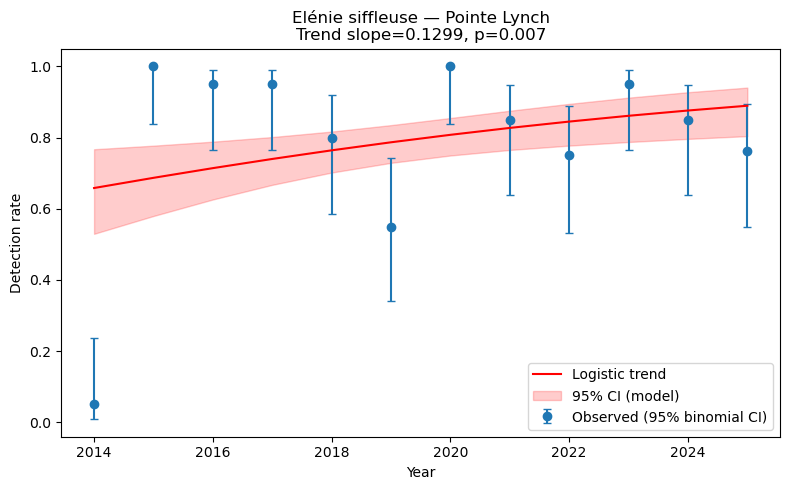

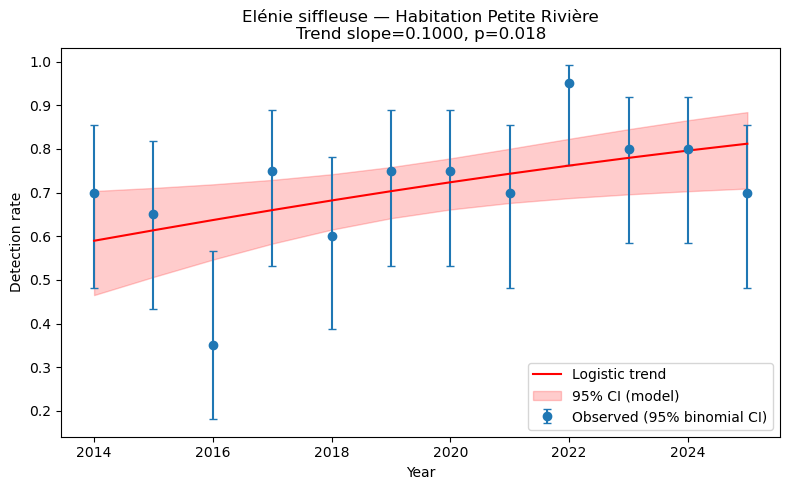

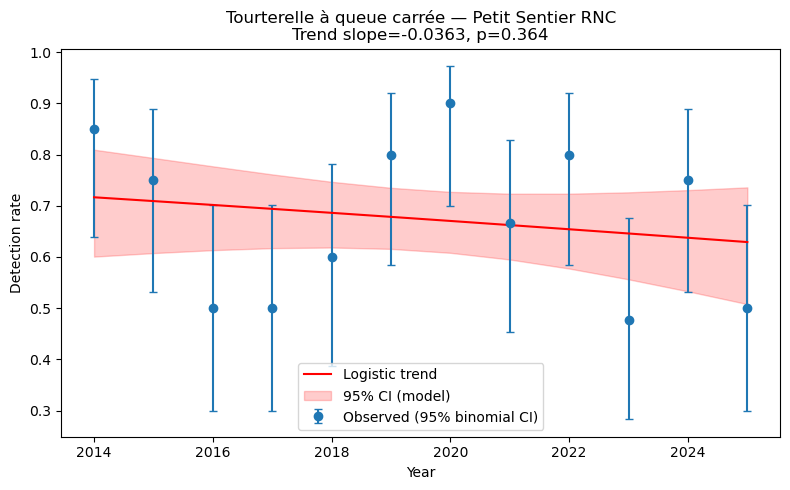

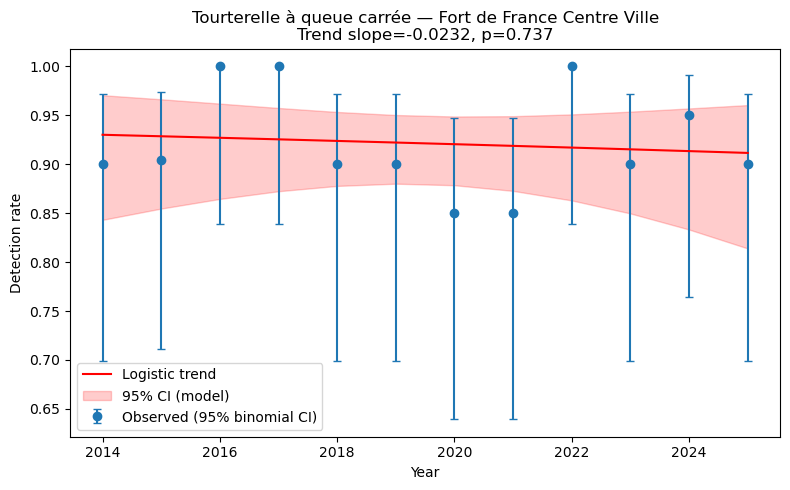

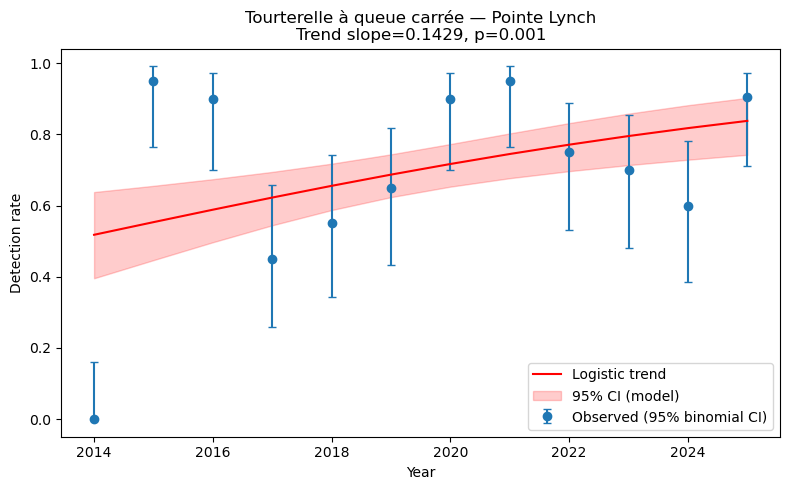

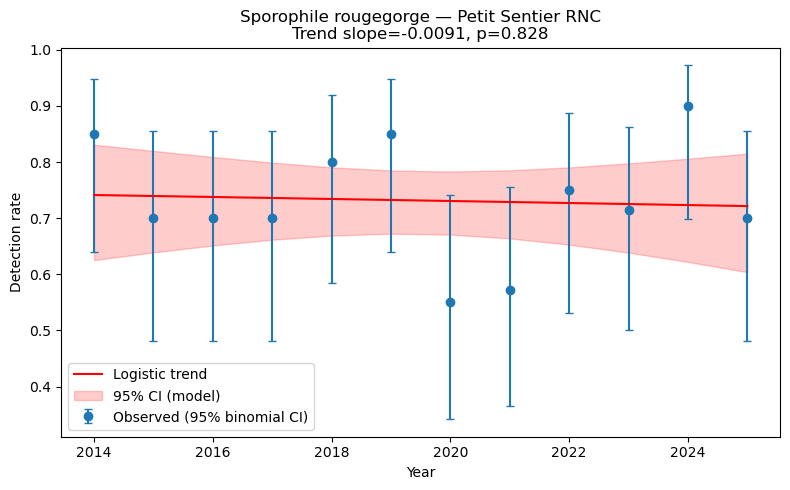

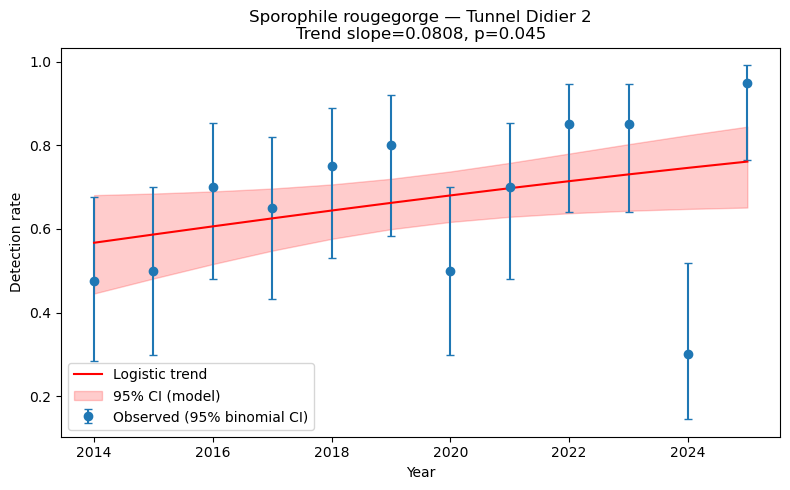

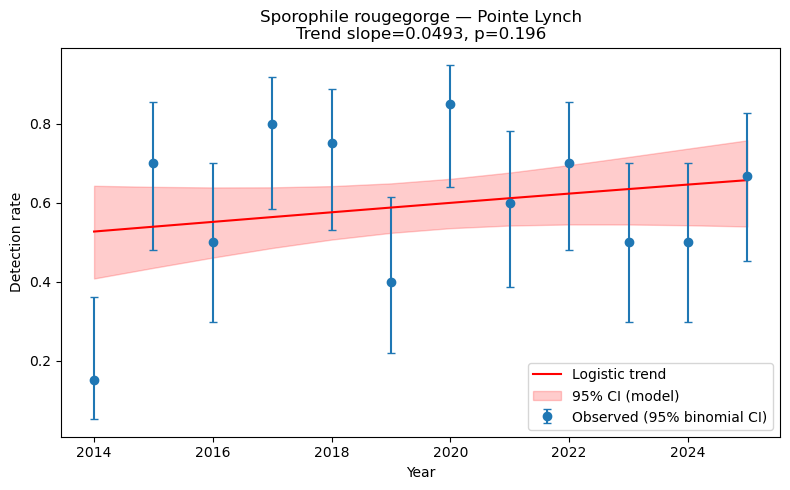

In [53]:
def fit_logistic_trend_per_transect(d):
    # keep rows with visits > 0
    d = d[(d["N_visits_tr_year"] > 0) & d["det_rate"].notna()]
    if len(d) < 3:
        return None, None
    X = sm.add_constant(d["year"])
    res = sm.GLM(d["det_rate"], X,
                 family=sm.families.Binomial(),
                 freq_weights=d["N_visits_tr_year"]).fit()
    pred = res.get_prediction(X)
    pred_df = pred.summary_frame()   # columns: mean, mean_ci_lower, mean_ci_upper (on response scale)
    out = d.copy()
    out["fit"] = pred_df["mean"].values
    out["fit_low"] = pred_df["mean_ci_lower"].values
    out["fit_high"] = pred_df["mean_ci_upper"].values
    return res, out

def plot_transect_with_model(det_tr_yr, species, transect):
    d = det_tr_yr[(det_tr_yr["ESPECE"] == species) & (det_tr_yr["Nom transect"] == transect)].sort_values("year")
    res, fitted = fit_logistic_trend_per_transect(d)
    if res is None:
        print(f"{species} — {transect}: not enough data"); return
    slope = res.params.get("year", np.nan); pval = res.pvalues.get("year", np.nan)

    plt.figure(figsize=(8,5))
    # observed + Wilson CI
    plt.errorbar(d["year"], d["det_rate"],
                 yerr=[d["det_rate"]-d["det_low"], d["det_high"]-d["det_rate"]],
                 fmt="o", capsize=3, label="Observed (95% binomial CI)")
    # fitted line + model CI
    plt.plot(fitted["year"], fitted["fit"], "r-", label="Logistic trend")
    plt.fill_between(fitted["year"], fitted["fit_low"], fitted["fit_high"], color="r", alpha=0.2,
                     label="95% CI (model)")
    plt.title(f"{species} — {transect}\nTrend slope={slope:.4f}, p={pval:.3f}")
    plt.xlabel("Year"); plt.ylabel("Detection rate"); plt.legend(); plt.tight_layout(); plt.show()

# Example: plot a couple of transects per species
for sp in top5_species:
    d_sp = det_tr_yr[det_tr_yr["ESPECE"] == sp]
    top_tr = (d_sp.groupby("Nom transect")["N_visits_tr_year"].sum()
                    .sort_values(ascending=False).head(3).index)
    for tr in top_tr:
        plot_transect_with_model(det_tr_yr, sp, tr)


### Discussion about detection rate
---

#### Limitations : 

dzadada

#### Potential reasons behind data behavior :

dada

